In [7]:
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import linear_sum_assignment

import sys
sys.path.append('..')
from src.interface import UnitedNet
from src.configs import *
import copy as copy


In [8]:
def partitions(celltype, n_partitions, seed=0):
    """
    adapted from https://github.com/AllenInstitute/coupledAE-patchseq
    """
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    # Safe to ignore warning - there are celltypes with a low sample number that are not crucial for the analysis.
    with warnings.catch_warnings():
        skf = StratifiedKFold(n_splits=n_partitions, random_state=seed, shuffle=True)

    # Get all partition indices from the sklearn generator:
    ind_dict = [{'train': train_ind, 'val': val_ind} for train_ind, val_ind in
                skf.split(X=np.zeros(shape=celltype.shape), y=celltype)]
    return ind_dict
    
def save_umap(adata_all,label,test_batch,nametype):
  fig,ax = plt.subplots(figsize=(6,4))
  ax=sc.pl.umap(adata_all,color=label, ax=ax,show=False)
  fig.savefig(root_save_path+f'/plot/{test_batch}_{nametype}_{label}.png',dpi=300)
  

def generate_adata(data, nonnan_indices, cell_type_label, cols, rows, batch):
    data = data.loc[data.index[nonnan_indices]]
    adata=ad.AnnData(X=np.array(data),obs=list(data.index))
    adata.obs['label']  = cell_type_label
    adata.obs['imagecol'] = cols
    adata.obs['imagerow'] = rows
    adata.obs['batch']  = batch
    return adata


def ordered_cmat(labels, pred):
    """
    Compute the confusion matrix and accuracy corresponding to the best cluster-to-class assignment.

    :param labels: Label array
    :type labels: np.array
    :param pred: Predictions array
    :type pred: np.array
    :return: Accuracy and confusion matrix
    :rtype: Tuple[float, np.array]
    """
    cmat = confusion_matrix(labels, pred)
    ri, ci = linear_sum_assignment(-cmat)
    ordered = cmat[np.ix_(ri, ci)]
    acc = np.sum(np.diag(ordered))/np.sum(ordered)
    return acc, ordered

def assignmene_align(labels1,labels2):
    C_e_types = confusion_matrix(labels1, labels2)
    #Assign labels of clusters based on 'best match' with transcriptomic celltype label
    row_ind,col_ind = linear_sum_assignment(-C_e_types)
    order_2 = np.unique(labels2)[col_ind]
    labels2_matched = copy.deepcopy(labels2)
    for name, orig_name in zip(np.unique(labels2),order_2):
        ind = labels2 == orig_name
        labels2_matched[ind] = name
    return labels2_matched

In [9]:
def pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=False):
  adata_rna,adata_ephys,adata_morph = adata_rna_raw.copy(),adata_ephys_raw.copy(),adata_morph_raw.copy()
  adatas_train,adatas_test = [],[]
  assert (adata_rna.X>=0).all(), "poluted input"
  for mod in [adata_rna,adata_ephys,adata_morph]:
    mod.obs['label'] = mod.obs['cell_type_TEM']
    if split:
      m_train = mod[ind_dict[cv]['train']]
      scaler = preprocessing.StandardScaler().fit(m_train.X)
      m_train.X = scaler.transform(m_train.X)

      m_test = mod[ind_dict[cv]['val']]
      scaler = preprocessing.StandardScaler().fit(m_test.X)
      m_test.X = scaler.transform(m_test.X)
    else:
      scaler = preprocessing.StandardScaler().fit(mod.X)
      mod.X = scaler.transform(mod.X)
      m_train = mod[ind_dict[cv]['train']]
      m_test = mod[ind_dict[cv]['val']]

    adatas_train.append(m_train)
    adatas_test.append(m_test)
  adatas_all = [ad.concat([m_train,m_test]) for m_train,m_test in zip(adatas_train,adatas_test)]
  return adatas_train,adatas_test,adatas_all

# load input patch-seq data

In [10]:
technique = 'patchseq'
data_path = f"../data/{technique}"
device = "cuda:0"
root_save_path = f"../saved_results/{technique}"
#load data
adata_rna_raw = sc.read_h5ad(f'{data_path}/adata_RNA_TEM.h5ad')
adata_ephys_raw = sc.read_h5ad(f'{data_path}/adata_Ephys_TEM.h5ad')
adata_morph_raw = sc.read_h5ad(f'{data_path}/adata_Morph_TEM.h5ad')
ind_dict = partitions(adata_rna_raw.obs['cell_type_TEM'], n_partitions=10, seed=0)


In [ ]:
for cv in range(8,10):
  adatas_train,adatas_test,_ = pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=True)
  root_save_path = f"./saved_results/{technique}_{cv}"
  model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
  model.train(adatas_train,adatas_val = adatas_test)

  print(model.evaluate(adatas_test))
  _,_,adatas_all = pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=False)
  model.load_model(f"{root_save_path}/train_best.pt")
  model.model.config['train_task'] = "unsupervised_group_identification"
  model.model.config['train_epochs'] = 20
  model.train(adatas_all,verbose=True,init_classify=True)
  
  

training


100%|██████████| 20/20 [00:53<00:00,  2.65s/it]


{'r2': array([[0.22038445, 0.15551331, 0.11510899],
       [0.32815638, 0.63781966, 0.11472887],
       [0.10581995, 0.01990426, 0.45908063]]), 'acc': tensor(0.0444), 'ari': 0.31054131054131057, 'nmi': 0.8405405997686622}
training


  0%|          | 0/30 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0315262
ddc_loss_head_4            0.147503
ddc_loss_head_6            0.14823
ddc_loss_head_9            0.150089
ddc_loss_head_0            0.148161
ddc_loss_head_2            0.149761
self_entropy_loss_head_4  -0.0314683
ddc_loss_head_7            0.147833
ddc_loss_head_5            0.148799
self_entropy_loss_head_0  -0.031369
self_entropy_loss_head_3  -0.0313005
ddc_loss_head_8            0.147725
self_entropy_loss_head_7  -0.0309208
ddc_loss_head_1            0.148622
ddc_loss_head_3            0.149315
self_entropy_loss_head_9  -0.0313608
self_entropy_loss_head_2  -0.0312891
self_entropy_loss_head_5  -0.0313434
reconstruction_loss        0.514128
self_entropy_loss_head_1  -0.0313223
self_entropy_loss_head_8  -0.0313046
best_head                  4
best model saved at ./saved_results/patchseq_0/train_best.pt 

model saved at ./saved_results/patchseq_0/train_epoch_1.pt 



  3%|▎         | 1/30 [00:03<01:47,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.22395116 0.20491925 0.19319355]
            [0.44039614 0.69116734 0.36083987]
            [0.33468278 0.28181651 0.51361365]]
acc        0.0647321417927742
ari        0.3434029754126107
nmi        0.5960190219645405


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0309975
ddc_loss_head_4            0.13721
ddc_loss_head_6            0.136439
ddc_loss_head_9            0.138089
ddc_loss_head_0            0.137423
ddc_loss_head_2            0.138389
self_entropy_loss_head_4  -0.0311892
ddc_loss_head_7            0.135857
ddc_loss_head_5            0.136369
self_entropy_loss_head_0  -0.0308842
self_entropy_loss_head_3  -0.0309642
ddc_loss_head_8            0.136686
self_entropy_loss_head_7  -0.0308177
ddc_loss_head_1            0.137303
ddc_loss_head_3            0.137014
self_entropy_loss_head_9  -0.03082
self_entropy_loss_head_2  -0.0305667
self_entr

  7%|▋         | 2/30 [00:07<01:47,  3.82s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.24220826 0.22480318 0.20687817]
            [0.48247021 0.72309684 0.39659134]
            [0.36854179 0.33315393 0.54104784]]
acc        0.004464285913854837
ari        0.3649132843357871
nmi        0.6127116995469107


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.030697
ddc_loss_head_4            0.132457
ddc_loss_head_6            0.131886
ddc_loss_head_9            0.132283
ddc_loss_head_0            0.132824
ddc_loss_head_2            0.134463
self_entropy_loss_head_4  -0.0307164
ddc_loss_head_7            0.130843
ddc_loss_head_5            0.131372
self_entropy_loss_head_0  -0.0305759
self_entropy_loss_head_3  -0.0306522
ddc_loss_head_8            0.13203
self_entropy_loss_head_7  -0.0306245
ddc_loss_head_1            0.132022
ddc_loss_head_3            0.132305
self_entropy_loss_head_9  -0.0306642
self_entropy_loss_head_2  -0.0304232
self_e

 10%|█         | 3/30 [00:11<01:43,  3.84s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.25621366 0.23891699 0.21904125]
            [0.52059543 0.74930654 0.43285492]
            [0.3933236  0.34300762 0.54628503]]
acc        0.0022321429569274187
ari        0.35358827921628333
nmi        0.6111334965342735


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0304096
ddc_loss_head_4            0.129326
ddc_loss_head_6            0.128877
ddc_loss_head_9            0.128937
ddc_loss_head_0            0.129632
ddc_loss_head_2            0.131266
self_entropy_loss_head_4  -0.0305248
ddc_loss_head_7            0.128126
ddc_loss_head_5            0.128397
self_entropy_loss_head_0  -0.0303429
self_entropy_loss_head_3  -0.03038
ddc_loss_head_8            0.129196
self_entropy_loss_head_7  -0.030441
ddc_loss_head_1            0.128943
ddc_loss_head_3            0.129313
self_entropy_loss_head_9  -0.0303514
self_entropy_loss_head_2  -0.030355
self_e

 13%|█▎        | 4/30 [00:15<01:38,  3.80s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.27047241 0.24621628 0.23052005]
            [0.56369864 0.76546285 0.44308443]
            [0.41917805 0.38110716 0.56717346]]
acc        0.0066964286379516125
ari        0.32592008360463404
nmi        0.607413659617858


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0301115
ddc_loss_head_4            0.127157
ddc_loss_head_6            0.127339
ddc_loss_head_9            0.126773
ddc_loss_head_0            0.127978
ddc_loss_head_2            0.129135
self_entropy_loss_head_4  -0.0302684
ddc_loss_head_7            0.126353
ddc_loss_head_5            0.126682
self_entropy_loss_head_0  -0.0299992
self_entropy_loss_head_3  -0.0301185
ddc_loss_head_8            0.127651
self_entropy_loss_head_7  -0.030267
ddc_loss_head_1            0.127097
ddc_loss_head_3            0.127676
self_entropy_loss_head_9  -0.0300241
self_entropy_loss_head_2  -0.0299267
self

 17%|█▋        | 5/30 [00:18<01:34,  3.77s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.27780454 0.26456582 0.24661208]
            [0.58631013 0.78272982 0.48626125]
            [0.42797445 0.41174765 0.59658122]]
acc        0.013392857275903225
ari        0.3213390995207767
nmi        0.6187425041609909


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0299577
ddc_loss_head_4            0.125639
ddc_loss_head_6            0.126077
ddc_loss_head_9            0.124862
ddc_loss_head_0            0.126153
ddc_loss_head_2            0.127043
self_entropy_loss_head_4  -0.0300746
ddc_loss_head_7            0.125359
ddc_loss_head_5            0.125113
self_entropy_loss_head_0  -0.0297862
self_entropy_loss_head_3  -0.0299525
ddc_loss_head_8            0.125984
self_entropy_loss_head_7  -0.0301503
ddc_loss_head_1            0.125539
ddc_loss_head_3            0.126449
self_entropy_loss_head_9  -0.0297891
self_entropy_loss_head_2  -0.0298177
self

 20%|██        | 6/30 [00:22<01:30,  3.78s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.2905911  0.27948851 0.25649633]
            [0.60271155 0.81465595 0.5098272 ]
            [0.45550571 0.45140438 0.61669902]]
acc        0.0691964253783226
ari        0.3982357346944437
nmi        0.638474687459294


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0298618
ddc_loss_head_4            0.124734
ddc_loss_head_6            0.124749
ddc_loss_head_9            0.123809
ddc_loss_head_0            0.125267
ddc_loss_head_2            0.125517
self_entropy_loss_head_4  -0.0300067
ddc_loss_head_7            0.124477
ddc_loss_head_5            0.123994
self_entropy_loss_head_0  -0.029608
self_entropy_loss_head_3  -0.0298053
ddc_loss_head_8            0.125023
self_entropy_loss_head_7  -0.0300526
ddc_loss_head_1            0.124281
ddc_loss_head_3            0.125309
self_entropy_loss_head_9  -0.0296416
self_entropy_loss_head_2  -0.0296113
self_ent

 23%|██▎       | 7/30 [00:26<01:26,  3.78s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.30125999 0.28887657 0.2681968 ]
            [0.64309059 0.83321164 0.54412501]
            [0.48603154 0.43423758 0.62259441]]
acc        0.0691964253783226
ari        0.4052471699637866
nmi        0.6426151956889562


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0296312
ddc_loss_head_4            0.124234
ddc_loss_head_6            0.124269
ddc_loss_head_9            0.123491
ddc_loss_head_0            0.124714
ddc_loss_head_2            0.124812
self_entropy_loss_head_4  -0.0298208
ddc_loss_head_7            0.124223
ddc_loss_head_5            0.123833
self_entropy_loss_head_0  -0.0292946
self_entropy_loss_head_3  -0.0296951
ddc_loss_head_8            0.124558
self_entropy_loss_head_7  -0.0299115
ddc_loss_head_1            0.12411
ddc_loss_head_3            0.125087
self_entropy_loss_head_9  -0.0292941
self_entropy_loss_head_2  -0.0293415
self_en

 27%|██▋       | 8/30 [00:30<01:22,  3.75s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.32178721 0.30545986 0.28261766]
            [0.64651332 0.84460854 0.55224548]
            [0.49660639 0.5021572  0.63848056]]
acc        0.0803571417927742
ari        0.38709985323766327
nmi        0.6402413452802689


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0293568
ddc_loss_head_4            0.122805
ddc_loss_head_6            0.123043
ddc_loss_head_9            0.121498
ddc_loss_head_0            0.123015
ddc_loss_head_2            0.122618
self_entropy_loss_head_4  -0.0296692
ddc_loss_head_7            0.122827
ddc_loss_head_5            0.122541
self_entropy_loss_head_0  -0.0292034
self_entropy_loss_head_3  -0.029472
ddc_loss_head_8            0.12317
self_entropy_loss_head_7  -0.0296609
ddc_loss_head_1            0.122527
ddc_loss_head_3            0.123749
self_entropy_loss_head_9  -0.0292409
self_entropy_loss_head_2  -0.0293231
self_en

 30%|███       | 9/30 [00:33<01:18,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.33304534 0.32518835 0.29576726]
            [0.69044816 0.85575254 0.58947316]
            [0.51153326 0.53711559 0.65983775]]
acc        0.0758928582072258
ari        0.3994956036839043
nmi        0.6310159763723717


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.029104
ddc_loss_head_4            0.122816
ddc_loss_head_6            0.122481
ddc_loss_head_9            0.121276
ddc_loss_head_0            0.122356
ddc_loss_head_2            0.12196
self_entropy_loss_head_4  -0.0295093
ddc_loss_head_7            0.122618
ddc_loss_head_5            0.122307
self_entropy_loss_head_0  -0.0289157
self_entropy_loss_head_3  -0.0292271
ddc_loss_head_8            0.122534
self_entropy_loss_head_7  -0.029485
ddc_loss_head_1            0.122021
ddc_loss_head_3            0.123118
self_entropy_loss_head_9  -0.0289867
self_entropy_loss_head_2  -0.028983
self_entro

 33%|███▎      | 10/30 [00:37<01:14,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.34525631 0.3391592  0.30500846]
            [0.70581833 0.85714866 0.58992018]
            [0.53450522 0.56227001 0.67117823]]
acc        0.078125
ari        0.38917833768166027
nmi        0.6307174705934271


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0288187
ddc_loss_head_4            0.121634
ddc_loss_head_6            0.12149
ddc_loss_head_9            0.120537
ddc_loss_head_0            0.121548
ddc_loss_head_2            0.121217
self_entropy_loss_head_4  -0.0292593
ddc_loss_head_7            0.121619
ddc_loss_head_5            0.121577
self_entropy_loss_head_0  -0.0285808
self_entropy_loss_head_3  -0.0289437
ddc_loss_head_8            0.122124
self_entropy_loss_head_7  -0.0291774
ddc_loss_head_1            0.121546
ddc_loss_head_3            0.122438
self_entropy_loss_head_9  -0.028763
self_entropy_loss_head_2  -0.0286855
self_entropy_loss

 37%|███▋      | 11/30 [00:41<01:11,  3.75s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.35357168 0.3507344  0.32672446]
            [0.71366297 0.8656574  0.63971743]
            [0.55089263 0.57763278 0.68813178]]
acc        0.078125
ari        0.3954023186093124
nmi        0.6409717573657631


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0286769
ddc_loss_head_4            0.120829
ddc_loss_head_6            0.120797
ddc_loss_head_9            0.119594
ddc_loss_head_0            0.120187
ddc_loss_head_2            0.120148
self_entropy_loss_head_4  -0.0290458
ddc_loss_head_7            0.120864
ddc_loss_head_5            0.120743
self_entropy_loss_head_0  -0.0283292
self_entropy_loss_head_3  -0.0288225
ddc_loss_head_8            0.120749
self_entropy_loss_head_7  -0.0290561
ddc_loss_head_1            0.120649
ddc_loss_head_3            0.121473
self_entropy_loss_head_9  -0.0285441
self_entropy_loss_head_2  -0.0284432
self_entropy_los

 40%|████      | 12/30 [00:45<01:07,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.37139989 0.36789232 0.33873505]
            [0.72303962 0.86710889 0.65624063]
            [0.5744706  0.6065647  0.70544291]]
acc        0.0803571417927742
ari        0.39439027900701285
nmi        0.63979387127195


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0286078
ddc_loss_head_4            0.119682
ddc_loss_head_6            0.119759
ddc_loss_head_9            0.118816
ddc_loss_head_0            0.118798
ddc_loss_head_2            0.11904
self_entropy_loss_head_4  -0.0288996
ddc_loss_head_7            0.120259
ddc_loss_head_5            0.119827
self_entropy_loss_head_0  -0.0280645
self_entropy_loss_head_3  -0.0287579
ddc_loss_head_8            0.119949
self_entropy_loss_head_7  -0.0289721
ddc_loss_head_1            0.119364
ddc_loss_head_3            0.12029
self_entropy_loss_head_9  -0.0284245
self_entropy_loss_head_2  -0.02841
self_entrop

 43%|████▎     | 13/30 [00:48<01:03,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.3884351  0.38175626 0.3481685 ]
            [0.75595093 0.88887223 0.68447834]
            [0.59040652 0.62734006 0.72105976]]
acc        0.02678571455180645
ari        0.45691894803288496
nmi        0.6900842404105072


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.02842
ddc_loss_head_4            0.118876
ddc_loss_head_6            0.118896
ddc_loss_head_9            0.118037
ddc_loss_head_0            0.118181
ddc_loss_head_2            0.11845
self_entropy_loss_head_4  -0.0285015
ddc_loss_head_7            0.119861
ddc_loss_head_5            0.119448
self_entropy_loss_head_0  -0.0278256
self_entropy_loss_head_3  -0.0283809
ddc_loss_head_8            0.119283
self_entropy_loss_head_7  -0.0286491
ddc_loss_head_1            0.118929
ddc_loss_head_3            0.119435
self_entropy_loss_head_9  -0.0281819
self_entropy_loss_head_2  -0.0281512
self_en

 47%|████▋     | 14/30 [00:52<01:00,  3.76s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.40599666 0.40303815 0.36069513]
            [0.7555603  0.88911442 0.68033932]
            [0.59699436 0.63591202 0.72229441]]
acc        0.0870535746216774
ari        0.4135763981349408
nmi        0.6493963091569563


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0282782
ddc_loss_head_4            0.118044
ddc_loss_head_6            0.118479
ddc_loss_head_9            0.117814
ddc_loss_head_0            0.117855
ddc_loss_head_2            0.118109
self_entropy_loss_head_4  -0.0282207
ddc_loss_head_7            0.119382
ddc_loss_head_5            0.119171
self_entropy_loss_head_0  -0.0278559
self_entropy_loss_head_3  -0.0282192
ddc_loss_head_8            0.118875
self_entropy_loss_head_7  -0.0285608
ddc_loss_head_1            0.118396
ddc_loss_head_3            0.118869
self_entropy_loss_head_9  -0.0281725
self_entropy_loss_head_2  -0.0282658
self_e

 50%|█████     | 15/30 [00:56<00:56,  3.76s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.41854032 0.41345625 0.37875156]
            [0.76497801 0.89285327 0.70360738]
            [0.62229401 0.65173777 0.74589757]]
acc        0.0803571417927742
ari        0.393648527295011
nmi        0.642480788244348


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0280278
ddc_loss_head_4            0.117056
ddc_loss_head_6            0.118056
ddc_loss_head_9            0.117427
ddc_loss_head_0            0.117114
ddc_loss_head_2            0.117703
self_entropy_loss_head_4  -0.0278759
ddc_loss_head_7            0.118813
ddc_loss_head_5            0.118869
self_entropy_loss_head_0  -0.0276397
self_entropy_loss_head_3  -0.0281383
ddc_loss_head_8            0.11835
self_entropy_loss_head_7  -0.0283877
ddc_loss_head_1            0.11789
ddc_loss_head_3            0.118175
self_entropy_loss_head_9  -0.0278243
self_entropy_loss_head_2  -0.0280131
self_entro

 53%|█████▎    | 16/30 [01:00<00:52,  3.76s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.43920843 0.43584633 0.39272514]
            [0.77757661 0.89091511 0.74027389]
            [0.64873058 0.68862757 0.76474966]]
acc        0.02678571455180645
ari        0.38582788970519144
nmi        0.6336104711746112


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0279029
ddc_loss_head_4            0.115997
ddc_loss_head_6            0.116983
ddc_loss_head_9            0.116683
ddc_loss_head_0            0.116161
ddc_loss_head_2            0.116647
self_entropy_loss_head_4  -0.0277171
ddc_loss_head_7            0.117965
ddc_loss_head_5            0.118017
self_entropy_loss_head_0  -0.0274814
self_entropy_loss_head_3  -0.0281887
ddc_loss_head_8            0.117537
self_entropy_loss_head_7  -0.0283769
ddc_loss_head_1            0.116806
ddc_loss_head_3            0.117385
self_entropy_loss_head_9  -0.027957
self_entropy_loss_head_2  -0.0279423
self_

 57%|█████▋    | 17/30 [01:03<00:48,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.44640662 0.44951829 0.40906898]
            [0.78617272 0.90967646 0.7562343 ]
            [0.65159595 0.70496624 0.77228006]]
acc        0.0245535708963871
ari        0.39415955927449925
nmi        0.6431989336795626


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0276556
ddc_loss_head_4            0.115117
ddc_loss_head_6            0.116244
ddc_loss_head_9            0.116014
ddc_loss_head_0            0.115516
ddc_loss_head_2            0.115522
self_entropy_loss_head_4  -0.0273776
ddc_loss_head_7            0.117071
ddc_loss_head_5            0.117586
self_entropy_loss_head_0  -0.0271839
self_entropy_loss_head_3  -0.0279643
ddc_loss_head_8            0.116529
self_entropy_loss_head_7  -0.0279304
ddc_loss_head_1            0.116325
ddc_loss_head_3            0.116461
self_entropy_loss_head_9  -0.0275686
self_entropy_loss_head_2  -0.0274123
self_

 60%|██████    | 18/30 [01:07<00:45,  3.80s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.46306128 0.46914609 0.43020556]
            [0.80891056 0.91454202 0.78099167]
            [0.67059108 0.72557447 0.79305637]]
acc        0.02901785634458065
ari        0.39598638822332677
nmi        0.643249135499501


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0274381
ddc_loss_head_4            0.114005
ddc_loss_head_6            0.115075
ddc_loss_head_9            0.114984
ddc_loss_head_0            0.114285
ddc_loss_head_2            0.114557
self_entropy_loss_head_4  -0.0268693
ddc_loss_head_7            0.116104
ddc_loss_head_5            0.116571
self_entropy_loss_head_0  -0.0268176
self_entropy_loss_head_3  -0.0276252
ddc_loss_head_8            0.115496
self_entropy_loss_head_7  -0.0276235
ddc_loss_head_1            0.115719
ddc_loss_head_3            0.115373
self_entropy_loss_head_9  -0.0270524
self_entropy_loss_head_2  -0.0271735
self_

 63%|██████▎   | 19/30 [01:11<00:41,  3.79s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.47514557 0.48359397 0.43589938]
            [0.81876418 0.92377559 0.79544118]
            [0.69751105 0.74715483 0.79146232]]
acc        0.03125
ari        0.38500659081498867
nmi        0.636641605086511


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0272771
ddc_loss_head_4            0.113753
ddc_loss_head_6            0.114523
ddc_loss_head_9            0.114492
ddc_loss_head_0            0.114221
ddc_loss_head_2            0.114261
self_entropy_loss_head_4  -0.0267583
ddc_loss_head_7            0.115534
ddc_loss_head_5            0.116279
self_entropy_loss_head_0  -0.0268121
self_entropy_loss_head_3  -0.0272605
ddc_loss_head_8            0.115343
self_entropy_loss_head_7  -0.0274568
ddc_loss_head_1            0.114975
ddc_loss_head_3            0.114797
self_entropy_loss_head_9  -0.0269457
self_entropy_loss_head_2  -0.0270331
self_entropy_loss

 67%|██████▋   | 20/30 [01:15<00:37,  3.76s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.50123752 0.50193731 0.45986449]
            [0.82706533 0.91737961 0.79391656]
            [0.7196022  0.76514214 0.81267129]]
acc        0.02901785634458065
ari        0.3847745954539063
nmi        0.636805235473458


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0271447
ddc_loss_head_4            0.112925
ddc_loss_head_6            0.114039
ddc_loss_head_9            0.114396
ddc_loss_head_0            0.113633
ddc_loss_head_2            0.113283
self_entropy_loss_head_4  -0.02669
ddc_loss_head_7            0.115055
ddc_loss_head_5            0.115735
self_entropy_loss_head_0  -0.0265647
self_entropy_loss_head_3  -0.0272132
ddc_loss_head_8            0.114801
self_entropy_loss_head_7  -0.0274291
ddc_loss_head_1            0.114437
ddc_loss_head_3            0.114294
self_entropy_loss_head_9  -0.0268224
self_entropy_loss_head_2  -0.0265949
self_ent

 70%|███████   | 21/30 [01:18<00:33,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.51695873 0.52948682 0.48117766]
            [0.83119561 0.93508889 0.82109437]
            [0.72359509 0.77590125 0.8215979 ]]
acc        0.0357142873108387
ari        0.3846424934038254
nmi        0.6432816443573004


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0268231
ddc_loss_head_4            0.11229
ddc_loss_head_6            0.11387
ddc_loss_head_9            0.114024
ddc_loss_head_0            0.113021
ddc_loss_head_2            0.11279
self_entropy_loss_head_4  -0.0264466
ddc_loss_head_7            0.114431
ddc_loss_head_5            0.115259
self_entropy_loss_head_0  -0.0265743
self_entropy_loss_head_3  -0.0270645
ddc_loss_head_8            0.114317
self_entropy_loss_head_7  -0.0271686
ddc_loss_head_1            0.114187
ddc_loss_head_3            0.113659
self_entropy_loss_head_9  -0.0267199
self_entropy_loss_head_2  -0.0265347
self_entr

 73%|███████▎  | 22/30 [01:22<00:29,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.53511468 0.54107229 0.50270083]
            [0.8457558  0.93781542 0.84176209]
            [0.74709342 0.79351532 0.82626953]]
acc        0.0334821417927742
ari        0.39275890150233145
nmi        0.6472449409084681


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0265383
ddc_loss_head_4            0.111684
ddc_loss_head_6            0.112935
ddc_loss_head_9            0.113574
ddc_loss_head_0            0.112091
ddc_loss_head_2            0.112049
self_entropy_loss_head_4  -0.0261525
ddc_loss_head_7            0.114192
ddc_loss_head_5            0.114656
self_entropy_loss_head_0  -0.0259875
self_entropy_loss_head_3  -0.0267244
ddc_loss_head_8            0.113185
self_entropy_loss_head_7  -0.0270378
ddc_loss_head_1            0.113482
ddc_loss_head_3            0.112956
self_entropy_loss_head_9  -0.0266289
self_entropy_loss_head_2  -0.0259972
self_

 77%|███████▋  | 23/30 [01:26<00:26,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.54998103 0.55528379 0.52071609]
            [0.85481513 0.94343037 0.85026855]
            [0.75884903 0.80081223 0.83110001]]
acc        0.0334821417927742
ari        0.39701128577717903
nmi        0.6572606988476282


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0265598
ddc_loss_head_4            0.110836
ddc_loss_head_6            0.112418
ddc_loss_head_9            0.112844
ddc_loss_head_0            0.11123
ddc_loss_head_2            0.110938
self_entropy_loss_head_4  -0.0257167
ddc_loss_head_7            0.113167
ddc_loss_head_5            0.113501
self_entropy_loss_head_0  -0.0259413
self_entropy_loss_head_3  -0.0267372
ddc_loss_head_8            0.112484
self_entropy_loss_head_7  -0.0267538
ddc_loss_head_1            0.112704
ddc_loss_head_3            0.111927
self_entropy_loss_head_9  -0.0265118
self_entropy_loss_head_2  -0.0259791
self_e

 80%|████████  | 24/30 [01:30<00:22,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.57251945 0.57851268 0.535057  ]
            [0.86757361 0.95152247 0.8548747 ]
            [0.7702526  0.81604219 0.84086725]]
acc        0.0334821417927742
ari        0.38939378762242005
nmi        0.6501648034889441


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0264086
ddc_loss_head_4            0.110897
ddc_loss_head_6            0.111944
ddc_loss_head_9            0.112478
ddc_loss_head_0            0.110869
ddc_loss_head_2            0.110447
self_entropy_loss_head_4  -0.0258728
ddc_loss_head_7            0.11298
ddc_loss_head_5            0.113105
self_entropy_loss_head_0  -0.0256333
self_entropy_loss_head_3  -0.0265001
ddc_loss_head_8            0.112129
self_entropy_loss_head_7  -0.0266782
ddc_loss_head_1            0.112321
ddc_loss_head_3            0.111998
self_entropy_loss_head_9  -0.0261088
self_entropy_loss_head_2  -0.0256615
self_e

 83%|████████▎ | 25/30 [01:33<00:18,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.59375494 0.59518999 0.5500418 ]
            [0.87886099 0.9540817  0.85954523]
            [0.77736086 0.81560699 0.83956495]]
acc        0.0357142873108387
ari        0.3852240152020781
nmi        0.6716692291576728


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0262008
ddc_loss_head_4            0.109703
ddc_loss_head_6            0.110959
ddc_loss_head_9            0.111978
ddc_loss_head_0            0.110106
ddc_loss_head_2            0.109793
self_entropy_loss_head_4  -0.0255479
ddc_loss_head_7            0.112166
ddc_loss_head_5            0.112385
self_entropy_loss_head_0  -0.0254378
self_entropy_loss_head_3  -0.0264761
ddc_loss_head_8            0.111503
self_entropy_loss_head_7  -0.0265041
ddc_loss_head_1            0.11181
ddc_loss_head_3            0.111336
self_entropy_loss_head_9  -0.0260357
self_entropy_loss_head_2  -0.0253808
self_en

 87%|████████▋ | 26/30 [01:37<00:14,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.60720624 0.61351126 0.57125897]
            [0.88264432 0.95156368 0.87914422]
            [0.79482319 0.8380572  0.85751017]]
acc        0.0334821417927742
ari        0.3929982303807622
nmi        0.6504061566358806


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.026124
ddc_loss_head_4            0.109722
ddc_loss_head_6            0.110758
ddc_loss_head_9            0.111427
ddc_loss_head_0            0.109601
ddc_loss_head_2            0.109781
self_entropy_loss_head_4  -0.0254837
ddc_loss_head_7            0.111893
ddc_loss_head_5            0.112108
self_entropy_loss_head_0  -0.0253778
self_entropy_loss_head_3  -0.0262894
ddc_loss_head_8            0.111109
self_entropy_loss_head_7  -0.0263695
ddc_loss_head_1            0.111461
ddc_loss_head_3            0.111181
self_entropy_loss_head_9  -0.025736
self_entropy_loss_head_2  -0.0253794
self_ent

 90%|█████████ | 27/30 [01:41<00:11,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.63218094 0.63558793 0.59383643]
            [0.89636017 0.95787411 0.89056729]
            [0.813266   0.85087666 0.87257787]]
acc        0.0379464291036129
ari        0.4597238791655856
nmi        0.7036489868367911


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0262175
ddc_loss_head_4            0.109123
ddc_loss_head_6            0.110419
ddc_loss_head_9            0.110783
ddc_loss_head_0            0.109004
ddc_loss_head_2            0.109364
self_entropy_loss_head_4  -0.0254576
ddc_loss_head_7            0.111299
ddc_loss_head_5            0.111225
self_entropy_loss_head_0  -0.0251106
self_entropy_loss_head_3  -0.0261314
ddc_loss_head_8            0.110367
self_entropy_loss_head_7  -0.0262669
ddc_loss_head_1            0.110823
ddc_loss_head_3            0.110242
self_entropy_loss_head_9  -0.0257189
self_entropy_loss_head_2  -0.0252368
self_e

 93%|█████████▎| 28/30 [01:44<00:07,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.64476021 0.64846814 0.60108023]
            [0.89833882 0.9593997  0.89248941]
            [0.81541595 0.85708366 0.86997677]]
acc        0.0446428582072258
ari        0.46334231968190775
nmi        0.7049338983269037


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0257601
ddc_loss_head_4            0.109137
ddc_loss_head_6            0.109892
ddc_loss_head_9            0.110728
ddc_loss_head_0            0.108655
ddc_loss_head_2            0.109028
self_entropy_loss_head_4  -0.0253693
ddc_loss_head_7            0.111372
ddc_loss_head_5            0.111175
self_entropy_loss_head_0  -0.0249998
self_entropy_loss_head_3  -0.0260375
ddc_loss_head_8            0.110309
self_entropy_loss_head_7  -0.0260807
ddc_loss_head_1            0.110561
ddc_loss_head_3            0.109955
self_entropy_loss_head_9  -0.0256047
self_entropy_loss_head_2  -0.0252608
self_

 97%|█████████▋| 29/30 [01:48<00:03,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.65197072 0.65880979 0.61681643]
            [0.89692466 0.95798885 0.89725644]
            [0.82199128 0.85762692 0.87497803]]
acc        0.0379464291036129
ari        0.46355981675344654
nmi        0.7013513232528934


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0258438
ddc_loss_head_4            0.108639
ddc_loss_head_6            0.109597
ddc_loss_head_9            0.110355
ddc_loss_head_0            0.108514
ddc_loss_head_2            0.108469
self_entropy_loss_head_4  -0.0252164
ddc_loss_head_7            0.110333
ddc_loss_head_5            0.110733
self_entropy_loss_head_0  -0.0251882
self_entropy_loss_head_3  -0.0259377
ddc_loss_head_8            0.109922
self_entropy_loss_head_7  -0.0259241
ddc_loss_head_1            0.1098
ddc_loss_head_3            0.109058
self_entropy_loss_head_9  -0.0255517
self_entropy_loss_head_2  -0.0250712
self_en

100%|██████████| 30/30 [01:52<00:00,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.6751613  0.68421823 0.6413633 ]
            [0.90806524 0.96344374 0.9019882 ]
            [0.83782211 0.86623592 0.88601819]]
acc        0.0446428582072258
ari        0.3863199100615449
nmi        0.6730094771485813


training


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


{'r2': array([[0.19583912, 0.13738434, 0.06780057],
       [0.27702065, 0.61680356, 0.06662643],
       [0.12124295, 0.09676153, 0.47600726]]), 'acc': tensor(0.), 'ari': 0.35965503301441853, 'nmi': 0.8203686367443419}
training


  0%|          | 0/30 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0315525
ddc_loss_head_4            0.148981
ddc_loss_head_6            0.14875
ddc_loss_head_9            0.150959
ddc_loss_head_0            0.149417
ddc_loss_head_2            0.149433
self_entropy_loss_head_4  -0.0316992
ddc_loss_head_7            0.150308
ddc_loss_head_5            0.153139
self_entropy_loss_head_0  -0.0312013
self_entropy_loss_head_3  -0.031348
ddc_loss_head_8            0.149868
self_entropy_loss_head_7  -0.0311532
ddc_loss_head_1            0.150735
ddc_loss_head_3            0.151656
self_entropy_loss_head_9  -0.0313812
self_entropy_loss_head_2  -0.0315798
self_entropy_loss_head_5  -0.0313206
reconstruction_loss        0.4776
self_entropy_loss_head_1  -0.031539
self_entropy_loss_head_8  -0.0314543
best_head                  6
best model saved at ./saved_results/patchseq_1/train_best.pt 

model saved at ./saved_results/patchseq_1/train_epoch_1.pt 



  3%|▎         | 1/30 [00:03<01:54,  3.95s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.26036009 0.23400152 0.21379936]
            [0.57078753 0.7340366  0.4453034 ]
            [0.37823021 0.33389582 0.54397837]]
acc        0.0066964286379516125
ari        0.27806720765776866
nmi        0.5922064731352386


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0311066
ddc_loss_head_4            0.135552
ddc_loss_head_6            0.135724
ddc_loss_head_9            0.136933
ddc_loss_head_0            0.136073
ddc_loss_head_2            0.136255
self_entropy_loss_head_4  -0.0312741
ddc_loss_head_7            0.136925
ddc_loss_head_5            0.137104
self_entropy_loss_head_0  -0.0305099
self_entropy_loss_head_3  -0.0308858
ddc_loss_head_8            0.135737
self_entropy_loss_head_7  -0.0310873
ddc_loss_head_1            0.137338
ddc_loss_head_3            0.137192
self_entropy_loss_head_9  -0.0309273
self_entropy_loss_head_2  -0.0309827
se

  7%|▋         | 2/30 [00:07<01:46,  3.82s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.27576618 0.25489265 0.24107853]
            [0.61684024 0.77024697 0.49915509]
            [0.42361739 0.38294997 0.58076156]]
acc        0.01116071455180645
ari        0.33761334208571075
nmi        0.6256972076030615


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0308439
ddc_loss_head_4            0.130361
ddc_loss_head_6            0.130938
ddc_loss_head_9            0.131
ddc_loss_head_0            0.131244
ddc_loss_head_2            0.131367
self_entropy_loss_head_4  -0.0309127
ddc_loss_head_7            0.131458
ddc_loss_head_5            0.131278
self_entropy_loss_head_0  -0.0304553
self_entropy_loss_head_3  -0.0305739
ddc_loss_head_8            0.130821
self_entropy_loss_head_7  -0.030884
ddc_loss_head_1            0.132271
ddc_loss_head_3            0.13103
self_entropy_loss_head_9  -0.0305964
self_entropy_loss_head_2  -0.0305534
self_entr

 10%|█         | 3/30 [00:11<01:40,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.29035502 0.27158294 0.25846901]
            [0.64548724 0.78896518 0.53886905]
            [0.44768929 0.41501003 0.61057092]]
acc        0.0066964286379516125
ari        0.3397838614900507
nmi        0.6207930113167739


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0306977
ddc_loss_head_4            0.127524
ddc_loss_head_6            0.128017
ddc_loss_head_9            0.127833
ddc_loss_head_0            0.128389
ddc_loss_head_2            0.128762
self_entropy_loss_head_4  -0.030674
ddc_loss_head_7            0.128529
ddc_loss_head_5            0.128356
self_entropy_loss_head_0  -0.0301914
self_entropy_loss_head_3  -0.0302876
ddc_loss_head_8            0.127875
self_entropy_loss_head_7  -0.0306597
ddc_loss_head_1            0.12906
ddc_loss_head_3            0.127821
self_entropy_loss_head_9  -0.0302851
self_entropy_loss_head_2  -0.0302875
self_

 13%|█▎        | 4/30 [00:14<01:36,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.30050248 0.28517574 0.27114628]
            [0.66654036 0.82063391 0.56339401]
            [0.47732916 0.45174154 0.6233324 ]]
acc        0.015625
ari        0.29897890782069747
nmi        0.6166570140776785


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0303241
ddc_loss_head_4            0.12563
ddc_loss_head_6            0.126055
ddc_loss_head_9            0.125579
ddc_loss_head_0            0.126289
ddc_loss_head_2            0.126467
self_entropy_loss_head_4  -0.0304182
ddc_loss_head_7            0.126237
ddc_loss_head_5            0.126279
self_entropy_loss_head_0  -0.0300687
self_entropy_loss_head_3  -0.0299586
ddc_loss_head_8            0.125964
self_entropy_loss_head_7  -0.0303508
ddc_loss_head_1            0.126687
ddc_loss_head_3            0.1255
self_entropy_loss_head_9  -0.0300214
self_entropy_loss_head_2  -0.0301368
self_entropy_loss_

 17%|█▋        | 5/30 [00:18<01:32,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.31407763 0.2994791  0.28309732]
            [0.68795968 0.83798066 0.58827753]
            [0.50144478 0.48001562 0.63783326]]
acc        0.02901785634458065
ari        0.2976734347869566
nmi        0.6337347347654209


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0301493
ddc_loss_head_4            0.12449
ddc_loss_head_6            0.124855
ddc_loss_head_9            0.124314
ddc_loss_head_0            0.124975
ddc_loss_head_2            0.125326
self_entropy_loss_head_4  -0.0302948
ddc_loss_head_7            0.124612
ddc_loss_head_5            0.124849
self_entropy_loss_head_0  -0.0298005
self_entropy_loss_head_3  -0.0298314
ddc_loss_head_8            0.124664
self_entropy_loss_head_7  -0.0301455
ddc_loss_head_1            0.1252
ddc_loss_head_3            0.124432
self_entropy_loss_head_9  -0.0296798
self_entropy_loss_head_2  -0.029746
self_entr

 20%|██        | 6/30 [00:22<01:29,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.32907225 0.31754541 0.29681489]
            [0.70927762 0.84855275 0.61199381]
            [0.51684601 0.50239991 0.65816142]]
acc        0.0223214291036129
ari        0.30834645971475444
nmi        0.6264807839971924


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0300973
ddc_loss_head_4            0.123255
ddc_loss_head_6            0.123636
ddc_loss_head_9            0.122954
ddc_loss_head_0            0.123413
ddc_loss_head_2            0.123762
self_entropy_loss_head_4  -0.0301246
ddc_loss_head_7            0.123373
ddc_loss_head_5            0.123202
self_entropy_loss_head_0  -0.0296149
self_entropy_loss_head_3  -0.0298012
ddc_loss_head_8            0.123386
self_entropy_loss_head_7  -0.0300888
ddc_loss_head_1            0.123601
ddc_loss_head_3            0.123056
self_entropy_loss_head_9  -0.0295401
self_entropy_loss_head_2  -0.0296209
self_

 23%|██▎       | 7/30 [00:26<01:25,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.3453713  0.33459451 0.31435726]
            [0.73848699 0.86015164 0.64668105]
            [0.53715901 0.53920615 0.68163051]]
acc        0.0223214291036129
ari        0.3097959333472625
nmi        0.628281745090197


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0299232
ddc_loss_head_4            0.122054
ddc_loss_head_6            0.122838
ddc_loss_head_9            0.121973
ddc_loss_head_0            0.122701
ddc_loss_head_2            0.122712
self_entropy_loss_head_4  -0.029866
ddc_loss_head_7            0.122391
ddc_loss_head_5            0.122122
self_entropy_loss_head_0  -0.0294691
self_entropy_loss_head_3  -0.0295914
ddc_loss_head_8            0.122291
self_entropy_loss_head_7  -0.0298579
ddc_loss_head_1            0.122271
ddc_loss_head_3            0.122078
self_entropy_loss_head_9  -0.0292527
self_entropy_loss_head_2  -0.0293756
self_ent

 27%|██▋       | 8/30 [00:29<01:21,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.35925653 0.34791562 0.32924568]
            [0.74222862 0.87180259 0.6774354 ]
            [0.55740059 0.56436292 0.70002655]]
acc        0.0223214291036129
ari        0.2997131885639148
nmi        0.619849116043738


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0297704
ddc_loss_head_4            0.120984
ddc_loss_head_6            0.121822
ddc_loss_head_9            0.121089
ddc_loss_head_0            0.121626
ddc_loss_head_2            0.121672
self_entropy_loss_head_4  -0.0297918
ddc_loss_head_7            0.121428
ddc_loss_head_5            0.121165
self_entropy_loss_head_0  -0.0292847
self_entropy_loss_head_3  -0.0295109
ddc_loss_head_8            0.121515
self_entropy_loss_head_7  -0.0297304
ddc_loss_head_1            0.121369
ddc_loss_head_3            0.121175
self_entropy_loss_head_9  -0.0290527
self_entropy_loss_head_2  -0.0291566
self_en

 30%|███       | 9/30 [00:33<01:17,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.37388719 0.36205602 0.33762606]
            [0.76503764 0.87959693 0.69439483]
            [0.56918139 0.58160134 0.70549548]]
acc        0.013392857275903225
ari        0.3552789447273193
nmi        0.651819264751247


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0295473
ddc_loss_head_4            0.120202
ddc_loss_head_6            0.120889
ddc_loss_head_9            0.120236
ddc_loss_head_0            0.120886
ddc_loss_head_2            0.120468
self_entropy_loss_head_4  -0.0295257
ddc_loss_head_7            0.120916
ddc_loss_head_5            0.119948
self_entropy_loss_head_0  -0.0291693
self_entropy_loss_head_3  -0.02938
ddc_loss_head_8            0.120696
self_entropy_loss_head_7  -0.0295152
ddc_loss_head_1            0.120611
ddc_loss_head_3            0.120424
self_entropy_loss_head_9  -0.0289283
self_entropy_loss_head_2  -0.0290157
self_en

 33%|███▎      | 10/30 [00:37<01:14,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.39216211 0.3797238  0.34885226]
            [0.77364412 0.8812685  0.69873291]
            [0.6017206  0.57527968 0.71799529]]
acc        0.0669642835855484
ari        0.38039903289101157
nmi        0.6679096099280872


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0294417
ddc_loss_head_4            0.119146
ddc_loss_head_6            0.120467
ddc_loss_head_9            0.119716
ddc_loss_head_0            0.119872
ddc_loss_head_2            0.119834
self_entropy_loss_head_4  -0.0292542
ddc_loss_head_7            0.120131
ddc_loss_head_5            0.119374
self_entropy_loss_head_0  -0.0289678
self_entropy_loss_head_3  -0.0292253
ddc_loss_head_8            0.119733
self_entropy_loss_head_7  -0.0293648
ddc_loss_head_1            0.119614
ddc_loss_head_3            0.119582
self_entropy_loss_head_9  -0.0286336
self_entropy_loss_head_2  -0.0288433
self_

 37%|███▋      | 11/30 [00:40<01:10,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.40898282 0.39906942 0.36789594]
            [0.78244116 0.88085452 0.71523148]
            [0.61441963 0.62206703 0.73287155]]
acc        0.02008928544819355
ari        0.3735343974540211
nmi        0.6417796467413871


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0294113
ddc_loss_head_4            0.118397
ddc_loss_head_6            0.119844
ddc_loss_head_9            0.11879
ddc_loss_head_0            0.119099
ddc_loss_head_2            0.11896
self_entropy_loss_head_4  -0.0289947
ddc_loss_head_7            0.11938
ddc_loss_head_5            0.118548
self_entropy_loss_head_0  -0.0286233
self_entropy_loss_head_3  -0.0291884
ddc_loss_head_8            0.119015
self_entropy_loss_head_7  -0.0291419
ddc_loss_head_1            0.118771
ddc_loss_head_3            0.118829
self_entropy_loss_head_9  -0.0282868
self_entropy_loss_head_2  -0.0286083
self_ent

 40%|████      | 12/30 [00:44<01:06,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.42149386 0.40613318 0.38083972]
            [0.80113358 0.88867073 0.72517815]
            [0.63962322 0.64301913 0.74641512]]
acc        0.0223214291036129
ari        0.412518707070208
nmi        0.6704518273838157


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0291038
ddc_loss_head_4            0.11751
ddc_loss_head_6            0.119141
ddc_loss_head_9            0.117899
ddc_loss_head_0            0.118587
ddc_loss_head_2            0.117812
self_entropy_loss_head_4  -0.0286712
ddc_loss_head_7            0.118681
ddc_loss_head_5            0.117729
self_entropy_loss_head_0  -0.0285296
self_entropy_loss_head_3  -0.0288958
ddc_loss_head_8            0.117902
self_entropy_loss_head_7  -0.0289178
ddc_loss_head_1            0.117996
ddc_loss_head_3            0.117856
self_entropy_loss_head_9  -0.028142
self_entropy_loss_head_2  -0.0283641
self_entr

 43%|████▎     | 13/30 [00:48<01:02,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.43988595 0.43640396 0.39775708]
            [0.81687145 0.91126726 0.75162989]
            [0.64734078 0.67373351 0.75861953]]
acc        0.02678571455180645
ari        0.4240520993625382
nmi        0.6732484450321897


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0288971
ddc_loss_head_4            0.116687
ddc_loss_head_6            0.118333
ddc_loss_head_9            0.11706
ddc_loss_head_0            0.117819
ddc_loss_head_2            0.116849
self_entropy_loss_head_4  -0.0283478
ddc_loss_head_7            0.117884
ddc_loss_head_5            0.117196
self_entropy_loss_head_0  -0.0282758
self_entropy_loss_head_3  -0.0288105
ddc_loss_head_8            0.117186
self_entropy_loss_head_7  -0.0286231
ddc_loss_head_1            0.117272
ddc_loss_head_3            0.117108
self_entropy_loss_head_9  -0.0278456
self_entropy_loss_head_2  -0.0280165
self_e

 47%|████▋     | 14/30 [00:52<00:59,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.44696813 0.45042389 0.40893234]
            [0.8114042  0.91333292 0.76597159]
            [0.65527302 0.68957917 0.77044567]]
acc        0.02008928544819355
ari        0.4216734500632872
nmi        0.6656852370947658


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0288742
ddc_loss_head_4            0.115411
ddc_loss_head_6            0.117699
ddc_loss_head_9            0.116677
ddc_loss_head_0            0.116903
ddc_loss_head_2            0.115985
self_entropy_loss_head_4  -0.0280144
ddc_loss_head_7            0.116798
ddc_loss_head_5            0.116563
self_entropy_loss_head_0  -0.0282052
self_entropy_loss_head_3  -0.0287286
ddc_loss_head_8            0.116433
self_entropy_loss_head_7  -0.0284086
ddc_loss_head_1            0.116406
ddc_loss_head_3            0.116344
self_entropy_loss_head_9  -0.0277264
self_entropy_loss_head_2  -0.0278698
self_

 50%|█████     | 15/30 [00:55<00:56,  3.78s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.4759055  0.47804557 0.43739627]
            [0.8250099  0.91362413 0.78159739]
            [0.68814431 0.72285272 0.79240636]]
acc        0.0245535708963871
ari        0.4138641677519861
nmi        0.661070474677629


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0286163
ddc_loss_head_4            0.11482
ddc_loss_head_6            0.117095
ddc_loss_head_9            0.115924
ddc_loss_head_0            0.116067
ddc_loss_head_2            0.114922
self_entropy_loss_head_4  -0.0279139
ddc_loss_head_7            0.116063
ddc_loss_head_5            0.115936
self_entropy_loss_head_0  -0.0279307
self_entropy_loss_head_3  -0.0284204
ddc_loss_head_8            0.11532
self_entropy_loss_head_7  -0.0281668
ddc_loss_head_1            0.115666
ddc_loss_head_3            0.11539
self_entropy_loss_head_9  -0.0275265
self_entropy_loss_head_2  -0.0274361
self_entro

 53%|█████▎    | 16/30 [00:59<00:52,  3.76s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.49331892 0.5001633  0.46279175]
            [0.83285656 0.92956634 0.81175223]
            [0.69916083 0.74826677 0.80592757]]
acc        0.01785714365541935
ari        0.4204499665065999
nmi        0.6615299564295513


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0284376
ddc_loss_head_4            0.113847
ddc_loss_head_6            0.115982
ddc_loss_head_9            0.115438
ddc_loss_head_0            0.11519
ddc_loss_head_2            0.114147
self_entropy_loss_head_4  -0.0275471
ddc_loss_head_7            0.115254
ddc_loss_head_5            0.115088
self_entropy_loss_head_0  -0.0275684
self_entropy_loss_head_3  -0.0282408
ddc_loss_head_8            0.114451
self_entropy_loss_head_7  -0.0278998
ddc_loss_head_1            0.114647
ddc_loss_head_3            0.114566
self_entropy_loss_head_9  -0.0273135
self_entropy_loss_head_2  -0.0272305
self_e

 57%|█████▋    | 17/30 [01:03<00:48,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.5134428  0.5197536  0.4786782 ]
            [0.8601007  0.93766464 0.83432285]
            [0.72493595 0.75890702 0.8138986 ]]
acc        0.01116071455180645
ari        0.43760885604999444
nmi        0.6704911616916834


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0281505
ddc_loss_head_4            0.113442
ddc_loss_head_6            0.115479
ddc_loss_head_9            0.115284
ddc_loss_head_0            0.114436
ddc_loss_head_2            0.113316
self_entropy_loss_head_4  -0.0273037
ddc_loss_head_7            0.114622
ddc_loss_head_5            0.114389
self_entropy_loss_head_0  -0.027269
self_entropy_loss_head_3  -0.0280301
ddc_loss_head_8            0.113727
self_entropy_loss_head_7  -0.0274829
ddc_loss_head_1            0.114057
ddc_loss_head_3            0.114044
self_entropy_loss_head_9  -0.0272775
self_entropy_loss_head_2  -0.0270514
self_

 60%|██████    | 18/30 [01:07<00:44,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.53025172 0.5376631  0.49707493]
            [0.84530262 0.93113991 0.83484882]
            [0.73286991 0.77251849 0.82683638]]
acc        0.02008928544819355
ari        0.47083243551368714
nmi        0.693738580365487


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0279944
ddc_loss_head_4            0.112757
ddc_loss_head_6            0.115007
ddc_loss_head_9            0.114938
ddc_loss_head_0            0.1135
ddc_loss_head_2            0.112761
self_entropy_loss_head_4  -0.0269944
ddc_loss_head_7            0.113909
ddc_loss_head_5            0.113744
self_entropy_loss_head_0  -0.0270749
self_entropy_loss_head_3  -0.0276671
ddc_loss_head_8            0.113098
self_entropy_loss_head_7  -0.0272456
ddc_loss_head_1            0.113284
ddc_loss_head_3            0.11337
self_entropy_loss_head_9  -0.0270699
self_entropy_loss_head_2  -0.0268748
self_ent

 63%|██████▎   | 19/30 [01:10<00:41,  3.75s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.55624538 0.55510283 0.52334611]
            [0.87079709 0.93505072 0.85362773]
            [0.75037721 0.77989824 0.83360722]]
acc        0.008928571827709675
ari        0.44177037051123313
nmi        0.6840800990429663


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0275783
ddc_loss_head_4            0.111766
ddc_loss_head_6            0.114429
ddc_loss_head_9            0.113853
ddc_loss_head_0            0.11283
ddc_loss_head_2            0.111886
self_entropy_loss_head_4  -0.0266313
ddc_loss_head_7            0.113074
ddc_loss_head_5            0.112946
self_entropy_loss_head_0  -0.0268109
self_entropy_loss_head_3  -0.0273369
ddc_loss_head_8            0.112231
self_entropy_loss_head_7  -0.0270742
ddc_loss_head_1            0.112894
ddc_loss_head_3            0.112847
self_entropy_loss_head_9  -0.0266905
self_entropy_loss_head_2  -0.0265388
self

 67%|██████▋   | 20/30 [01:14<00:37,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.56467085 0.56768725 0.52991647]
            [0.87360472 0.93238006 0.84829333]
            [0.76060282 0.79221095 0.83984576]]
acc        0.0066964286379516125
ari        0.4443461620764344
nmi        0.6807069952437106


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0274561
ddc_loss_head_4            0.111155
ddc_loss_head_6            0.113502
ddc_loss_head_9            0.11326
ddc_loss_head_0            0.112172
ddc_loss_head_2            0.111301
self_entropy_loss_head_4  -0.0265926
ddc_loss_head_7            0.112226
ddc_loss_head_5            0.112487
self_entropy_loss_head_0  -0.026749
self_entropy_loss_head_3  -0.0267316
ddc_loss_head_8            0.111418
self_entropy_loss_head_7  -0.0267632
ddc_loss_head_1            0.111644
ddc_loss_head_3            0.111535
self_entropy_loss_head_9  -0.0265445
self_entropy_loss_head_2  -0.0265216
self_

 70%|███████   | 21/30 [01:18<00:33,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.5961086  0.59077629 0.55853985]
            [0.89070982 0.94604912 0.86901792]
            [0.78227731 0.80906625 0.85097055]]
acc        0.01116071455180645
ari        0.4284093289146926
nmi        0.6660864564185464


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0273517
ddc_loss_head_4            0.110459
ddc_loss_head_6            0.112972
ddc_loss_head_9            0.112677
ddc_loss_head_0            0.112227
ddc_loss_head_2            0.110747
self_entropy_loss_head_4  -0.0263636
ddc_loss_head_7            0.111986
ddc_loss_head_5            0.111655
self_entropy_loss_head_0  -0.0266633
self_entropy_loss_head_3  -0.0264382
ddc_loss_head_8            0.110746
self_entropy_loss_head_7  -0.0268044
ddc_loss_head_1            0.111032
ddc_loss_head_3            0.111018
self_entropy_loss_head_9  -0.0264181
self_entropy_loss_head_2  -0.0263326
self_

 73%|███████▎  | 22/30 [01:21<00:29,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.6105118  0.60945054 0.5724527 ]
            [0.8956234  0.94801437 0.87950522]
            [0.80105463 0.81640489 0.85925577]]
acc        0.008928571827709675
ari        0.4325664838832348
nmi        0.6740557294142341


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0272309
ddc_loss_head_4            0.109855
ddc_loss_head_6            0.112064
ddc_loss_head_9            0.11223
ddc_loss_head_0            0.111257
ddc_loss_head_2            0.110122
self_entropy_loss_head_4  -0.0263025
ddc_loss_head_7            0.111426
ddc_loss_head_5            0.110986
self_entropy_loss_head_0  -0.0263726
self_entropy_loss_head_3  -0.0260723
ddc_loss_head_8            0.11026
self_entropy_loss_head_7  -0.0265661
ddc_loss_head_1            0.110113
ddc_loss_head_3            0.109997
self_entropy_loss_head_9  -0.0264799
self_entropy_loss_head_2  -0.0260981
self_e

 77%|███████▋  | 23/30 [01:25<00:26,  3.82s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.62216239 0.62947436 0.59397122]
            [0.90137464 0.95175357 0.88433881]
            [0.79895233 0.83079431 0.85799417]]
acc        0.0066964286379516125
ari        0.43576798752313717
nmi        0.6718572557532617


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0271312
ddc_loss_head_4            0.1098
ddc_loss_head_6            0.111767
ddc_loss_head_9            0.11148
ddc_loss_head_0            0.110496
ddc_loss_head_2            0.10966
self_entropy_loss_head_4  -0.0262894
ddc_loss_head_7            0.110696
ddc_loss_head_5            0.1109
self_entropy_loss_head_0  -0.0262055
self_entropy_loss_head_3  -0.0262406
ddc_loss_head_8            0.109687
self_entropy_loss_head_7  -0.0266951
ddc_loss_head_1            0.109514
ddc_loss_head_3            0.109861
self_entropy_loss_head_9  -0.026329
self_entropy_loss_head_2  -0.0260181
self_entr

 80%|████████  | 24/30 [01:29<00:22,  3.76s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.64736644 0.64632807 0.61476024]
            [0.91060409 0.95422559 0.89668147]
            [0.81932788 0.84577171 0.87074582]]
acc        0.078125
ari        0.45708957796660504
nmi        0.6910667174932458


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0268389
ddc_loss_head_4            0.109289
ddc_loss_head_6            0.110977
ddc_loss_head_9            0.110814
ddc_loss_head_0            0.109951
ddc_loss_head_2            0.109049
self_entropy_loss_head_4  -0.0259982
ddc_loss_head_7            0.110012
ddc_loss_head_5            0.109882
self_entropy_loss_head_0  -0.0260263
self_entropy_loss_head_3  -0.0260017
ddc_loss_head_8            0.109052
self_entropy_loss_head_7  -0.0264038
ddc_loss_head_1            0.108964
ddc_loss_head_3            0.109211
self_entropy_loss_head_9  -0.0260884
self_entropy_loss_head_2  -0.0259428
self_entropy_lo

 83%|████████▎ | 25/30 [01:33<00:18,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.65514992 0.66804567 0.63378619]
            [0.9147309  0.95916841 0.90010354]
            [0.82534702 0.85883492 0.87872377]]
acc        0.078125
ari        0.4588224578017436
nmi        0.6936141414889202


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0268895
ddc_loss_head_4            0.109262
ddc_loss_head_6            0.110692
ddc_loss_head_9            0.110548
ddc_loss_head_0            0.109613
ddc_loss_head_2            0.109117
self_entropy_loss_head_4  -0.0260166
ddc_loss_head_7            0.109706
ddc_loss_head_5            0.109779
self_entropy_loss_head_0  -0.0259107
self_entropy_loss_head_3  -0.0258921
ddc_loss_head_8            0.108941
self_entropy_loss_head_7  -0.0261923
ddc_loss_head_1            0.108696
ddc_loss_head_3            0.109275
self_entropy_loss_head_9  -0.0259929
self_entropy_loss_head_2  -0.0260458
self_entropy_los

 87%|████████▋ | 26/30 [01:36<00:14,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.68026968 0.68721572 0.65351465]
            [0.92071337 0.96343621 0.91007351]
            [0.83363425 0.86464583 0.88286473]]
acc        0.0825892835855484
ari        0.45985192399679964
nmi        0.6881375831602066


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0266885
ddc_loss_head_4            0.108689
ddc_loss_head_6            0.110379
ddc_loss_head_9            0.110088
ddc_loss_head_0            0.109727
ddc_loss_head_2            0.108231
self_entropy_loss_head_4  -0.0258926
ddc_loss_head_7            0.109186
ddc_loss_head_5            0.109639
self_entropy_loss_head_0  -0.0259699
self_entropy_loss_head_3  -0.0258259
ddc_loss_head_8            0.108356
self_entropy_loss_head_7  -0.0262451
ddc_loss_head_1            0.108406
ddc_loss_head_3            0.108877
self_entropy_loss_head_9  -0.0259095
self_entropy_loss_head_2  -0.0257795
self_

 90%|█████████ | 27/30 [01:40<00:11,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.69592794 0.7006432  0.6674703 ]
            [0.92087131 0.95899871 0.91417786]
            [0.84565619 0.8689143  0.88606759]]
acc        0.02678571455180645
ari        0.45676579795585937
nmi        0.6841027455447836


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0264257
ddc_loss_head_4            0.108046
ddc_loss_head_6            0.109533
ddc_loss_head_9            0.10976
ddc_loss_head_0            0.108904
ddc_loss_head_2            0.107775
self_entropy_loss_head_4  -0.0257758
ddc_loss_head_7            0.108548
ddc_loss_head_5            0.109114
self_entropy_loss_head_0  -0.0256098
self_entropy_loss_head_3  -0.0255121
ddc_loss_head_8            0.107762
self_entropy_loss_head_7  -0.0259736
ddc_loss_head_1            0.107754
ddc_loss_head_3            0.108206
self_entropy_loss_head_9  -0.0256625
self_entropy_loss_head_2  -0.0255766
self_

 93%|█████████▎| 28/30 [01:44<00:07,  3.79s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.70451891 0.71267926 0.68584886]
            [0.91863363 0.96074082 0.9189503 ]
            [0.84664724 0.8759287  0.88925923]]
acc        0.0736607164144516
ari        0.4444601561469987
nmi        0.685489914993795


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0262418
ddc_loss_head_4            0.107194
ddc_loss_head_6            0.109393
ddc_loss_head_9            0.10942
ddc_loss_head_0            0.108734
ddc_loss_head_2            0.107495
self_entropy_loss_head_4  -0.0255547
ddc_loss_head_7            0.107794
ddc_loss_head_5            0.108491
self_entropy_loss_head_0  -0.0256044
self_entropy_loss_head_3  -0.0253948
ddc_loss_head_8            0.10733
self_entropy_loss_head_7  -0.0260118
ddc_loss_head_1            0.107223
ddc_loss_head_3            0.107832
self_entropy_loss_head_9  -0.0256842
self_entropy_loss_head_2  -0.0254305
self_entr

 97%|█████████▋| 29/30 [01:48<00:03,  3.78s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.72466358 0.72884747 0.70120844]
            [0.93052535 0.96432137 0.92502362]
            [0.85551869 0.87647514 0.89407603]]
acc        0.008928571827709675
ari        0.4282015607647254
nmi        0.6664463180754491


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0261674
ddc_loss_head_4            0.107198
ddc_loss_head_6            0.108643
ddc_loss_head_9            0.109194
ddc_loss_head_0            0.108616
ddc_loss_head_2            0.10751
self_entropy_loss_head_4  -0.0255867
ddc_loss_head_7            0.107753
ddc_loss_head_5            0.108507
self_entropy_loss_head_0  -0.0257433
self_entropy_loss_head_3  -0.0253208
ddc_loss_head_8            0.107229
self_entropy_loss_head_7  -0.0259338
ddc_loss_head_1            0.106844
ddc_loss_head_3            0.107675
self_entropy_loss_head_9  -0.0257217
self_entropy_loss_head_2  -0.0254463
self_

100%|██████████| 30/30 [01:52<00:00,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.73657114 0.73686846 0.71419957]
            [0.9337956  0.96309822 0.93235564]
            [0.86637061 0.88519106 0.89972986]]
acc        0.0736607164144516
ari        0.4524354973505689
nmi        0.6878632148887076


training


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


{'r2': array([[0.2209181 , 0.15263445, 0.09215484],
       [0.33937876, 0.63091897, 0.11027451],
       [0.12811515, 0.11343976, 0.50823395]]), 'acc': tensor(0.), 'ari': 0.24361493123772102, 'nmi': 0.8046503036369085}
training


  0%|          | 0/30 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0314782
ddc_loss_head_4            0.149268
ddc_loss_head_6            0.148222
ddc_loss_head_9            0.147005
ddc_loss_head_0            0.149224
ddc_loss_head_2            0.1479
self_entropy_loss_head_4  -0.031706
ddc_loss_head_7            0.150034
ddc_loss_head_5            0.148802
self_entropy_loss_head_0  -0.0312264
self_entropy_loss_head_3  -0.0313501
ddc_loss_head_8            0.148482
self_entropy_loss_head_7  -0.0313739
ddc_loss_head_1            0.149928
ddc_loss_head_3            0.149728
self_entropy_loss_head_9  -0.031486
self_entropy_loss_head_2  -0.0315593
self_entropy_loss_head_5  -0.0314119
reconstruction_loss        0.517319
self_entropy_loss_head_1  -0.0316529
self_entropy_loss_head_8  -0.0315646
best_head                  9
best model saved at ./saved_results/patchseq_2/train_best.pt 

model saved at ./saved_results/patchseq_2/train_epoch_1.pt 



  3%|▎         | 1/30 [00:03<01:49,  3.79s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.23960032 0.20401103 0.18333693]
            [0.48416334 0.69094188 0.39189833]
            [0.34524091 0.29215054 0.48869152]]
acc        0.046875
ari        0.3169822908020288
nmi        0.6170951251650518


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0311439
ddc_loss_head_4            0.137489
ddc_loss_head_6            0.135406
ddc_loss_head_9            0.135137
ddc_loss_head_0            0.135645
ddc_loss_head_2            0.136787
self_entropy_loss_head_4  -0.0313062
ddc_loss_head_7            0.137742
ddc_loss_head_5            0.136489
self_entropy_loss_head_0  -0.0309061
self_entropy_loss_head_3  -0.0311356
ddc_loss_head_8            0.135981
self_entropy_loss_head_7  -0.0310178
ddc_loss_head_1            0.137117
ddc_loss_head_3            0.136422
self_entropy_loss_head_9  -0.0310723
self_entropy_loss_head_2  -0.0310524
self_entropy_los

  7%|▋         | 2/30 [00:07<01:47,  3.83s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.26413872 0.23067858 0.21495685]
            [0.54779618 0.74518456 0.43361332]
            [0.37707643 0.32582897 0.53950963]]
acc        0.0379464291036129
ari        0.29563563895323886
nmi        0.6098214685358399


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0308271
ddc_loss_head_4            0.131633
ddc_loss_head_6            0.130164
ddc_loss_head_9            0.130432
ddc_loss_head_0            0.129576
ddc_loss_head_2            0.132314
self_entropy_loss_head_4  -0.0309507
ddc_loss_head_7            0.132138
ddc_loss_head_5            0.131027
self_entropy_loss_head_0  -0.0308159
self_entropy_loss_head_3  -0.0306949
ddc_loss_head_8            0.130916
self_entropy_loss_head_7  -0.0306229
ddc_loss_head_1            0.131438
ddc_loss_head_3            0.130665
self_entropy_loss_head_9  -0.0307714
self_entropy_loss_head_2  -0.0306989
self_

 10%|█         | 3/30 [00:11<01:41,  3.75s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.27713864 0.24458654 0.23905064]
            [0.56467335 0.75799474 0.48359928]
            [0.39422963 0.35666605 0.57929562]]
acc        0.013392857275903225
ari        0.35163670981655065
nmi        0.6104914426249513


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0305627
ddc_loss_head_4            0.128253
ddc_loss_head_6            0.127626
ddc_loss_head_9            0.127813
ddc_loss_head_0            0.126735
ddc_loss_head_2            0.12929
self_entropy_loss_head_4  -0.0305607
ddc_loss_head_7            0.128381
ddc_loss_head_5            0.127672
self_entropy_loss_head_0  -0.0304978
self_entropy_loss_head_3  -0.0304448
ddc_loss_head_8            0.128002
self_entropy_loss_head_7  -0.0304043
ddc_loss_head_1            0.128402
ddc_loss_head_3            0.127604
self_entropy_loss_head_9  -0.0306328
self_entropy_loss_head_2  -0.0304578
self

 13%|█▎        | 4/30 [00:15<01:37,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.28544399 0.26647925 0.25395282]
            [0.57254153 0.7893619  0.49546164]
            [0.42057614 0.40677061 0.58780057]]
acc        0.02678571455180645
ari        0.3494738414115142
nmi        0.6132765808643512


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0302921
ddc_loss_head_4            0.125852
ddc_loss_head_6            0.125764
ddc_loss_head_9            0.125822
ddc_loss_head_0            0.124712
ddc_loss_head_2            0.126554
self_entropy_loss_head_4  -0.0302416
ddc_loss_head_7            0.125745
ddc_loss_head_5            0.125748
self_entropy_loss_head_0  -0.0300627
self_entropy_loss_head_3  -0.0301976
ddc_loss_head_8            0.125765
self_entropy_loss_head_7  -0.0300205
ddc_loss_head_1            0.126351
ddc_loss_head_3            0.125603
self_entropy_loss_head_9  -0.0304222
self_entropy_loss_head_2  -0.0301887
self_

 17%|█▋        | 5/30 [00:18<01:32,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.29730594 0.27690684 0.26236574]
            [0.6114883  0.81638107 0.5445088 ]
            [0.44815685 0.42541629 0.60476355]]
acc        0.02901785634458065
ari        0.3700988627932949
nmi        0.6186678906096114


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0301648
ddc_loss_head_4            0.124684
ddc_loss_head_6            0.124588
ddc_loss_head_9            0.124318
ddc_loss_head_0            0.123386
ddc_loss_head_2            0.124587
self_entropy_loss_head_4  -0.0300315
ddc_loss_head_7            0.124059
ddc_loss_head_5            0.124067
self_entropy_loss_head_0  -0.029818
self_entropy_loss_head_3  -0.0299706
ddc_loss_head_8            0.124248
self_entropy_loss_head_7  -0.0299105
ddc_loss_head_1            0.124863
ddc_loss_head_3            0.124196
self_entropy_loss_head_9  -0.0302115
self_entropy_loss_head_2  -0.0300455
self_e

 20%|██        | 6/30 [00:22<01:28,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.30882863 0.29178224 0.27148319]
            [0.64466925 0.81844293 0.56185639]
            [0.46289997 0.44348893 0.62539135]]
acc        0.0379464291036129
ari        0.3763232999748322
nmi        0.6289595889835567


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0299897
ddc_loss_head_4            0.123181
ddc_loss_head_6            0.12367
ddc_loss_head_9            0.123222
ddc_loss_head_0            0.122098
ddc_loss_head_2            0.123288
self_entropy_loss_head_4  -0.0299389
ddc_loss_head_7            0.122544
ddc_loss_head_5            0.122857
self_entropy_loss_head_0  -0.0296889
self_entropy_loss_head_3  -0.0298591
ddc_loss_head_8            0.123257
self_entropy_loss_head_7  -0.0298232
ddc_loss_head_1            0.123582
ddc_loss_head_3            0.122913
self_entropy_loss_head_9  -0.0300802
self_entropy_loss_head_2  -0.0299331
self_en

 23%|██▎       | 7/30 [00:25<01:24,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.32105773 0.30714423 0.28506609]
            [0.66125262 0.82913339 0.56787636]
            [0.48001548 0.48269737 0.64348486]]
acc        0.0357142873108387
ari        0.3572872224498599
nmi        0.633219756948522


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0297342
ddc_loss_head_4            0.122588
ddc_loss_head_6            0.12286
ddc_loss_head_9            0.122579
ddc_loss_head_0            0.121372
ddc_loss_head_2            0.122221
self_entropy_loss_head_4  -0.0296355
ddc_loss_head_7            0.121869
ddc_loss_head_5            0.122035
self_entropy_loss_head_0  -0.0294881
self_entropy_loss_head_3  -0.0296081
ddc_loss_head_8            0.122754
self_entropy_loss_head_7  -0.0296285
ddc_loss_head_1            0.122722
ddc_loss_head_3            0.122248
self_entropy_loss_head_9  -0.0297354
self_entropy_loss_head_2  -0.0297135
self_ent

 27%|██▋       | 8/30 [00:29<01:20,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.33203079 0.31588106 0.2987513 ]
            [0.68272972 0.83478333 0.61103583]
            [0.50199806 0.4984077  0.65275728]]
acc        0.0401785708963871
ari        0.3228925542762961
nmi        0.6225135026197207


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0295508
ddc_loss_head_4            0.121189
ddc_loss_head_6            0.12207
ddc_loss_head_9            0.121804
ddc_loss_head_0            0.120207
ddc_loss_head_2            0.121197
self_entropy_loss_head_4  -0.0295901
ddc_loss_head_7            0.120684
ddc_loss_head_5            0.12081
self_entropy_loss_head_0  -0.0292849
self_entropy_loss_head_3  -0.0295037
ddc_loss_head_8            0.121403
self_entropy_loss_head_7  -0.0294239
ddc_loss_head_1            0.121674
ddc_loss_head_3            0.121306
self_entropy_loss_head_9  -0.0297267
self_entropy_loss_head_2  -0.0296181
self_ent

 30%|███       | 9/30 [00:33<01:17,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.34063394 0.33144344 0.30594722]
            [0.69431933 0.84879572 0.63407415]
            [0.51269686 0.52520339 0.6720774 ]]
acc        0.0424107126891613
ari        0.3486857421425644
nmi        0.632858996482398


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.029423
ddc_loss_head_4            0.120288
ddc_loss_head_6            0.121063
ddc_loss_head_9            0.120867
ddc_loss_head_0            0.119571
ddc_loss_head_2            0.120242
self_entropy_loss_head_4  -0.0293821
ddc_loss_head_7            0.119737
ddc_loss_head_5            0.119747
self_entropy_loss_head_0  -0.0292323
self_entropy_loss_head_3  -0.0293428
ddc_loss_head_8            0.120594
self_entropy_loss_head_7  -0.0292928
ddc_loss_head_1            0.120583
ddc_loss_head_3            0.12043
self_entropy_loss_head_9  -0.0296597
self_entropy_loss_head_2  -0.0294933
self_entr

 33%|███▎      | 10/30 [00:37<01:14,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.35804347 0.3507444  0.32485543]
            [0.72205218 0.86304993 0.65195424]
            [0.53800119 0.56181593 0.68809116]]
acc        0.0424107126891613
ari        0.31683992915462067
nmi        0.6261012227097834


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0294646
ddc_loss_head_4            0.119393
ddc_loss_head_6            0.120422
ddc_loss_head_9            0.120453
ddc_loss_head_0            0.118999
ddc_loss_head_2            0.119683
self_entropy_loss_head_4  -0.0293207
ddc_loss_head_7            0.11904
ddc_loss_head_5            0.1191
self_entropy_loss_head_0  -0.0291444
self_entropy_loss_head_3  -0.0293377
ddc_loss_head_8            0.119868
self_entropy_loss_head_7  -0.0291424
ddc_loss_head_1            0.119802
ddc_loss_head_3            0.120072
self_entropy_loss_head_9  -0.0295579
self_entropy_loss_head_2  -0.0294762
self_ent

 37%|███▋      | 11/30 [00:40<01:10,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.37617658 0.37316172 0.33773687]
            [0.73915674 0.88011745 0.66547704]
            [0.53638473 0.58591859 0.70314256]]
acc        0.0401785708963871
ari        0.3237910805005641
nmi        0.6330697045410492


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0292403
ddc_loss_head_4            0.118758
ddc_loss_head_6            0.11981
ddc_loss_head_9            0.119554
ddc_loss_head_0            0.118265
ddc_loss_head_2            0.11906
self_entropy_loss_head_4  -0.0290926
ddc_loss_head_7            0.117869
ddc_loss_head_5            0.118085
self_entropy_loss_head_0  -0.0290472
self_entropy_loss_head_3  -0.0292157
ddc_loss_head_8            0.11907
self_entropy_loss_head_7  -0.0289895
ddc_loss_head_1            0.118808
ddc_loss_head_3            0.119573
self_entropy_loss_head_9  -0.0293027
self_entropy_loss_head_2  -0.0292327
self_entr

 40%|████      | 12/30 [00:44<01:07,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.38597764 0.38926563 0.35830003]
            [0.74943534 0.88516721 0.70502213]
            [0.56375358 0.60979437 0.72304391]]
acc        0.0223214291036129
ari        0.3180779409381048
nmi        0.6455900129140967


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0290617
ddc_loss_head_4            0.118068
ddc_loss_head_6            0.118722
ddc_loss_head_9            0.11858
ddc_loss_head_0            0.117521
ddc_loss_head_2            0.118197
self_entropy_loss_head_4  -0.0288809
ddc_loss_head_7            0.117072
ddc_loss_head_5            0.117243
self_entropy_loss_head_0  -0.028764
self_entropy_loss_head_3  -0.0289899
ddc_loss_head_8            0.118081
self_entropy_loss_head_7  -0.0287043
ddc_loss_head_1            0.118019
ddc_loss_head_3            0.118726
self_entropy_loss_head_9  -0.0291992
self_entropy_loss_head_2  -0.0289363
self_ent

 43%|████▎     | 13/30 [00:48<01:03,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.40047249 0.40639003 0.36879141]
            [0.77028259 0.90218839 0.71694306]
            [0.59757279 0.63216723 0.7384876 ]]
acc        0.0245535708963871
ari        0.3187870856373404
nmi        0.6540510816770214


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0290126
ddc_loss_head_4            0.117404
ddc_loss_head_6            0.118299
ddc_loss_head_9            0.117776
ddc_loss_head_0            0.116992
ddc_loss_head_2            0.117656
self_entropy_loss_head_4  -0.0288004
ddc_loss_head_7            0.116138
ddc_loss_head_5            0.116643
self_entropy_loss_head_0  -0.0286858
self_entropy_loss_head_3  -0.0288988
ddc_loss_head_8            0.117362
self_entropy_loss_head_7  -0.0286403
ddc_loss_head_1            0.117202
ddc_loss_head_3            0.118335
self_entropy_loss_head_9  -0.0291017
self_entropy_loss_head_2  -0.0288409
self_e

 47%|████▋     | 14/30 [00:52<00:59,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.41208112 0.42034425 0.39291481]
            [0.77874095 0.89901721 0.72512733]
            [0.59983675 0.65529637 0.74483354]]
acc        0.0223214291036129
ari        0.33590180730250035
nmi        0.6526108230418235


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.028748
ddc_loss_head_4            0.116617
ddc_loss_head_6            0.117312
ddc_loss_head_9            0.117053
ddc_loss_head_0            0.116307
ddc_loss_head_2            0.116583
self_entropy_loss_head_4  -0.0284737
ddc_loss_head_7            0.115296
ddc_loss_head_5            0.115866
self_entropy_loss_head_0  -0.0285099
self_entropy_loss_head_3  -0.0286123
ddc_loss_head_8            0.116479
self_entropy_loss_head_7  -0.0282179
ddc_loss_head_1            0.116558
ddc_loss_head_3            0.11727
self_entropy_loss_head_9  -0.0288883
self_entropy_loss_head_2  -0.0285966
self_en

 50%|█████     | 15/30 [00:55<00:55,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.43948193 0.4407936  0.40423932]
            [0.78588887 0.89582433 0.74535969]
            [0.62259408 0.68030524 0.76198304]]
acc        0.0223214291036129
ari        0.3660428627526291
nmi        0.6678138688483843


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0284967
ddc_loss_head_4            0.115612
ddc_loss_head_6            0.116406
ddc_loss_head_9            0.115916
ddc_loss_head_0            0.115639
ddc_loss_head_2            0.115846
self_entropy_loss_head_4  -0.0282579
ddc_loss_head_7            0.114421
ddc_loss_head_5            0.115097
self_entropy_loss_head_0  -0.0282991
self_entropy_loss_head_3  -0.0284173
ddc_loss_head_8            0.115411
self_entropy_loss_head_7  -0.028124
ddc_loss_head_1            0.115301
ddc_loss_head_3            0.116096
self_entropy_loss_head_9  -0.0285451
self_entropy_loss_head_2  -0.0285008
self_en

 53%|█████▎    | 16/30 [00:59<00:51,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.45119958 0.45655564 0.41793731]
            [0.79368668 0.90195394 0.74085264]
            [0.64238918 0.69754305 0.7660725 ]]
acc        0.0223214291036129
ari        0.33941190227723933
nmi        0.6548984548061605


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0283158
ddc_loss_head_4            0.114717
ddc_loss_head_6            0.115708
ddc_loss_head_9            0.115553
ddc_loss_head_0            0.114837
ddc_loss_head_2            0.114852
self_entropy_loss_head_4  -0.0279796
ddc_loss_head_7            0.113715
ddc_loss_head_5            0.114428
self_entropy_loss_head_0  -0.0280391
self_entropy_loss_head_3  -0.0280363
ddc_loss_head_8            0.11485
self_entropy_loss_head_7  -0.0278541
ddc_loss_head_1            0.114565
ddc_loss_head_3            0.115321
self_entropy_loss_head_9  -0.0283966
self_entropy_loss_head_2  -0.02804
self_ent

 57%|█████▋    | 17/30 [01:03<00:48,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.47508583 0.47792124 0.43438278]
            [0.81522222 0.91782889 0.7730563 ]
            [0.66856692 0.71715651 0.7839076 ]]
acc        0.01785714365541935
ari        0.36346922880978305
nmi        0.6658675489264761


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0283272
ddc_loss_head_4            0.113556
ddc_loss_head_6            0.115558
ddc_loss_head_9            0.114908
ddc_loss_head_0            0.114612
ddc_loss_head_2            0.114465
self_entropy_loss_head_4  -0.0275285
ddc_loss_head_7            0.113166
ddc_loss_head_5            0.113977
self_entropy_loss_head_0  -0.0276913
self_entropy_loss_head_3  -0.0279552
ddc_loss_head_8            0.114337
self_entropy_loss_head_7  -0.0274208
ddc_loss_head_1            0.114002
ddc_loss_head_3            0.114985
self_entropy_loss_head_9  -0.0279997
self_entropy_loss_head_2  -0.0278641
self

 60%|██████    | 18/30 [01:06<00:44,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.49053949 0.50412315 0.46381986]
            [0.82707765 0.93182898 0.8028046 ]
            [0.6876396  0.74884313 0.80200574]]
acc        0.02008928544819355
ari        0.38069442077231436
nmi        0.6556372243365411


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0280781
ddc_loss_head_4            0.112886
ddc_loss_head_6            0.114744
ddc_loss_head_9            0.114078
ddc_loss_head_0            0.113882
ddc_loss_head_2            0.114223
self_entropy_loss_head_4  -0.0274234
ddc_loss_head_7            0.112538
ddc_loss_head_5            0.113651
self_entropy_loss_head_0  -0.0275873
self_entropy_loss_head_3  -0.0275898
ddc_loss_head_8            0.113905
self_entropy_loss_head_7  -0.027331
ddc_loss_head_1            0.113468
ddc_loss_head_3            0.113821
self_entropy_loss_head_9  -0.0276371
self_entropy_loss_head_2  -0.0277958
self_

 63%|██████▎   | 19/30 [01:10<00:40,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.50959637 0.52011912 0.4779775 ]
            [0.83908921 0.93535345 0.81196083]
            [0.69420645 0.75027668 0.81431291]]
acc        0.01785714365541935
ari        0.3995253688824172
nmi        0.6777951607996793


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0278116
ddc_loss_head_4            0.112326
ddc_loss_head_6            0.113955
ddc_loss_head_9            0.113155
ddc_loss_head_0            0.113491
ddc_loss_head_2            0.112936
self_entropy_loss_head_4  -0.0271898
ddc_loss_head_7            0.111976
ddc_loss_head_5            0.112707
self_entropy_loss_head_0  -0.027353
self_entropy_loss_head_3  -0.0273902
ddc_loss_head_8            0.112868
self_entropy_loss_head_7  -0.0272194
ddc_loss_head_1            0.112813
ddc_loss_head_3            0.113167
self_entropy_loss_head_9  -0.0271809
self_entropy_loss_head_2  -0.027302
self_en

 67%|██████▋   | 20/30 [01:14<00:37,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.51963555 0.53233031 0.48995671]
            [0.84362003 0.9313928  0.81924807]
            [0.70952142 0.75988405 0.81833537]]
acc        0.02008928544819355
ari        0.37191431338084086
nmi        0.6643596720570817


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0276884
ddc_loss_head_4            0.111817
ddc_loss_head_6            0.113303
ddc_loss_head_9            0.112006
ddc_loss_head_0            0.11258
ddc_loss_head_2            0.112096
self_entropy_loss_head_4  -0.0272342
ddc_loss_head_7            0.111497
ddc_loss_head_5            0.112274
self_entropy_loss_head_0  -0.0273198
self_entropy_loss_head_3  -0.0271544
ddc_loss_head_8            0.112456
self_entropy_loss_head_7  -0.0271451
ddc_loss_head_1            0.112049
ddc_loss_head_3            0.1122
self_entropy_loss_head_9  -0.0268881
self_entropy_loss_head_2  -0.0272778
self_en

 70%|███████   | 21/30 [01:17<00:33,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.54008619 0.54892086 0.51347488]
            [0.85185741 0.93986857 0.83403802]
            [0.72638118 0.77631146 0.8297485 ]]
acc        0.02008928544819355
ari        0.3857672159073355
nmi        0.6688719352620988


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0274642
ddc_loss_head_4            0.111462
ddc_loss_head_6            0.113051
ddc_loss_head_9            0.11214
ddc_loss_head_0            0.112214
ddc_loss_head_2            0.111706
self_entropy_loss_head_4  -0.0271365
ddc_loss_head_7            0.111084
ddc_loss_head_5            0.111726
self_entropy_loss_head_0  -0.0272106
self_entropy_loss_head_3  -0.0268754
ddc_loss_head_8            0.111961
self_entropy_loss_head_7  -0.0269781
ddc_loss_head_1            0.111448
ddc_loss_head_3            0.111511
self_entropy_loss_head_9  -0.0270256
self_entropy_loss_head_2  -0.0269696
self_e

 73%|███████▎  | 22/30 [01:21<00:29,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.56340211 0.56993686 0.53169117]
            [0.86747837 0.9405575  0.85329933]
            [0.73654056 0.78860902 0.83595785]]
acc        0.01785714365541935
ari        0.38313140235009197
nmi        0.6698656741023015


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0272873
ddc_loss_head_4            0.111042
ddc_loss_head_6            0.111946
ddc_loss_head_9            0.111378
ddc_loss_head_0            0.111621
ddc_loss_head_2            0.111055
self_entropy_loss_head_4  -0.02714
ddc_loss_head_7            0.11027
ddc_loss_head_5            0.111206
self_entropy_loss_head_0  -0.0270225
self_entropy_loss_head_3  -0.0269656
ddc_loss_head_8            0.1117
self_entropy_loss_head_7  -0.026854
ddc_loss_head_1            0.110873
ddc_loss_head_3            0.111277
self_entropy_loss_head_9  -0.0269174
self_entropy_loss_head_2  -0.0269796
self_entro

 77%|███████▋  | 23/30 [01:25<00:25,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.57883174 0.5895463  0.54667666]
            [0.87043164 0.94702473 0.86001647]
            [0.76187445 0.80511619 0.84529091]]
acc        0.01785714365541935
ari        0.36409126366127104
nmi        0.6557643011843162


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0270849
ddc_loss_head_4            0.110289
ddc_loss_head_6            0.111292
ddc_loss_head_9            0.11063
ddc_loss_head_0            0.111032
ddc_loss_head_2            0.110654
self_entropy_loss_head_4  -0.0267429
ddc_loss_head_7            0.109818
ddc_loss_head_5            0.110692
self_entropy_loss_head_0  -0.0268739
self_entropy_loss_head_3  -0.0265476
ddc_loss_head_8            0.111103
self_entropy_loss_head_7  -0.0265586
ddc_loss_head_1            0.11047
ddc_loss_head_3            0.11032
self_entropy_loss_head_9  -0.0264808
self_entropy_loss_head_2  -0.026795
self_ent

 80%|████████  | 24/30 [01:28<00:21,  3.65s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.59266978 0.60637951 0.56558912]
            [0.872205   0.94155187 0.85899407]
            [0.76846054 0.82161763 0.85342551]]
acc        0.02008928544819355
ari        0.3575201408947536
nmi        0.6636127206496263


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0269168
ddc_loss_head_4            0.109692
ddc_loss_head_6            0.11044
ddc_loss_head_9            0.11056
ddc_loss_head_0            0.110183
ddc_loss_head_2            0.110497
self_entropy_loss_head_4  -0.0267296
ddc_loss_head_7            0.109214
ddc_loss_head_5            0.110301
self_entropy_loss_head_0  -0.0265631
self_entropy_loss_head_3  -0.0263573
ddc_loss_head_8            0.110314
self_entropy_loss_head_7  -0.0263713
ddc_loss_head_1            0.109909
ddc_loss_head_3            0.109751
self_entropy_loss_head_9  -0.0265328
self_entropy_loss_head_2  -0.026561
self_ent

 83%|████████▎ | 25/30 [01:32<00:18,  3.64s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.61120783 0.61697411 0.58225691]
            [0.88401962 0.95080946 0.87268217]
            [0.78688569 0.82456179 0.86209494]]
acc        0.01785714365541935
ari        0.3521774516721877
nmi        0.660966918500376


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0266902
ddc_loss_head_4            0.109258
ddc_loss_head_6            0.109789
ddc_loss_head_9            0.109747
ddc_loss_head_0            0.109855
ddc_loss_head_2            0.109849
self_entropy_loss_head_4  -0.0266877
ddc_loss_head_7            0.10874
ddc_loss_head_5            0.10976
self_entropy_loss_head_0  -0.0266405
self_entropy_loss_head_3  -0.0263459
ddc_loss_head_8            0.110201
self_entropy_loss_head_7  -0.0261749
ddc_loss_head_1            0.109226
ddc_loss_head_3            0.109121
self_entropy_loss_head_9  -0.0262995
self_entropy_loss_head_2  -0.0264692
self_ent

 87%|████████▋ | 26/30 [01:36<00:14,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.63884133 0.64391978 0.60573347]
            [0.8951467  0.95315048 0.8869441 ]
            [0.8032707  0.84225618 0.86294763]]
acc        0.02008928544819355
ari        0.3570578463167384
nmi        0.6649971971960941


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0265921
ddc_loss_head_4            0.108735
ddc_loss_head_6            0.109376
ddc_loss_head_9            0.109845
ddc_loss_head_0            0.109678
ddc_loss_head_2            0.109417
self_entropy_loss_head_4  -0.0266089
ddc_loss_head_7            0.108601
ddc_loss_head_5            0.109357
self_entropy_loss_head_0  -0.0266845
self_entropy_loss_head_3  -0.0262084
ddc_loss_head_8            0.109893
self_entropy_loss_head_7  -0.0261968
ddc_loss_head_1            0.108691
ddc_loss_head_3            0.108777
self_entropy_loss_head_9  -0.0265352
self_entropy_loss_head_2  -0.0264225
self_

 90%|█████████ | 27/30 [01:39<00:10,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.65213202 0.66097086 0.62184288]
            [0.89811593 0.95452628 0.89352096]
            [0.80744959 0.84873582 0.87422911]]
acc        0.01785714365541935
ari        0.3548762985995549
nmi        0.6703322923139794


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0265048
ddc_loss_head_4            0.108407
ddc_loss_head_6            0.108843
ddc_loss_head_9            0.109066
ddc_loss_head_0            0.109154
ddc_loss_head_2            0.109165
self_entropy_loss_head_4  -0.026614
ddc_loss_head_7            0.108573
ddc_loss_head_5            0.108975
self_entropy_loss_head_0  -0.0265527
self_entropy_loss_head_3  -0.0261102
ddc_loss_head_8            0.109307
self_entropy_loss_head_7  -0.0261106
ddc_loss_head_1            0.108145
ddc_loss_head_3            0.108101
self_entropy_loss_head_9  -0.0262295
self_entropy_loss_head_2  -0.0263721
self_e

 93%|█████████▎| 28/30 [01:43<00:07,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.66997325 0.67418567 0.64392771]
            [0.90340211 0.95509242 0.90513073]
            [0.8135399  0.85041903 0.87665927]]
acc        0.1450892835855484
ari        0.3729115977931291
nmi        0.6614278028282057


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0264622
ddc_loss_head_4            0.108122
ddc_loss_head_6            0.108514
ddc_loss_head_9            0.108485
ddc_loss_head_0            0.108307
ddc_loss_head_2            0.10851
self_entropy_loss_head_4  -0.0264455
ddc_loss_head_7            0.108194
ddc_loss_head_5            0.108529
self_entropy_loss_head_0  -0.026244
self_entropy_loss_head_3  -0.0258648
ddc_loss_head_8            0.10889
self_entropy_loss_head_7  -0.0261193
ddc_loss_head_1            0.107823
ddc_loss_head_3            0.107454
self_entropy_loss_head_9  -0.0260827
self_entropy_loss_head_2  -0.0260274
self_entr

 97%|█████████▋| 29/30 [01:47<00:03,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.68108466 0.6869582  0.65364812]
            [0.90774589 0.95789165 0.90376408]
            [0.82522662 0.86367692 0.88604642]]
acc        0.1316964328289032
ari        0.3729583024879621
nmi        0.6592264582113894


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0263575
ddc_loss_head_4            0.107711
ddc_loss_head_6            0.108157
ddc_loss_head_9            0.108167
ddc_loss_head_0            0.108156
ddc_loss_head_2            0.108456
self_entropy_loss_head_4  -0.0263498
ddc_loss_head_7            0.107931
ddc_loss_head_5            0.108208
self_entropy_loss_head_0  -0.0262045
self_entropy_loss_head_3  -0.0259509
ddc_loss_head_8            0.108601
self_entropy_loss_head_7  -0.026018
ddc_loss_head_1            0.107342
ddc_loss_head_3            0.107336
self_entropy_loss_head_9  -0.0259459
self_entropy_loss_head_2  -0.0262457
self_en

100%|██████████| 30/30 [01:50<00:00,  3.70s/it]




Metrics    Value
---------  ------------------------------------
r2         [[0.70015393 0.7048404  0.67145624]
            [0.91490531 0.96263525 0.91723985]
            [0.83464213 0.86002509 0.8863769 ]]
acc        0.1316964328289032
ari        0.3577859222154225
nmi        0.6480497406301756
training


100%|██████████| 20/20 [00:50<00:00,  2.51s/it]


{'r2': array([[0.21724226, 0.14552379, 0.1152997 ],
       [0.29678966, 0.64360495, 0.07491803],
       [0.16211663, 0.07672257, 0.48327183]]), 'acc': tensor(0.0667), 'ari': 0.14871836868397348, 'nmi': 0.7738139223451984}
training


  0%|          | 0/30 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0315985
ddc_loss_head_4            0.148354
ddc_loss_head_6            0.148064
ddc_loss_head_9            0.149537
ddc_loss_head_0            0.14798
ddc_loss_head_2            0.149631
self_entropy_loss_head_4  -0.0315984
ddc_loss_head_7            0.148079
ddc_loss_head_5            0.150647
self_entropy_loss_head_0  -0.0313501
self_entropy_loss_head_3  -0.0315119
ddc_loss_head_8            0.150671
self_entropy_loss_head_7  -0.0313208
ddc_loss_head_1            0.150056
ddc_loss_head_3            0.14733
self_entropy_loss_head_9  -0.0314809
self_entropy_loss_head_2  -0.0315777
self_entropy_loss_head_5  -0.0315932
reconstruction_loss        0.519559
self_entropy_loss_head_1  -0.0313521
self_entropy_loss_head_8  -0.0312708
best_head                  3
best model saved at ./saved_results/patchseq_3/train_best.pt 

model saved at ./saved_results/patchseq_3/train_epoch_1.pt 



  3%|▎         | 1/30 [00:03<01:48,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.23415806 0.20429188 0.19814074]
            [0.46942985 0.67380275 0.37705637]
            [0.3323278  0.29169224 0.5045816 ]]
acc        0.0491071417927742
ari        0.3679151261285173
nmi        0.6101848413456071


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0310745
ddc_loss_head_4            0.135475
ddc_loss_head_6            0.134742
ddc_loss_head_9            0.135782
ddc_loss_head_0            0.134634
ddc_loss_head_2            0.136902
self_entropy_loss_head_4  -0.031173
ddc_loss_head_7            0.134052
ddc_loss_head_5            0.136796
self_entropy_loss_head_0  -0.0309486
self_entropy_loss_head_3  -0.0310288
ddc_loss_head_8            0.136366
self_entropy_loss_head_7  -0.031016
ddc_loss_head_1            0.136289
ddc_loss_head_3            0.134906
self_entropy_loss_head_9  -0.0313122
self_entropy_loss_head_2  -0.0312537
self_ent

  7%|▋         | 2/30 [00:07<01:44,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.25194844 0.22784271 0.21771527]
            [0.53168944 0.72413763 0.43166492]
            [0.38625178 0.33973826 0.54371293]]
acc        0.01116071455180645
ari        0.32220614344864107
nmi        0.6082755152371861


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0309261
ddc_loss_head_4            0.130089
ddc_loss_head_6            0.129528
ddc_loss_head_9            0.129527
ddc_loss_head_0            0.128923
ddc_loss_head_2            0.130954
self_entropy_loss_head_4  -0.0309043
ddc_loss_head_7            0.128791
ddc_loss_head_5            0.130588
self_entropy_loss_head_0  -0.0305895
self_entropy_loss_head_3  -0.030799
ddc_loss_head_8            0.13028
self_entropy_loss_head_7  -0.0308945
ddc_loss_head_1            0.130506
ddc_loss_head_3            0.129678
self_entropy_loss_head_9  -0.0310021
self_entropy_loss_head_2  -0.0309508
self_e

 10%|█         | 3/30 [00:11<01:39,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.25940801 0.23378949 0.22889831]
            [0.55732094 0.74284058 0.48047614]
            [0.39701001 0.33406433 0.54790697]]
acc        0.01116071455180645
ari        0.3159478517801562
nmi        0.6096981420583356


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0306228
ddc_loss_head_4            0.127331
ddc_loss_head_6            0.126274
ddc_loss_head_9            0.126322
ddc_loss_head_0            0.12602
ddc_loss_head_2            0.127251
self_entropy_loss_head_4  -0.0306326
ddc_loss_head_7            0.125815
ddc_loss_head_5            0.126689
self_entropy_loss_head_0  -0.0303106
self_entropy_loss_head_3  -0.0306603
ddc_loss_head_8            0.126884
self_entropy_loss_head_7  -0.0306285
ddc_loss_head_1            0.127261
ddc_loss_head_3            0.126195
self_entropy_loss_head_9  -0.0307339
self_entropy_loss_head_2  -0.0306695
self_e

 13%|█▎        | 4/30 [00:14<01:37,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.26803717 0.24638819 0.23831334]
            [0.58333728 0.75495104 0.50495215]
            [0.43469762 0.38354026 0.5820835 ]]
acc        0.013392857275903225
ari        0.3069271411777977
nmi        0.6143963356968258


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0303851
ddc_loss_head_4            0.124758
ddc_loss_head_6            0.12417
ddc_loss_head_9            0.124093
ddc_loss_head_0            0.124283
ddc_loss_head_2            0.125041
self_entropy_loss_head_4  -0.030341
ddc_loss_head_7            0.123966
ddc_loss_head_5            0.12426
self_entropy_loss_head_0  -0.0301559
self_entropy_loss_head_3  -0.0304778
ddc_loss_head_8            0.124908
self_entropy_loss_head_7  -0.0304894
ddc_loss_head_1            0.1251
ddc_loss_head_3            0.124172
self_entropy_loss_head_9  -0.0305052
self_entropy_loss_head_2  -0.0303532
self_entr

 17%|█▋        | 5/30 [00:18<01:33,  3.75s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.28277552 0.2627046  0.2528929 ]
            [0.61746366 0.79516573 0.53429964]
            [0.4481386  0.41172983 0.58385777]]
acc        0.013392857275903225
ari        0.3520873987829098
nmi        0.622907726533403


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0301497
ddc_loss_head_4            0.123307
ddc_loss_head_6            0.122987
ddc_loss_head_9            0.123282
ddc_loss_head_0            0.123181
ddc_loss_head_2            0.123476
self_entropy_loss_head_4  -0.0299912
ddc_loss_head_7            0.122869
ddc_loss_head_5            0.12258
self_entropy_loss_head_0  -0.0299242
self_entropy_loss_head_3  -0.0302908
ddc_loss_head_8            0.123181
self_entropy_loss_head_7  -0.0303052
ddc_loss_head_1            0.123919
ddc_loss_head_3            0.122875
self_entropy_loss_head_9  -0.0303808
self_entropy_loss_head_2  -0.0301975
self_e

 20%|██        | 6/30 [00:22<01:30,  3.77s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.29414096 0.27763383 0.26468949]
            [0.63077078 0.80452825 0.5558575 ]
            [0.46535841 0.43161775 0.60479527]]
acc        0.02901785634458065
ari        0.3530420417613074
nmi        0.649445464776448


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.029952
ddc_loss_head_4            0.121646
ddc_loss_head_6            0.121433
ddc_loss_head_9            0.121903
ddc_loss_head_0            0.121952
ddc_loss_head_2            0.122081
self_entropy_loss_head_4  -0.0297541
ddc_loss_head_7            0.121705
ddc_loss_head_5            0.121563
self_entropy_loss_head_0  -0.0296769
self_entropy_loss_head_3  -0.0300433
ddc_loss_head_8            0.121987
self_entropy_loss_head_7  -0.0300967
ddc_loss_head_1            0.122488
ddc_loss_head_3            0.12151
self_entropy_loss_head_9  -0.0301554
self_entropy_loss_head_2  -0.0299966
self_ent

 23%|██▎       | 7/30 [00:26<01:26,  3.77s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.30420076 0.29232014 0.27437744]
            [0.65002433 0.82124868 0.58738055]
            [0.48503356 0.47701103 0.62675517]]
acc        0.0245535708963871
ari        0.3335623436267276
nmi        0.6217444870773485


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0297728
ddc_loss_head_4            0.120785
ddc_loss_head_6            0.120533
ddc_loss_head_9            0.121119
ddc_loss_head_0            0.121514
ddc_loss_head_2            0.121059
self_entropy_loss_head_4  -0.0296613
ddc_loss_head_7            0.121175
ddc_loss_head_5            0.120704
self_entropy_loss_head_0  -0.0296326
self_entropy_loss_head_3  -0.0298703
ddc_loss_head_8            0.12124
self_entropy_loss_head_7  -0.0300664
ddc_loss_head_1            0.121761
ddc_loss_head_3            0.120417
self_entropy_loss_head_9  -0.0300646
self_entropy_loss_head_2  -0.0298589
self_en

 27%|██▋       | 8/30 [00:30<01:22,  3.77s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.32004533 0.30871281 0.28702963]
            [0.66627229 0.84060241 0.61497154]
            [0.51006967 0.51087763 0.64590938]]
acc        0.0892857164144516
ari        0.34558833864966926
nmi        0.6278936598234461


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0297202
ddc_loss_head_4            0.12013
ddc_loss_head_6            0.120075
ddc_loss_head_9            0.120407
ddc_loss_head_0            0.120724
ddc_loss_head_2            0.120277
self_entropy_loss_head_4  -0.0295492
ddc_loss_head_7            0.120645
ddc_loss_head_5            0.120514
self_entropy_loss_head_0  -0.0295973
self_entropy_loss_head_3  -0.029764
ddc_loss_head_8            0.12061
self_entropy_loss_head_7  -0.0298972
ddc_loss_head_1            0.121278
ddc_loss_head_3            0.119853
self_entropy_loss_head_9  -0.0298669
self_entropy_loss_head_2  -0.0297456
self_ent

 30%|███       | 9/30 [00:33<01:18,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.32586272 0.3173681  0.29387992]
            [0.67730146 0.84979571 0.6174912 ]
            [0.52095165 0.534781   0.66238183]]
acc        0.09375
ari        0.3589763788233083
nmi        0.6441970514974448


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0296001
ddc_loss_head_4            0.119259
ddc_loss_head_6            0.119191
ddc_loss_head_9            0.119728
ddc_loss_head_0            0.119902
ddc_loss_head_2            0.119476
self_entropy_loss_head_4  -0.02945
ddc_loss_head_7            0.12009
ddc_loss_head_5            0.119507
self_entropy_loss_head_0  -0.0295003
self_entropy_loss_head_3  -0.0295249
ddc_loss_head_8            0.119694
self_entropy_loss_head_7  -0.0298097
ddc_loss_head_1            0.120667
ddc_loss_head_3            0.119091
self_entropy_loss_head_9  -0.0298176
self_entropy_loss_head_2  -0.0296924
self_entropy_loss_he

 33%|███▎      | 10/30 [00:37<01:13,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.33199312 0.32622219 0.3075389 ]
            [0.6826678  0.84239518 0.64755082]
            [0.53712026 0.55358471 0.68820419]]
acc        0.1049107164144516
ari        0.37502927962094657
nmi        0.6502541386893567


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0294245
ddc_loss_head_4            0.118794
ddc_loss_head_6            0.118727
ddc_loss_head_9            0.119225
ddc_loss_head_0            0.118994
ddc_loss_head_2            0.118682
self_entropy_loss_head_4  -0.0292189
ddc_loss_head_7            0.119108
ddc_loss_head_5            0.118463
self_entropy_loss_head_0  -0.0293109
self_entropy_loss_head_3  -0.0292047
ddc_loss_head_8            0.119147
self_entropy_loss_head_7  -0.0296189
ddc_loss_head_1            0.120185
ddc_loss_head_3            0.118037
self_entropy_loss_head_9  -0.0296212
self_entropy_loss_head_2  -0.0293187
self_

 37%|███▋      | 11/30 [00:40<01:09,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.35127993 0.34607215 0.32191686]
            [0.70878045 0.85908262 0.67348902]
            [0.56703757 0.58064055 0.69868921]]
acc        0.1049107164144516
ari        0.4138349440969874
nmi        0.6577354693818684


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0292045
ddc_loss_head_4            0.118125
ddc_loss_head_6            0.118188
ddc_loss_head_9            0.118845
ddc_loss_head_0            0.118339
ddc_loss_head_2            0.117866
self_entropy_loss_head_4  -0.0290784
ddc_loss_head_7            0.118807
ddc_loss_head_5            0.118427
self_entropy_loss_head_0  -0.029241
self_entropy_loss_head_3  -0.0289429
ddc_loss_head_8            0.118602
self_entropy_loss_head_7  -0.0294913
ddc_loss_head_1            0.119499
ddc_loss_head_3            0.117744
self_entropy_loss_head_9  -0.0295256
self_entropy_loss_head_2  -0.0291691
self_en

 40%|████      | 12/30 [00:44<01:06,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.36460615 0.36267656 0.33088767]
            [0.7289426  0.87801313 0.67725047]
            [0.58125877 0.60887343 0.72007019]]
acc        0.1049107164144516
ari        0.4105043446088625
nmi        0.6477748948301318


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.029163
ddc_loss_head_4            0.117664
ddc_loss_head_6            0.117429
ddc_loss_head_9            0.118072
ddc_loss_head_0            0.117928
ddc_loss_head_2            0.117138
self_entropy_loss_head_4  -0.0287805
ddc_loss_head_7            0.117965
ddc_loss_head_5            0.117568
self_entropy_loss_head_0  -0.0290346
self_entropy_loss_head_3  -0.0287601
ddc_loss_head_8            0.118026
self_entropy_loss_head_7  -0.0292713
ddc_loss_head_1            0.118531
ddc_loss_head_3            0.116911
self_entropy_loss_head_9  -0.0293951
self_entropy_loss_head_2  -0.0289268
self_en

 43%|████▎     | 13/30 [00:48<01:03,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.37090122 0.3764492  0.3448064 ]
            [0.72837401 0.89233598 0.69522378]
            [0.59421315 0.63847292 0.73421157]]
acc        0.1026785746216774
ari        0.4084559849514779
nmi        0.6497549219825418


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0290268
ddc_loss_head_4            0.117107
ddc_loss_head_6            0.117281
ddc_loss_head_9            0.117856
ddc_loss_head_0            0.117562
ddc_loss_head_2            0.116639
self_entropy_loss_head_4  -0.0287147
ddc_loss_head_7            0.117346
ddc_loss_head_5            0.117075
self_entropy_loss_head_0  -0.0290465
self_entropy_loss_head_3  -0.0287157
ddc_loss_head_8            0.1177
self_entropy_loss_head_7  -0.0291274
ddc_loss_head_1            0.118069
ddc_loss_head_3            0.116352
self_entropy_loss_head_9  -0.029414
self_entropy_loss_head_2  -0.0289048
self_entr

 47%|████▋     | 14/30 [00:52<00:59,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.39204797 0.39267033 0.36311789]
            [0.76728879 0.89452269 0.71860449]
            [0.60011972 0.65242817 0.74305233]]
acc        0.09375
ari        0.4065685857126314
nmi        0.6449559022001272


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0288828
ddc_loss_head_4            0.116306
ddc_loss_head_6            0.116203
ddc_loss_head_9            0.116672
ddc_loss_head_0            0.116796
ddc_loss_head_2            0.11553
self_entropy_loss_head_4  -0.0285333
ddc_loss_head_7            0.116576
ddc_loss_head_5            0.115913
self_entropy_loss_head_0  -0.028993
self_entropy_loss_head_3  -0.028553
ddc_loss_head_8            0.116538
self_entropy_loss_head_7  -0.0290148
ddc_loss_head_1            0.117167
ddc_loss_head_3            0.115462
self_entropy_loss_head_9  -0.0291351
self_entropy_loss_head_2  -0.0284552
self_entropy_loss_he

 50%|█████     | 15/30 [00:55<00:55,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.40721856 0.40832733 0.38071481]
            [0.76774298 0.88616842 0.73902781]
            [0.61986228 0.66152362 0.74739831]]
acc        0.0892857164144516
ari        0.4238483422957863
nmi        0.6619301315345004


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0286878
ddc_loss_head_4            0.115912
ddc_loss_head_6            0.116202
ddc_loss_head_9            0.116354
ddc_loss_head_0            0.116574
ddc_loss_head_2            0.11524
self_entropy_loss_head_4  -0.0282598
ddc_loss_head_7            0.116046
ddc_loss_head_5            0.115587
self_entropy_loss_head_0  -0.0286994
self_entropy_loss_head_3  -0.0281198
ddc_loss_head_8            0.116552
self_entropy_loss_head_7  -0.028846
ddc_loss_head_1            0.117243
ddc_loss_head_3            0.115106
self_entropy_loss_head_9  -0.0290068
self_entropy_loss_head_2  -0.0282779
self_ent

 53%|█████▎    | 16/30 [00:59<00:51,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.41932797 0.42543875 0.39254751]
            [0.78342209 0.90820829 0.75625471]
            [0.64503598 0.6995539  0.7634759 ]]
acc        0.0870535746216774
ari        0.43141710596410227
nmi        0.6621687967128128


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0283942
ddc_loss_head_4            0.114821
ddc_loss_head_6            0.115584
ddc_loss_head_9            0.11563
ddc_loss_head_0            0.116028
ddc_loss_head_2            0.114536
self_entropy_loss_head_4  -0.0279951
ddc_loss_head_7            0.115475
ddc_loss_head_5            0.114738
self_entropy_loss_head_0  -0.0285116
self_entropy_loss_head_3  -0.0276763
ddc_loss_head_8            0.115633
self_entropy_loss_head_7  -0.0285037
ddc_loss_head_1            0.11648
ddc_loss_head_3            0.114189
self_entropy_loss_head_9  -0.0287537
self_entropy_loss_head_2  -0.0281575
self_en

 57%|█████▋    | 17/30 [01:02<00:47,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.4420615  0.44650688 0.41617745]
            [0.80390038 0.9169105  0.78448032]
            [0.66308188 0.71946619 0.78586723]]
acc        0.0825892835855484
ari        0.4257637600635682
nmi        0.6545494961764226


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0280689
ddc_loss_head_4            0.114648
ddc_loss_head_6            0.114682
ddc_loss_head_9            0.114695
ddc_loss_head_0            0.115754
ddc_loss_head_2            0.11424
self_entropy_loss_head_4  -0.0278159
ddc_loss_head_7            0.114771
ddc_loss_head_5            0.113956
self_entropy_loss_head_0  -0.0283799
self_entropy_loss_head_3  -0.0274937
ddc_loss_head_8            0.114845
self_entropy_loss_head_7  -0.0282848
ddc_loss_head_1            0.115983
ddc_loss_head_3            0.113497
self_entropy_loss_head_9  -0.0284548
self_entropy_loss_head_2  -0.027804
self_ent

 60%|██████    | 18/30 [01:06<00:43,  3.64s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.46211976 0.46590122 0.42939398]
            [0.82020943 0.92305648 0.79303911]
            [0.68183199 0.73978554 0.7924669 ]]
acc        0.0848214253783226
ari        0.4297655360426175
nmi        0.6633580274749877


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0277615
ddc_loss_head_4            0.113855
ddc_loss_head_6            0.114
ddc_loss_head_9            0.113755
ddc_loss_head_0            0.115427
ddc_loss_head_2            0.114103
self_entropy_loss_head_4  -0.0273855
ddc_loss_head_7            0.11425
ddc_loss_head_5            0.113343
self_entropy_loss_head_0  -0.0281916
self_entropy_loss_head_3  -0.0271855
ddc_loss_head_8            0.114526
self_entropy_loss_head_7  -0.0279449
ddc_loss_head_1            0.115691
ddc_loss_head_3            0.112824
self_entropy_loss_head_9  -0.0278942
self_entropy_loss_head_2  -0.0275788
self_entro

 63%|██████▎   | 19/30 [01:10<00:40,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.4763581  0.48551268 0.45107562]
            [0.82392102 0.93082116 0.80751448]
            [0.69941085 0.75186596 0.81412158]]
acc        0.0736607164144516
ari        0.4253396761342397
nmi        0.6619168566422817


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0277636
ddc_loss_head_4            0.113385
ddc_loss_head_6            0.113425
ddc_loss_head_9            0.113565
ddc_loss_head_0            0.115043
ddc_loss_head_2            0.113075
self_entropy_loss_head_4  -0.0272998
ddc_loss_head_7            0.113451
ddc_loss_head_5            0.112379
self_entropy_loss_head_0  -0.0280989
self_entropy_loss_head_3  -0.0271089
ddc_loss_head_8            0.113785
self_entropy_loss_head_7  -0.0277022
ddc_loss_head_1            0.115212
ddc_loss_head_3            0.112341
self_entropy_loss_head_9  -0.0279123
self_entropy_loss_head_2  -0.0272694
self_e

 67%|██████▋   | 20/30 [01:13<00:36,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.49490059 0.50185418 0.46404133]
            [0.83034339 0.93185754 0.81952869]
            [0.70832474 0.77337992 0.81867257]]
acc        0.0803571417927742
ari        0.43108909406143253
nmi        0.661334922920352


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0274159
ddc_loss_head_4            0.112696
ddc_loss_head_6            0.11279
ddc_loss_head_9            0.112764
ddc_loss_head_0            0.114402
ddc_loss_head_2            0.112433
self_entropy_loss_head_4  -0.027089
ddc_loss_head_7            0.112606
ddc_loss_head_5            0.11203
self_entropy_loss_head_0  -0.0277832
self_entropy_loss_head_3  -0.0268223
ddc_loss_head_8            0.113089
self_entropy_loss_head_7  -0.0276057
ddc_loss_head_1            0.114737
ddc_loss_head_3            0.1117
self_entropy_loss_head_9  -0.027643
self_entropy_loss_head_2  -0.0272231
self_entropy

 70%|███████   | 21/30 [01:17<00:33,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.51225892 0.51614891 0.48236287]
            [0.84243517 0.92911253 0.83029219]
            [0.73198504 0.77856788 0.82784504]]
acc        0.0803571417927742
ari        0.4361715955916359
nmi        0.6688657771025704


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0272212
ddc_loss_head_4            0.11172
ddc_loss_head_6            0.11165
ddc_loss_head_9            0.112213
ddc_loss_head_0            0.113174
ddc_loss_head_2            0.112064
self_entropy_loss_head_4  -0.0266932
ddc_loss_head_7            0.111573
ddc_loss_head_5            0.11082
self_entropy_loss_head_0  -0.0274663
self_entropy_loss_head_3  -0.0265965
ddc_loss_head_8            0.111842
self_entropy_loss_head_7  -0.0271748
ddc_loss_head_1            0.113905
ddc_loss_head_3            0.111019
self_entropy_loss_head_9  -0.0272908
self_entropy_loss_head_2  -0.0271179
self_entr

 73%|███████▎  | 22/30 [01:21<00:29,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.5236544  0.53041031 0.50030804]
            [0.84772002 0.93297218 0.8431466 ]
            [0.73335003 0.78886678 0.83163869]]
acc        0.0334821417927742
ari        0.39065029548411917
nmi        0.6711418203748327


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0269883
ddc_loss_head_4            0.111389
ddc_loss_head_6            0.111543
ddc_loss_head_9            0.111922
ddc_loss_head_0            0.112978
ddc_loss_head_2            0.111557
self_entropy_loss_head_4  -0.0266859
ddc_loss_head_7            0.111065
ddc_loss_head_5            0.110728
self_entropy_loss_head_0  -0.0272758
self_entropy_loss_head_3  -0.0264684
ddc_loss_head_8            0.111942
self_entropy_loss_head_7  -0.026966
ddc_loss_head_1            0.113692
ddc_loss_head_3            0.110713
self_entropy_loss_head_9  -0.027228
self_entropy_loss_head_2  -0.0268839
self_en

 77%|███████▋  | 23/30 [01:25<00:25,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.53155896 0.54413768 0.51692001]
            [0.85108461 0.9356303  0.85371495]
            [0.74767795 0.80033169 0.8382319 ]]
acc        0.078125
ari        0.4348881867013975
nmi        0.6673535435918543


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0267797
ddc_loss_head_4            0.11058
ddc_loss_head_6            0.110575
ddc_loss_head_9            0.111438
ddc_loss_head_0            0.112178
ddc_loss_head_2            0.111589
self_entropy_loss_head_4  -0.0263545
ddc_loss_head_7            0.110655
ddc_loss_head_5            0.109919
self_entropy_loss_head_0  -0.0269895
self_entropy_loss_head_3  -0.0261983
ddc_loss_head_8            0.111134
self_entropy_loss_head_7  -0.0270191
ddc_loss_head_1            0.112861
ddc_loss_head_3            0.10982
self_entropy_loss_head_9  -0.0270939
self_entropy_loss_head_2  -0.026886
self_entropy_loss_h

 80%|████████  | 24/30 [01:28<00:22,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.55319998 0.56289928 0.53802685]
            [0.85281882 0.94210688 0.86802956]
            [0.75301914 0.81018265 0.84474225]]
acc        0.0825892835855484
ari        0.4394478317886058
nmi        0.6675761306325119


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0267932
ddc_loss_head_4            0.109907
ddc_loss_head_6            0.110459
ddc_loss_head_9            0.110969
ddc_loss_head_0            0.111633
ddc_loss_head_2            0.110713
self_entropy_loss_head_4  -0.0261274
ddc_loss_head_7            0.110224
ddc_loss_head_5            0.10945
self_entropy_loss_head_0  -0.0268344
self_entropy_loss_head_3  -0.0259581
ddc_loss_head_8            0.110346
self_entropy_loss_head_7  -0.0268541
ddc_loss_head_1            0.112557
ddc_loss_head_3            0.109533
self_entropy_loss_head_9  -0.0268505
self_entropy_loss_head_2  -0.0265673
self_en

 83%|████████▎ | 25/30 [01:32<00:18,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.57176702 0.58060843 0.55205809]
            [0.87128179 0.93784858 0.87497512]
            [0.77624556 0.81923102 0.85562729]]
acc        0.0401785708963871
ari        0.3769112349596755
nmi        0.6674747287254933


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0267684
ddc_loss_head_4            0.109998
ddc_loss_head_6            0.110495
ddc_loss_head_9            0.110766
ddc_loss_head_0            0.111151
ddc_loss_head_2            0.110466
self_entropy_loss_head_4  -0.0263067
ddc_loss_head_7            0.10971
ddc_loss_head_5            0.108965
self_entropy_loss_head_0  -0.0267135
self_entropy_loss_head_3  -0.0257581
ddc_loss_head_8            0.109972
self_entropy_loss_head_7  -0.0266189
ddc_loss_head_1            0.112159
ddc_loss_head_3            0.108944
self_entropy_loss_head_9  -0.0267567
self_entropy_loss_head_2  -0.0265607
self_en

 87%|████████▋ | 26/30 [01:36<00:14,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.58958327 0.59858536 0.56873577]
            [0.8763488  0.94581491 0.88220343]
            [0.78709111 0.83852766 0.86207366]]
acc        0.0825892835855484
ari        0.45092917845230895
nmi        0.6691397953162174


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0264431
ddc_loss_head_4            0.109366
ddc_loss_head_6            0.109842
ddc_loss_head_9            0.110108
ddc_loss_head_0            0.110646
ddc_loss_head_2            0.110162
self_entropy_loss_head_4  -0.0261882
ddc_loss_head_7            0.109635
ddc_loss_head_5            0.108528
self_entropy_loss_head_0  -0.0265729
self_entropy_loss_head_3  -0.0258833
ddc_loss_head_8            0.109447
self_entropy_loss_head_7  -0.0264051
ddc_loss_head_1            0.11198
ddc_loss_head_3            0.109057
self_entropy_loss_head_9  -0.026732
self_entropy_loss_head_2  -0.0264239
self_en

 90%|█████████ | 27/30 [01:39<00:11,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.5976803  0.61524325 0.58634976]
            [0.88934222 0.95088307 0.89081348]
            [0.79782645 0.84442721 0.86934617]]
acc        0.0379464291036129
ari        0.38737554289927845
nmi        0.6769854289141733


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0264962
ddc_loss_head_4            0.109106
ddc_loss_head_6            0.109232
ddc_loss_head_9            0.110059
ddc_loss_head_0            0.11022
ddc_loss_head_2            0.109375
self_entropy_loss_head_4  -0.0260452
ddc_loss_head_7            0.109143
ddc_loss_head_5            0.107811
self_entropy_loss_head_0  -0.02635
self_entropy_loss_head_3  -0.0256505
ddc_loss_head_8            0.108922
self_entropy_loss_head_7  -0.0264031
ddc_loss_head_1            0.111479
ddc_loss_head_3            0.1087
self_entropy_loss_head_9  -0.0265482
self_entropy_loss_head_2  -0.0259069
self_entro

 93%|█████████▎| 28/30 [01:43<00:07,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.62028074 0.63118118 0.60129214]
            [0.89343217 0.95431651 0.90258917]
            [0.80551671 0.84608355 0.87646711]]
acc        0.0401785708963871
ari        0.38930388118668624
nmi        0.6779678424340085


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0264468
ddc_loss_head_4            0.108697
ddc_loss_head_6            0.109261
ddc_loss_head_9            0.109654
ddc_loss_head_0            0.109563
ddc_loss_head_2            0.109378
self_entropy_loss_head_4  -0.0258532
ddc_loss_head_7            0.108998
ddc_loss_head_5            0.107738
self_entropy_loss_head_0  -0.0262172
self_entropy_loss_head_3  -0.0257508
ddc_loss_head_8            0.109122
self_entropy_loss_head_7  -0.0264721
ddc_loss_head_1            0.111365
ddc_loss_head_3            0.108445
self_entropy_loss_head_9  -0.0265875
self_entropy_loss_head_2  -0.0261734
self_

 97%|█████████▋| 29/30 [01:47<00:03,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.64145832 0.64604699 0.6226782 ]
            [0.89752488 0.95760289 0.91343379]
            [0.8167918  0.85271008 0.88048314]]
acc        0.0401785708963871
ari        0.381567439115509
nmi        0.674924705656205


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0264837
ddc_loss_head_4            0.108376
ddc_loss_head_6            0.109012
ddc_loss_head_9            0.109314
ddc_loss_head_0            0.109139
ddc_loss_head_2            0.109033
self_entropy_loss_head_4  -0.0258136
ddc_loss_head_7            0.108331
ddc_loss_head_5            0.107125
self_entropy_loss_head_0  -0.0260498
self_entropy_loss_head_3  -0.0255558
ddc_loss_head_8            0.108551
self_entropy_loss_head_7  -0.0261119
ddc_loss_head_1            0.111118
ddc_loss_head_3            0.107923
self_entropy_loss_head_9  -0.0264783
self_entropy_loss_head_2  -0.026032
self_entr

100%|██████████| 30/30 [01:50<00:00,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.66481861 0.66816628 0.64172006]
            [0.91116075 0.96285231 0.91920525]
            [0.83964867 0.86730274 0.89213009]]
acc        0.0401785708963871
ari        0.3907764364765084
nmi        0.6788623148523304


training


100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


{'r2': array([[ 0.22502608,  0.15239599,  0.06750454],
       [ 0.24187793,  0.62290931, -0.02585865],
       [ 0.12778139, -0.00590137,  0.49260145]]), 'acc': tensor(0.0222), 'ari': 0.2596248766041461, 'nmi': 0.8208875755909397}
training


  0%|          | 0/30 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.031478
ddc_loss_head_4            0.146867
ddc_loss_head_6            0.14838
ddc_loss_head_9            0.14746
ddc_loss_head_0            0.145712
ddc_loss_head_2            0.146465
self_entropy_loss_head_4  -0.0316441
ddc_loss_head_7            0.147419
ddc_loss_head_5            0.146623
self_entropy_loss_head_0  -0.0310877
self_entropy_loss_head_3  -0.0317665
ddc_loss_head_8            0.147071
self_entropy_loss_head_7  -0.0315328
ddc_loss_head_1            0.148288
ddc_loss_head_3            0.147426
self_entropy_loss_head_9  -0.0313328
self_entropy_loss_head_2  -0.0317863
self_entropy_loss_head_5  -0.0315262
reconstruction_loss        0.52546
self_entropy_loss_head_1  -0.0313138
self_entropy_loss_head_8  -0.0312106
best_head                  0
best model saved at ./saved_results/patchseq_4/train_best.pt 

model saved at ./saved_results/patchseq_4/train_epoch_1.pt 



  3%|▎         | 1/30 [00:03<01:47,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.22037178 0.1958431  0.17467397]
            [0.43763599 0.66681538 0.32534952]
            [0.30820705 0.25580764 0.50761615]]
acc        0.1026785746216774
ari        0.3436347761223923
nmi        0.6179228117514585


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0310569
ddc_loss_head_4            0.1346
ddc_loss_head_6            0.134625
ddc_loss_head_9            0.136191
ddc_loss_head_0            0.134428
ddc_loss_head_2            0.135717
self_entropy_loss_head_4  -0.0310229
ddc_loss_head_7            0.135064
ddc_loss_head_5            0.135428
self_entropy_loss_head_0  -0.0308923
self_entropy_loss_head_3  -0.0312521
ddc_loss_head_8            0.13578
self_entropy_loss_head_7  -0.0310948
ddc_loss_head_1            0.135607
ddc_loss_head_3            0.136861
self_entropy_loss_head_9  -0.0311446
self_entropy_loss_head_2  -0.0313317
self_entr

  7%|▋         | 2/30 [00:07<01:44,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.23696855 0.21239235 0.18637345]
            [0.50846979 0.70936234 0.35721658]
            [0.34691967 0.30410326 0.52945284]]
acc        0.0647321417927742
ari        0.30330855092108366
nmi        0.6103331236319522


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0308056
ddc_loss_head_4            0.129631
ddc_loss_head_6            0.129864
ddc_loss_head_9            0.130463
ddc_loss_head_0            0.129516
ddc_loss_head_2            0.131144
self_entropy_loss_head_4  -0.0307279
ddc_loss_head_7            0.130069
ddc_loss_head_5            0.130843
self_entropy_loss_head_0  -0.0306058
self_entropy_loss_head_3  -0.0309137
ddc_loss_head_8            0.130929
self_entropy_loss_head_7  -0.0308217
ddc_loss_head_1            0.130298
ddc_loss_head_3            0.132086
self_entropy_loss_head_9  -0.0309084
self_entropy_loss_head_2  -0.0309218
self_

 10%|█         | 3/30 [00:11<01:40,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.25098665 0.22734811 0.20335861]
            [0.52154512 0.74722077 0.39164705]
            [0.35520252 0.3327398  0.55563972]]
acc        0.046875
ari        0.3426950948962818
nmi        0.6348586389668216


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0305109
ddc_loss_head_4            0.127418
ddc_loss_head_6            0.126953
ddc_loss_head_9            0.127729
ddc_loss_head_0            0.127179
ddc_loss_head_2            0.128544
self_entropy_loss_head_4  -0.0304218
ddc_loss_head_7            0.127773
ddc_loss_head_5            0.128396
self_entropy_loss_head_0  -0.0303207
self_entropy_loss_head_3  -0.0304265
ddc_loss_head_8            0.128064
self_entropy_loss_head_7  -0.0304772
ddc_loss_head_1            0.127657
ddc_loss_head_3            0.129234
self_entropy_loss_head_9  -0.030607
self_entropy_loss_head_2  -0.0306153
self_entropy_loss

 13%|█▎        | 4/30 [00:14<01:35,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.26604465 0.24141329 0.22548765]
            [0.55980832 0.76846861 0.43450638]
            [0.38726476 0.34889305 0.5829076 ]]
acc        0.0491071417927742
ari        0.31001321688362876
nmi        0.6085382455296313


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.030272
ddc_loss_head_4            0.125655
ddc_loss_head_6            0.124982
ddc_loss_head_9            0.12514
ddc_loss_head_0            0.12507
ddc_loss_head_2            0.126839
self_entropy_loss_head_4  -0.0302243
ddc_loss_head_7            0.125808
ddc_loss_head_5            0.125776
self_entropy_loss_head_0  -0.0302189
self_entropy_loss_head_3  -0.0301481
ddc_loss_head_8            0.125828
self_entropy_loss_head_7  -0.0302551
ddc_loss_head_1            0.126009
ddc_loss_head_3            0.126762
self_entropy_loss_head_9  -0.0304655
self_entropy_loss_head_2  -0.0303857
self_ent

 17%|█▋        | 5/30 [00:18<01:32,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.28089743 0.26435268 0.24089532]
            [0.60006673 0.78530357 0.46607127]
            [0.41206177 0.39593966 0.60545686]]
acc        0.0491071417927742
ari        0.3015449390047384
nmi        0.6228505896690062


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0300556
ddc_loss_head_4            0.124421
ddc_loss_head_6            0.124043
ddc_loss_head_9            0.123904
ddc_loss_head_0            0.123952
ddc_loss_head_2            0.125605
self_entropy_loss_head_4  -0.0298949
ddc_loss_head_7            0.124538
ddc_loss_head_5            0.12457
self_entropy_loss_head_0  -0.0300352
self_entropy_loss_head_3  -0.0297232
ddc_loss_head_8            0.124446
self_entropy_loss_head_7  -0.0300196
ddc_loss_head_1            0.124672
ddc_loss_head_3            0.125003
self_entropy_loss_head_9  -0.0302851
self_entropy_loss_head_2  -0.0301889
self_en

 20%|██        | 6/30 [00:22<01:29,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.29760263 0.27602153 0.25340805]
            [0.6172442  0.79224182 0.49274357]
            [0.44033993 0.43201791 0.62870468]]
acc        0.01785714365541935
ari        0.29007526347173995
nmi        0.6049446423980245


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0299317
ddc_loss_head_4            0.123542
ddc_loss_head_6            0.123236
ddc_loss_head_9            0.122675
ddc_loss_head_0            0.123065
ddc_loss_head_2            0.124189
self_entropy_loss_head_4  -0.029809
ddc_loss_head_7            0.123209
ddc_loss_head_5            0.12343
self_entropy_loss_head_0  -0.0299274
self_entropy_loss_head_3  -0.0295631
ddc_loss_head_8            0.123475
self_entropy_loss_head_7  -0.0298555
ddc_loss_head_1            0.123508
ddc_loss_head_3            0.123977
self_entropy_loss_head_9  -0.0301535
self_entropy_loss_head_2  -0.030003
self_en

 23%|██▎       | 7/30 [00:25<01:25,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.31174371 0.29192335 0.26388179]
            [0.64429185 0.80403629 0.5050397 ]
            [0.44408276 0.43521916 0.63559592]]
acc        0.02678571455180645
ari        0.32263438756418655
nmi        0.6189111806970443


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0298889
ddc_loss_head_4            0.122385
ddc_loss_head_6            0.122178
ddc_loss_head_9            0.121718
ddc_loss_head_0            0.121887
ddc_loss_head_2            0.123172
self_entropy_loss_head_4  -0.0296105
ddc_loss_head_7            0.122134
ddc_loss_head_5            0.122265
self_entropy_loss_head_0  -0.0298091
self_entropy_loss_head_3  -0.0294296
ddc_loss_head_8            0.122782
self_entropy_loss_head_7  -0.0296236
ddc_loss_head_1            0.122316
ddc_loss_head_3            0.122627
self_entropy_loss_head_9  -0.0300009
self_entropy_loss_head_2  -0.0298178
self

 27%|██▋       | 8/30 [00:29<01:21,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.31734705 0.30475754 0.27159698]
            [0.66520306 0.82766558 0.54371838]
            [0.47709405 0.47855698 0.64620751]]
acc        0.0379464291036129
ari        0.3693233607977829
nmi        0.6345636420619303


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0297947
ddc_loss_head_4            0.121743
ddc_loss_head_6            0.121593
ddc_loss_head_9            0.121241
ddc_loss_head_0            0.121326
ddc_loss_head_2            0.122543
self_entropy_loss_head_4  -0.0293085
ddc_loss_head_7            0.121468
ddc_loss_head_5            0.121799
self_entropy_loss_head_0  -0.029559
self_entropy_loss_head_3  -0.0292271
ddc_loss_head_8            0.121995
self_entropy_loss_head_7  -0.0294479
ddc_loss_head_1            0.121855
ddc_loss_head_3            0.121764
self_entropy_loss_head_9  -0.0297941
self_entropy_loss_head_2  -0.0296824
self_en

 30%|███       | 9/30 [00:33<01:17,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.33481735 0.32198909 0.28762864]
            [0.69006263 0.84800893 0.55801948]
            [0.48859715 0.49874219 0.65008929]]
acc        0.0379464291036129
ari        0.3696720201816753
nmi        0.6386573930777345


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.02954
ddc_loss_head_4            0.121132
ddc_loss_head_6            0.121154
ddc_loss_head_9            0.120721
ddc_loss_head_0            0.120503
ddc_loss_head_2            0.121532
self_entropy_loss_head_4  -0.0292425
ddc_loss_head_7            0.120964
ddc_loss_head_5            0.12094
self_entropy_loss_head_0  -0.0294429
self_entropy_loss_head_3  -0.0291468
ddc_loss_head_8            0.121136
self_entropy_loss_head_7  -0.0293611
ddc_loss_head_1            0.121082
ddc_loss_head_3            0.121012
self_entropy_loss_head_9  -0.0296046
self_entropy_loss_head_2  -0.0294359
self_entr

 33%|███▎      | 10/30 [00:37<01:13,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.34537406 0.33966751 0.29865059]
            [0.70916104 0.85038636 0.57406044]
            [0.5111956  0.53209795 0.65477684]]
acc        0.046875
ari        0.34012602746761594
nmi        0.647063574058021


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0294013
ddc_loss_head_4            0.120264
ddc_loss_head_6            0.120181
ddc_loss_head_9            0.119941
ddc_loss_head_0            0.119772
ddc_loss_head_2            0.12093
self_entropy_loss_head_4  -0.0291173
ddc_loss_head_7            0.119813
ddc_loss_head_5            0.12022
self_entropy_loss_head_0  -0.0293285
self_entropy_loss_head_3  -0.0290387
ddc_loss_head_8            0.120148
self_entropy_loss_head_7  -0.0291704
ddc_loss_head_1            0.120346
ddc_loss_head_3            0.120044
self_entropy_loss_head_9  -0.0295976
self_entropy_loss_head_2  -0.0294501
self_entropy_loss_

 37%|███▋      | 11/30 [00:40<01:09,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.3560264  0.35416311 0.31267845]
            [0.7267816  0.86750609 0.61018843]
            [0.52847538 0.54403427 0.6922204 ]]
acc        0.02678571455180645
ari        0.32603458304507593
nmi        0.631199101721905


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0291851
ddc_loss_head_4            0.119122
ddc_loss_head_6            0.119397
ddc_loss_head_9            0.119196
ddc_loss_head_0            0.118834
ddc_loss_head_2            0.119578
self_entropy_loss_head_4  -0.0289236
ddc_loss_head_7            0.119266
ddc_loss_head_5            0.119594
self_entropy_loss_head_0  -0.0292233
self_entropy_loss_head_3  -0.0289003
ddc_loss_head_8            0.119262
self_entropy_loss_head_7  -0.0289863
ddc_loss_head_1            0.11937
ddc_loss_head_3            0.119051
self_entropy_loss_head_9  -0.0293922
self_entropy_loss_head_2  -0.0292211
self_e

 40%|████      | 12/30 [00:44<01:07,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.37418904 0.37215418 0.33166486]
            [0.74134899 0.86850084 0.63561368]
            [0.54285462 0.59126177 0.7003801 ]]
acc        0.0357142873108387
ari        0.32933203593642435
nmi        0.6436251679513506


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0290001
ddc_loss_head_4            0.118537
ddc_loss_head_6            0.118891
ddc_loss_head_9            0.118572
ddc_loss_head_0            0.118126
ddc_loss_head_2            0.118847
self_entropy_loss_head_4  -0.028707
ddc_loss_head_7            0.118672
ddc_loss_head_5            0.118755
self_entropy_loss_head_0  -0.0289679
self_entropy_loss_head_3  -0.0286769
ddc_loss_head_8            0.118339
self_entropy_loss_head_7  -0.0288393
ddc_loss_head_1            0.118716
ddc_loss_head_3            0.118202
self_entropy_loss_head_9  -0.0293001
self_entropy_loss_head_2  -0.0291127
self_e

 43%|████▎     | 13/30 [00:48<01:03,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.39091434 0.38335995 0.33947405]
            [0.76616978 0.87309896 0.65371472]
            [0.58128387 0.60129677 0.70757684]]
acc        0.02678571455180645
ari        0.35151950482774513
nmi        0.6529199972196262


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0287717
ddc_loss_head_4            0.117767
ddc_loss_head_6            0.118556
ddc_loss_head_9            0.118341
ddc_loss_head_0            0.117725
ddc_loss_head_2            0.118552
self_entropy_loss_head_4  -0.0284608
ddc_loss_head_7            0.118499
ddc_loss_head_5            0.118161
self_entropy_loss_head_0  -0.0288504
self_entropy_loss_head_3  -0.0285188
ddc_loss_head_8            0.117751
self_entropy_loss_head_7  -0.0286314
ddc_loss_head_1            0.118202
ddc_loss_head_3            0.117802
self_entropy_loss_head_9  -0.0290384
self_entropy_loss_head_2  -0.0289214
self

 47%|████▋     | 14/30 [00:51<00:59,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.40681815 0.40187792 0.36067974]
            [0.78966291 0.89246922 0.69433401]
            [0.57945046 0.60889136 0.73041302]]
acc        0.0401785708963871
ari        0.3278741367848582
nmi        0.635988559190133


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0285577
ddc_loss_head_4            0.117093
ddc_loss_head_6            0.117595
ddc_loss_head_9            0.117305
ddc_loss_head_0            0.11691
ddc_loss_head_2            0.117776
self_entropy_loss_head_4  -0.0282728
ddc_loss_head_7            0.117477
ddc_loss_head_5            0.117242
self_entropy_loss_head_0  -0.0286472
self_entropy_loss_head_3  -0.0283772
ddc_loss_head_8            0.116687
self_entropy_loss_head_7  -0.0284819
ddc_loss_head_1            0.117221
ddc_loss_head_3            0.116906
self_entropy_loss_head_9  -0.0286953
self_entropy_loss_head_2  -0.0287073
self_ent

 50%|█████     | 15/30 [00:55<00:55,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.42537102 0.4219842  0.37721456]
            [0.78604259 0.89767562 0.71158048]
            [0.62040096 0.65610529 0.74842119]]
acc        0.109375
ari        0.4388187760437387
nmi        0.6697236831466457


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0283375
ddc_loss_head_4            0.116564
ddc_loss_head_6            0.116776
ddc_loss_head_9            0.116641
ddc_loss_head_0            0.116219
ddc_loss_head_2            0.117048
self_entropy_loss_head_4  -0.0282923
ddc_loss_head_7            0.116664
ddc_loss_head_5            0.116567
self_entropy_loss_head_0  -0.0285056
self_entropy_loss_head_3  -0.0281964
ddc_loss_head_8            0.115854
self_entropy_loss_head_7  -0.0282204
ddc_loss_head_1            0.116869
ddc_loss_head_3            0.116482
self_entropy_loss_head_9  -0.0285252
self_entropy_loss_head_2  -0.0285419
self_entropy_los

 53%|█████▎    | 16/30 [00:59<00:51,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.4458697  0.44456523 0.39426519]
            [0.81446632 0.90972873 0.73580975]
            [0.63778695 0.66388588 0.76050251]]
acc        0.1004464253783226
ari        0.4594980954352623
nmi        0.6812856089297544


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0281841
ddc_loss_head_4            0.115939
ddc_loss_head_6            0.116131
ddc_loss_head_9            0.116189
ddc_loss_head_0            0.115574
ddc_loss_head_2            0.116395
self_entropy_loss_head_4  -0.0279209
ddc_loss_head_7            0.116128
ddc_loss_head_5            0.115674
self_entropy_loss_head_0  -0.0282808
self_entropy_loss_head_3  -0.0280819
ddc_loss_head_8            0.115251
self_entropy_loss_head_7  -0.0281291
ddc_loss_head_1            0.116293
ddc_loss_head_3            0.115701
self_entropy_loss_head_9  -0.0283395
self_entropy_loss_head_2  -0.0284156
self_e

 57%|█████▋    | 17/30 [01:02<00:47,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.46608185 0.46564014 0.41454535]
            [0.82453737 0.91351905 0.7585269 ]
            [0.65444101 0.69680309 0.77794467]]
acc        0.1160714253783226
ari        0.46267317259877927
nmi        0.6836906089381595


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0278816
ddc_loss_head_4            0.114811
ddc_loss_head_6            0.11524
ddc_loss_head_9            0.115322
ddc_loss_head_0            0.114789
ddc_loss_head_2            0.115728
self_entropy_loss_head_4  -0.0275089
ddc_loss_head_7            0.115261
ddc_loss_head_5            0.114545
self_entropy_loss_head_0  -0.0279868
self_entropy_loss_head_3  -0.0277872
ddc_loss_head_8            0.114197
self_entropy_loss_head_7  -0.0279286
ddc_loss_head_1            0.115491
ddc_loss_head_3            0.115038
self_entropy_loss_head_9  -0.0281182
self_entropy_loss_head_2  -0.0282344
self_e

 60%|██████    | 18/30 [01:06<00:44,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.47963661 0.48222216 0.42911019]
            [0.83634114 0.9165111  0.76301993]
            [0.66505353 0.7094903  0.78017135]]
acc        0.1160714253783226
ari        0.4600615051374931
nmi        0.6840553944705984


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0277019
ddc_loss_head_4            0.114263
ddc_loss_head_6            0.114702
ddc_loss_head_9            0.114471
ddc_loss_head_0            0.11418
ddc_loss_head_2            0.115019
self_entropy_loss_head_4  -0.0274083
ddc_loss_head_7            0.114885
ddc_loss_head_5            0.113936
self_entropy_loss_head_0  -0.027879
self_entropy_loss_head_3  -0.0274926
ddc_loss_head_8            0.113935
self_entropy_loss_head_7  -0.0277021
ddc_loss_head_1            0.114899
ddc_loss_head_3            0.114522
self_entropy_loss_head_9  -0.0279114
self_entropy_loss_head_2  -0.0280756
self_ent

 63%|██████▎   | 19/30 [01:10<00:40,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.49933972 0.50531487 0.443746  ]
            [0.83013418 0.9316891  0.78561553]
            [0.68466522 0.73665817 0.79809862]]
acc        0.1026785746216774
ari        0.4362253469947807
nmi        0.6709035446343569


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0274614
ddc_loss_head_4            0.113606
ddc_loss_head_6            0.113948
ddc_loss_head_9            0.113844
ddc_loss_head_0            0.11339
ddc_loss_head_2            0.114333
self_entropy_loss_head_4  -0.0271552
ddc_loss_head_7            0.114201
ddc_loss_head_5            0.113417
self_entropy_loss_head_0  -0.0275706
self_entropy_loss_head_3  -0.0274014
ddc_loss_head_8            0.112857
self_entropy_loss_head_7  -0.0274724
ddc_loss_head_1            0.113949
ddc_loss_head_3            0.114179
self_entropy_loss_head_9  -0.0276499
self_entropy_loss_head_2  -0.0280203
self_en

 67%|██████▋   | 20/30 [01:13<00:36,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.51461318 0.52240551 0.46614084]
            [0.84349226 0.93613889 0.80509916]
            [0.70057541 0.75698023 0.80829203]]
acc        0.1049107164144516
ari        0.4545547230244403
nmi        0.6817978280766155


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.02744
ddc_loss_head_4            0.112805
ddc_loss_head_6            0.113382
ddc_loss_head_9            0.113036
ddc_loss_head_0            0.113011
ddc_loss_head_2            0.113764
self_entropy_loss_head_4  -0.0269564
ddc_loss_head_7            0.11344
ddc_loss_head_5            0.11262
self_entropy_loss_head_0  -0.0273489
self_entropy_loss_head_3  -0.0271416
ddc_loss_head_8            0.112091
self_entropy_loss_head_7  -0.0271672
ddc_loss_head_1            0.113494
ddc_loss_head_3            0.113588
self_entropy_loss_head_9  -0.0272176
self_entropy_loss_head_2  -0.0276214
self_entro

 70%|███████   | 21/30 [01:17<00:33,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.53800118 0.54331804 0.48076418]
            [0.8610099  0.93958555 0.81135135]
            [0.71746015 0.76490903 0.80174071]]
acc        0.109375
ari        0.4673844347234007
nmi        0.6886362345748812


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0271679
ddc_loss_head_4            0.112256
ddc_loss_head_6            0.11224
ddc_loss_head_9            0.112318
ddc_loss_head_0            0.11229
ddc_loss_head_2            0.112702
self_entropy_loss_head_4  -0.0267579
ddc_loss_head_7            0.112699
ddc_loss_head_5            0.11177
self_entropy_loss_head_0  -0.0271846
self_entropy_loss_head_3  -0.027077
ddc_loss_head_8            0.111238
self_entropy_loss_head_7  -0.0270772
ddc_loss_head_1            0.112536
ddc_loss_head_3            0.112824
self_entropy_loss_head_9  -0.0271364
self_entropy_loss_head_2  -0.0273435
self_entropy_loss_he

 73%|███████▎  | 22/30 [01:21<00:29,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.54918832 0.56021613 0.49702537]
            [0.862074   0.94498699 0.82959471]
            [0.73391674 0.78537964 0.82505208]]
acc        0.1026785746216774
ari        0.46600934467764354
nmi        0.6852686879925011


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0268367
ddc_loss_head_4            0.111335
ddc_loss_head_6            0.111536
ddc_loss_head_9            0.111614
ddc_loss_head_0            0.11179
ddc_loss_head_2            0.112249
self_entropy_loss_head_4  -0.0263573
ddc_loss_head_7            0.112187
ddc_loss_head_5            0.111454
self_entropy_loss_head_0  -0.0269031
self_entropy_loss_head_3  -0.0266745
ddc_loss_head_8            0.110814
self_entropy_loss_head_7  -0.026677
ddc_loss_head_1            0.112208
ddc_loss_head_3            0.112231
self_entropy_loss_head_9  -0.0269449
self_entropy_loss_head_2  -0.0271079
self_en

 77%|███████▋  | 23/30 [01:25<00:25,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.56237995 0.57810456 0.51783156]
            [0.8702803  0.94424862 0.84216406]
            [0.74077691 0.79383786 0.82961876]]
acc        0.1026785746216774
ari        0.46671506893772285
nmi        0.6858783780839689


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0268007
ddc_loss_head_4            0.111171
ddc_loss_head_6            0.110881
ddc_loss_head_9            0.110899
ddc_loss_head_0            0.111138
ddc_loss_head_2            0.111498
self_entropy_loss_head_4  -0.0264422
ddc_loss_head_7            0.111482
ddc_loss_head_5            0.110777
self_entropy_loss_head_0  -0.0265602
self_entropy_loss_head_3  -0.0267426
ddc_loss_head_8            0.110498
self_entropy_loss_head_7  -0.0265723
ddc_loss_head_1            0.111746
ddc_loss_head_3            0.111851
self_entropy_loss_head_9  -0.0267499
self_entropy_loss_head_2  -0.0270596
self_

 80%|████████  | 24/30 [01:28<00:22,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.58487111 0.5927065  0.52972958]
            [0.86427665 0.93815883 0.8540902 ]
            [0.75320523 0.80548657 0.83511483]]
acc        0.09375
ari        0.46973399164183327
nmi        0.6890211184054332


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0266453
ddc_loss_head_4            0.11066
ddc_loss_head_6            0.110922
ddc_loss_head_9            0.110972
ddc_loss_head_0            0.111321
ddc_loss_head_2            0.111431
self_entropy_loss_head_4  -0.0262965
ddc_loss_head_7            0.111646
ddc_loss_head_5            0.110401
self_entropy_loss_head_0  -0.0266281
self_entropy_loss_head_3  -0.0267245
ddc_loss_head_8            0.11012
self_entropy_loss_head_7  -0.0264195
ddc_loss_head_1            0.111655
ddc_loss_head_3            0.111666
self_entropy_loss_head_9  -0.0267701
self_entropy_loss_head_2  -0.0268445
self_entropy_loss_

 83%|████████▎ | 25/30 [01:32<00:18,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.61210904 0.61095219 0.55523884]
            [0.89023869 0.9474312  0.85805131]
            [0.77711584 0.81215833 0.84603807]]
acc        0.0870535746216774
ari        0.48030367123481804
nmi        0.70038081115098


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0265541
ddc_loss_head_4            0.110251
ddc_loss_head_6            0.110132
ddc_loss_head_9            0.110122
ddc_loss_head_0            0.110647
ddc_loss_head_2            0.110643
self_entropy_loss_head_4  -0.0260584
ddc_loss_head_7            0.110989
ddc_loss_head_5            0.110019
self_entropy_loss_head_0  -0.0264437
self_entropy_loss_head_3  -0.0265059
ddc_loss_head_8            0.109628
self_entropy_loss_head_7  -0.026256
ddc_loss_head_1            0.110917
ddc_loss_head_3            0.111289
self_entropy_loss_head_9  -0.0264275
self_entropy_loss_head_2  -0.0266363
self_ent

 87%|████████▋ | 26/30 [01:36<00:14,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.62681748 0.63203283 0.57481387]
            [0.89430555 0.95319709 0.87288494]
            [0.78830762 0.82666949 0.85433849]]
acc        0.0848214253783226
ari        0.45329158036776135
nmi        0.6830442092937634


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0262745
ddc_loss_head_4            0.109644
ddc_loss_head_6            0.109472
ddc_loss_head_9            0.109849
ddc_loss_head_0            0.110475
ddc_loss_head_2            0.11026
self_entropy_loss_head_4  -0.0257912
ddc_loss_head_7            0.110784
ddc_loss_head_5            0.109363
self_entropy_loss_head_0  -0.0261389
self_entropy_loss_head_3  -0.026137
ddc_loss_head_8            0.108788
self_entropy_loss_head_7  -0.0261485
ddc_loss_head_1            0.110578
ddc_loss_head_3            0.111017
self_entropy_loss_head_9  -0.0260162
self_entropy_loss_head_2  -0.0264854
self_en

 90%|█████████ | 27/30 [01:39<00:11,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.64409972 0.65324775 0.58839302]
            [0.90685667 0.9604335  0.88412397]
            [0.80341158 0.84410748 0.86357128]]
acc        0.0870535746216774
ari        0.4555379058674738
nmi        0.6841287640741776


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0261384
ddc_loss_head_4            0.109025
ddc_loss_head_6            0.10892
ddc_loss_head_9            0.109231
ddc_loss_head_0            0.11021
ddc_loss_head_2            0.109907
self_entropy_loss_head_4  -0.025706
ddc_loss_head_7            0.110211
ddc_loss_head_5            0.10922
self_entropy_loss_head_0  -0.026187
self_entropy_loss_head_3  -0.0263881
ddc_loss_head_8            0.108774
self_entropy_loss_head_7  -0.0260539
ddc_loss_head_1            0.109908
ddc_loss_head_3            0.111054
self_entropy_loss_head_9  -0.0259924
self_entropy_loss_head_2  -0.0263762
self_entrop

 93%|█████████▎| 28/30 [01:43<00:07,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.65812132 0.66514811 0.602843  ]
            [0.91108034 0.95686825 0.89458172]
            [0.81284464 0.84005719 0.86733847]]
acc        0.0825892835855484
ari        0.4485149653982874
nmi        0.6826280005730458


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0261807
ddc_loss_head_4            0.10894
ddc_loss_head_6            0.108739
ddc_loss_head_9            0.109243
ddc_loss_head_0            0.109995
ddc_loss_head_2            0.109556
self_entropy_loss_head_4  -0.0257248
ddc_loss_head_7            0.109759
ddc_loss_head_5            0.108775
self_entropy_loss_head_0  -0.0260534
self_entropy_loss_head_3  -0.0262296
ddc_loss_head_8            0.108143
self_entropy_loss_head_7  -0.0259054
ddc_loss_head_1            0.109869
ddc_loss_head_3            0.1108
self_entropy_loss_head_9  -0.0258207
self_entropy_loss_head_2  -0.0261723
self_entr

 97%|█████████▋| 29/30 [01:47<00:03,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.67593793 0.68028044 0.62639481]
            [0.91444658 0.95700942 0.90240217]
            [0.81941047 0.85123585 0.87201424]]
acc        0.0892857164144516
ari        0.4684218052853913
nmi        0.692603494874011


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0261298
ddc_loss_head_4            0.10817
ddc_loss_head_6            0.108325
ddc_loss_head_9            0.108754
ddc_loss_head_0            0.109497
ddc_loss_head_2            0.108964
self_entropy_loss_head_4  -0.0255263
ddc_loss_head_7            0.108938
ddc_loss_head_5            0.108062
self_entropy_loss_head_0  -0.0262135
self_entropy_loss_head_3  -0.0264058
ddc_loss_head_8            0.107411
self_entropy_loss_head_7  -0.0257194
ddc_loss_head_1            0.108994
ddc_loss_head_3            0.110288
self_entropy_loss_head_9  -0.025762
self_entropy_loss_head_2  -0.0261102
self_entr

100%|██████████| 30/30 [01:50<00:00,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.68695338 0.695247   0.63371456]
            [0.91644525 0.96202153 0.90123258]
            [0.83118371 0.85780429 0.87581851]]
acc        0.0870535746216774
ari        0.44701599311637374
nmi        0.6841470609472435


training


100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


{'r2': array([[ 0.22026736,  0.13843815,  0.07118847],
       [ 0.31653566,  0.62330069, -0.03637157],
       [ 0.13349104, -0.00934473,  0.48530473]]), 'acc': tensor(0.0222), 'ari': 0.19508288231439458, 'nmi': 0.7817309269178055}
training


  0%|          | 0/30 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0315793
ddc_loss_head_4            0.147055
ddc_loss_head_6            0.147634
ddc_loss_head_9            0.146947
ddc_loss_head_0            0.146616
ddc_loss_head_2            0.145433
self_entropy_loss_head_4  -0.0317965
ddc_loss_head_7            0.146964
ddc_loss_head_5            0.145417
self_entropy_loss_head_0  -0.0314343
self_entropy_loss_head_3  -0.0317213
ddc_loss_head_8            0.145431
self_entropy_loss_head_7  -0.0314833
ddc_loss_head_1            0.147456
ddc_loss_head_3            0.145089
self_entropy_loss_head_9  -0.0313185
self_entropy_loss_head_2  -0.0316763
self_entropy_loss_head_5  -0.0314787
reconstruction_loss        0.541151
self_entropy_loss_head_1  -0.0317827
self_entropy_loss_head_8  -0.0313693
best_head                  3
best model saved at ./saved_results/patchseq_5/train_best.pt 

model saved at ./saved_results/patchseq_5/train_epoch_1.pt 



  3%|▎         | 1/30 [00:03<01:44,  3.60s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.21611597 0.1884131  0.16924612]
            [0.43059282 0.66021932 0.3227733 ]
            [0.29309393 0.23643943 0.47145413]]
acc        0.0558035708963871
ari        0.25458793668665813
nmi        0.5589418375963826


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0312186
ddc_loss_head_4            0.134517
ddc_loss_head_6            0.134516
ddc_loss_head_9            0.13512
ddc_loss_head_0            0.13495
ddc_loss_head_2            0.13411
self_entropy_loss_head_4  -0.031202
ddc_loss_head_7            0.135509
ddc_loss_head_5            0.134327
self_entropy_loss_head_0  -0.0312429
self_entropy_loss_head_3  -0.0312985
ddc_loss_head_8            0.133758
self_entropy_loss_head_7  -0.0313448
ddc_loss_head_1            0.134592
ddc_loss_head_3            0.134772
self_entropy_loss_head_9  -0.0310963
self_entropy_loss_head_2  -0.031284
self_entro

  7%|▋         | 2/30 [00:07<01:43,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.24293042 0.2126281  0.19169497]
            [0.48356345 0.71506033 0.38061094]
            [0.32621785 0.29954964 0.50535794]]
acc        0.0223214291036129
ari        0.28665284974093264
nmi        0.6111506236873342


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0308611
ddc_loss_head_4            0.129787
ddc_loss_head_6            0.128994
ddc_loss_head_9            0.129804
ddc_loss_head_0            0.129687
ddc_loss_head_2            0.129165
self_entropy_loss_head_4  -0.03083
ddc_loss_head_7            0.130407
ddc_loss_head_5            0.129273
self_entropy_loss_head_0  -0.0310235
self_entropy_loss_head_3  -0.0310266
ddc_loss_head_8            0.129124
self_entropy_loss_head_7  -0.0311095
ddc_loss_head_1            0.129424
ddc_loss_head_3            0.130285
self_entropy_loss_head_9  -0.031001
self_entropy_loss_head_2  -0.0309272
self_ent

 10%|█         | 3/30 [00:11<01:39,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.25644323 0.22709705 0.21033314]
            [0.4913169  0.74426102 0.41211368]
            [0.3570579  0.32690676 0.52607645]]
acc        0.013392857275903225
ari        0.3162634099822069
nmi        0.6178745719681563


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0305629
ddc_loss_head_4            0.127825
ddc_loss_head_6            0.126214
ddc_loss_head_9            0.127085
ddc_loss_head_0            0.127423
ddc_loss_head_2            0.126396
self_entropy_loss_head_4  -0.0306292
ddc_loss_head_7            0.127347
ddc_loss_head_5            0.126826
self_entropy_loss_head_0  -0.0309135
self_entropy_loss_head_3  -0.0307674
ddc_loss_head_8            0.126921
self_entropy_loss_head_7  -0.0309501
ddc_loss_head_1            0.126979
ddc_loss_head_3            0.127941
self_entropy_loss_head_9  -0.0308133
self_entropy_loss_head_2  -0.0306772
self

 13%|█▎        | 4/30 [00:14<01:35,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.26717531 0.24012309 0.21650579]
            [0.54899095 0.75055056 0.44099801]
            [0.38841631 0.34652276 0.53190565]]
acc        0.015625
ari        0.3437561202550181
nmi        0.6316849892331738


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0302398
ddc_loss_head_4            0.126368
ddc_loss_head_6            0.124388
ddc_loss_head_9            0.125798
ddc_loss_head_0            0.126227
ddc_loss_head_2            0.124669
self_entropy_loss_head_4  -0.0304745
ddc_loss_head_7            0.125504
ddc_loss_head_5            0.125179
self_entropy_loss_head_0  -0.0306947
self_entropy_loss_head_3  -0.0305643
ddc_loss_head_8            0.12542
self_entropy_loss_head_7  -0.0306925
ddc_loss_head_1            0.125588
ddc_loss_head_3            0.126285
self_entropy_loss_head_9  -0.0306596
self_entropy_loss_head_2  -0.0304393
self_entropy_loss

 17%|█▋        | 5/30 [00:18<01:31,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.28419692 0.25709736 0.24087293]
            [0.5759626  0.78033651 0.48173955]
            [0.40348902 0.38027985 0.57512771]]
acc        0.013392857275903225
ari        0.34121134243316487
nmi        0.6315794941456594


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0301375
ddc_loss_head_4            0.124622
ddc_loss_head_6            0.12246
ddc_loss_head_9            0.123743
ddc_loss_head_0            0.124403
ddc_loss_head_2            0.123047
self_entropy_loss_head_4  -0.0303817
ddc_loss_head_7            0.123516
ddc_loss_head_5            0.123688
self_entropy_loss_head_0  -0.0305667
self_entropy_loss_head_3  -0.0304046
ddc_loss_head_8            0.123652
self_entropy_loss_head_7  -0.030605
ddc_loss_head_1            0.124077
ddc_loss_head_3            0.124423
self_entropy_loss_head_9  -0.030457
self_entropy_loss_head_2  -0.0303144
self_e

 20%|██        | 6/30 [00:22<01:28,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.29373914 0.27388689 0.24892035]
            [0.60394466 0.80114181 0.47053146]
            [0.41561596 0.40767495 0.58696412]]
acc        0.0245535708963871
ari        0.3288860232507152
nmi        0.6261591544193338


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0300559
ddc_loss_head_4            0.123527
ddc_loss_head_6            0.122084
ddc_loss_head_9            0.122956
ddc_loss_head_0            0.123382
ddc_loss_head_2            0.122159
self_entropy_loss_head_4  -0.0303094
ddc_loss_head_7            0.122383
ddc_loss_head_5            0.122853
self_entropy_loss_head_0  -0.0304809
self_entropy_loss_head_3  -0.0303209
ddc_loss_head_8            0.123077
self_entropy_loss_head_7  -0.0304455
ddc_loss_head_1            0.123348
ddc_loss_head_3            0.123594
self_entropy_loss_head_9  -0.0303836
self_entropy_loss_head_2  -0.0301853
self_e

 23%|██▎       | 7/30 [00:25<01:24,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.30428544 0.28832999 0.26616265]
            [0.62991615 0.80237145 0.52955511]
            [0.43527317 0.43851894 0.60972897]]
acc        0.01785714365541935
ari        0.3434524356336187
nmi        0.638109066461109


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.029853
ddc_loss_head_4            0.122751
ddc_loss_head_6            0.121145
ddc_loss_head_9            0.122177
ddc_loss_head_0            0.122335
ddc_loss_head_2            0.121003
self_entropy_loss_head_4  -0.0301214
ddc_loss_head_7            0.121379
ddc_loss_head_5            0.121862
self_entropy_loss_head_0  -0.0302336
self_entropy_loss_head_3  -0.0301191
ddc_loss_head_8            0.122203
self_entropy_loss_head_7  -0.0302513
ddc_loss_head_1            0.12208
ddc_loss_head_3            0.12243
self_entropy_loss_head_9  -0.0301401
self_entropy_loss_head_2  -0.0298651
self_entr

 27%|██▋       | 8/30 [00:29<01:20,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.31486647 0.30031084 0.27595828]
            [0.65517729 0.82892463 0.54399809]
            [0.45465079 0.46281555 0.61727958]]
acc        0.078125
ari        0.36409898648690614
nmi        0.6394017747448881


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0297272
ddc_loss_head_4            0.121615
ddc_loss_head_6            0.120613
ddc_loss_head_9            0.121661
ddc_loss_head_0            0.121745
ddc_loss_head_2            0.12028
self_entropy_loss_head_4  -0.0300136
ddc_loss_head_7            0.120877
ddc_loss_head_5            0.121423
self_entropy_loss_head_0  -0.030104
self_entropy_loss_head_3  -0.0299509
ddc_loss_head_8            0.1216
self_entropy_loss_head_7  -0.0301083
ddc_loss_head_1            0.121554
ddc_loss_head_3            0.121659
self_entropy_loss_head_9  -0.0300096
self_entropy_loss_head_2  -0.0297626
self_entropy_loss_h

 30%|███       | 9/30 [00:33<01:16,  3.65s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.32786854 0.31534009 0.29143755]
            [0.6652356  0.83252407 0.57561119]
            [0.46737396 0.49292741 0.63579318]]
acc        0.0803571417927742
ari        0.4107195758423676
nmi        0.6624162523489667


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0297169
ddc_loss_head_4            0.120636
ddc_loss_head_6            0.120085
ddc_loss_head_9            0.120316
ddc_loss_head_0            0.12078
ddc_loss_head_2            0.119531
self_entropy_loss_head_4  -0.0298373
ddc_loss_head_7            0.119938
ddc_loss_head_5            0.120712
self_entropy_loss_head_0  -0.0298704
self_entropy_loss_head_3  -0.0297312
ddc_loss_head_8            0.120871
self_entropy_loss_head_7  -0.0299167
ddc_loss_head_1            0.120611
ddc_loss_head_3            0.120574
self_entropy_loss_head_9  -0.0297838
self_entropy_loss_head_2  -0.0295052
self_en

 33%|███▎      | 10/30 [00:36<01:13,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.34536073 0.33344878 0.3064657 ]
            [0.69873779 0.84238655 0.59754545]
            [0.5053123  0.51370562 0.66837123]]
acc        0.0892857164144516
ari        0.40646437595254836
nmi        0.6582164510582064


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0295228
ddc_loss_head_4            0.119666
ddc_loss_head_6            0.119153
ddc_loss_head_9            0.119467
ddc_loss_head_0            0.119946
ddc_loss_head_2            0.118776
self_entropy_loss_head_4  -0.0296401
ddc_loss_head_7            0.118996
ddc_loss_head_5            0.119642
self_entropy_loss_head_0  -0.0297128
self_entropy_loss_head_3  -0.0296487
ddc_loss_head_8            0.119789
self_entropy_loss_head_7  -0.0298088
ddc_loss_head_1            0.119981
ddc_loss_head_3            0.119542
self_entropy_loss_head_9  -0.0296069
self_entropy_loss_head_2  -0.0294237
self_

 37%|███▋      | 11/30 [00:40<01:09,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.35351341 0.34815267 0.32266538]
            [0.71945338 0.86784341 0.63071349]
            [0.51046417 0.54477391 0.66143702]]
acc        0.0758928582072258
ari        0.4050255194415717
nmi        0.6527851432382284


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0293903
ddc_loss_head_4            0.11905
ddc_loss_head_6            0.119128
ddc_loss_head_9            0.118951
ddc_loss_head_0            0.119442
ddc_loss_head_2            0.118372
self_entropy_loss_head_4  -0.029602
ddc_loss_head_7            0.1186
ddc_loss_head_5            0.119311
self_entropy_loss_head_0  -0.0295732
self_entropy_loss_head_3  -0.0294611
ddc_loss_head_8            0.119603
self_entropy_loss_head_7  -0.0295358
ddc_loss_head_1            0.11977
ddc_loss_head_3            0.119074
self_entropy_loss_head_9  -0.0295856
self_entropy_loss_head_2  -0.0293226
self_entrop

 40%|████      | 12/30 [00:44<01:06,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.37122333 0.36542893 0.33596168]
            [0.72732799 0.86377624 0.65371364]
            [0.53701376 0.56412541 0.68929348]]
acc        0.078125
ari        0.4133148693443208
nmi        0.6667451568954842


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0292844
ddc_loss_head_4            0.118299
ddc_loss_head_6            0.118381
ddc_loss_head_9            0.1182
ddc_loss_head_0            0.118594
ddc_loss_head_2            0.117266
self_entropy_loss_head_4  -0.0293671
ddc_loss_head_7            0.117584
ddc_loss_head_5            0.118002
self_entropy_loss_head_0  -0.0292686
self_entropy_loss_head_3  -0.0293201
ddc_loss_head_8            0.118714
self_entropy_loss_head_7  -0.0292975
ddc_loss_head_1            0.118952
ddc_loss_head_3            0.11853
self_entropy_loss_head_9  -0.0293469
self_entropy_loss_head_2  -0.0290092
self_entropy_loss_h

 43%|████▎     | 13/30 [00:47<01:03,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.38461834 0.37961857 0.34382096]
            [0.73956302 0.87376127 0.67278175]
            [0.56990024 0.59836109 0.70585041]]
acc        0.078125
ari        0.4558443463380261
nmi        0.6687540175854706


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0290746
ddc_loss_head_4            0.117928
ddc_loss_head_6            0.117854
ddc_loss_head_9            0.117666
ddc_loss_head_0            0.11808
ddc_loss_head_2            0.116465
self_entropy_loss_head_4  -0.0292764
ddc_loss_head_7            0.117081
ddc_loss_head_5            0.117536
self_entropy_loss_head_0  -0.0291929
self_entropy_loss_head_3  -0.0291435
ddc_loss_head_8            0.117967
self_entropy_loss_head_7  -0.0291078
ddc_loss_head_1            0.118541
ddc_loss_head_3            0.118075
self_entropy_loss_head_9  -0.0291473
self_entropy_loss_head_2  -0.0288069
self_entropy_loss

 47%|████▋     | 14/30 [00:51<00:59,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.39651142 0.38917141 0.36049211]
            [0.76629183 0.88909306 0.70578718]
            [0.58832084 0.6217153  0.72756915]]
acc        0.0825892835855484
ari        0.43227448012819464
nmi        0.6681846587749172


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0289547
ddc_loss_head_4            0.11706
ddc_loss_head_6            0.117134
ddc_loss_head_9            0.116856
ddc_loss_head_0            0.117238
ddc_loss_head_2            0.115806
self_entropy_loss_head_4  -0.0288371
ddc_loss_head_7            0.116097
ddc_loss_head_5            0.116464
self_entropy_loss_head_0  -0.0289489
self_entropy_loss_head_3  -0.0289267
ddc_loss_head_8            0.117059
self_entropy_loss_head_7  -0.0287736
ddc_loss_head_1            0.117496
ddc_loss_head_3            0.117472
self_entropy_loss_head_9  -0.0289813
self_entropy_loss_head_2  -0.0285718
self_e

 50%|█████     | 15/30 [00:55<00:57,  3.80s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.4172707  0.41226009 0.37930116]
            [0.7725234  0.89351456 0.72218718]
            [0.59816556 0.65380964 0.7361832 ]]
acc        0.0892857164144516
ari        0.4414048123605416
nmi        0.6725721017206059


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0287724
ddc_loss_head_4            0.116594
ddc_loss_head_6            0.116604
ddc_loss_head_9            0.115916
ddc_loss_head_0            0.116472
ddc_loss_head_2            0.114924
self_entropy_loss_head_4  -0.0288794
ddc_loss_head_7            0.11557
ddc_loss_head_5            0.116133
self_entropy_loss_head_0  -0.028737
self_entropy_loss_head_3  -0.028848
ddc_loss_head_8            0.116138
self_entropy_loss_head_7  -0.0285463
ddc_loss_head_1            0.117042
ddc_loss_head_3            0.116853
self_entropy_loss_head_9  -0.0286981
self_entropy_loss_head_2  -0.0281597
self_entr

 53%|█████▎    | 16/30 [00:59<00:52,  3.77s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.42487267 0.43006608 0.39056766]
            [0.77812266 0.90489989 0.74008367]
            [0.61660984 0.66514978 0.74866078]]
acc        0.0848214253783226
ari        0.45720469900490684
nmi        0.6782811401355424


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0288261
ddc_loss_head_4            0.116084
ddc_loss_head_6            0.116517
ddc_loss_head_9            0.115263
ddc_loss_head_0            0.11615
ddc_loss_head_2            0.114338
self_entropy_loss_head_4  -0.0287106
ddc_loss_head_7            0.115147
ddc_loss_head_5            0.115846
self_entropy_loss_head_0  -0.0284555
self_entropy_loss_head_3  -0.0287404
ddc_loss_head_8            0.115706
self_entropy_loss_head_7  -0.0283546
ddc_loss_head_1            0.117076
ddc_loss_head_3            0.116775
self_entropy_loss_head_9  -0.0283065
self_entropy_loss_head_2  -0.0277656
self_e

 57%|█████▋    | 17/30 [01:02<00:48,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.44165202 0.44554147 0.39770573]
            [0.79362216 0.90209015 0.74026806]
            [0.6185392  0.67267667 0.73164442]]
acc        0.0825892835855484
ari        0.45200513789897806
nmi        0.6805994871188832


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0285534
ddc_loss_head_4            0.115723
ddc_loss_head_6            0.115521
ddc_loss_head_9            0.114721
ddc_loss_head_0            0.115103
ddc_loss_head_2            0.114039
self_entropy_loss_head_4  -0.0285807
ddc_loss_head_7            0.114636
ddc_loss_head_5            0.115063
self_entropy_loss_head_0  -0.0281026
self_entropy_loss_head_3  -0.0284355
ddc_loss_head_8            0.115015
self_entropy_loss_head_7  -0.0280211
ddc_loss_head_1            0.116585
ddc_loss_head_3            0.115977
self_entropy_loss_head_9  -0.028101
self_entropy_loss_head_2  -0.0276721
self_e

 60%|██████    | 18/30 [01:06<00:44,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.46644216 0.46602138 0.42342914]
            [0.82021132 0.91843447 0.76549959]
            [0.64955793 0.70647682 0.76022262]]
acc        0.0870535746216774
ari        0.4501197101557539
nmi        0.6758681008061814


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0283848
ddc_loss_head_4            0.115196
ddc_loss_head_6            0.115126
ddc_loss_head_9            0.114297
ddc_loss_head_0            0.11455
ddc_loss_head_2            0.113674
self_entropy_loss_head_4  -0.0283867
ddc_loss_head_7            0.113607
ddc_loss_head_5            0.114384
self_entropy_loss_head_0  -0.0279745
self_entropy_loss_head_3  -0.0282908
ddc_loss_head_8            0.114328
self_entropy_loss_head_7  -0.0275535
ddc_loss_head_1            0.116155
ddc_loss_head_3            0.115697
self_entropy_loss_head_9  -0.0279713
self_entropy_loss_head_2  -0.0274491
self_en

 63%|██████▎   | 19/30 [01:10<00:40,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.48350949 0.48730318 0.44279546]
            [0.82246102 0.92241318 0.77886747]
            [0.67174558 0.72692672 0.77130807]]
acc        0.0424107126891613
ari        0.45270028680599755
nmi        0.6733362494923746


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0281929
ddc_loss_head_4            0.114435
ddc_loss_head_6            0.114731
ddc_loss_head_9            0.113645
ddc_loss_head_0            0.114201
ddc_loss_head_2            0.113024
self_entropy_loss_head_4  -0.0281194
ddc_loss_head_7            0.113091
ddc_loss_head_5            0.113447
self_entropy_loss_head_0  -0.0280121
self_entropy_loss_head_3  -0.0282899
ddc_loss_head_8            0.113509
self_entropy_loss_head_7  -0.0273701
ddc_loss_head_1            0.115248
ddc_loss_head_3            0.115227
self_entropy_loss_head_9  -0.0276023
self_entropy_loss_head_2  -0.0271703
self_

 67%|██████▋   | 20/30 [01:13<00:36,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.49890751 0.50403428 0.46376972]
            [0.83591856 0.92250754 0.79656016]
            [0.68421625 0.73559824 0.79042147]]
acc        0.0892857164144516
ari        0.46152862946556866
nmi        0.6789077134672065


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0279568
ddc_loss_head_4            0.114009
ddc_loss_head_6            0.113701
ddc_loss_head_9            0.112878
ddc_loss_head_0            0.113318
ddc_loss_head_2            0.112489
self_entropy_loss_head_4  -0.0282009
ddc_loss_head_7            0.112357
ddc_loss_head_5            0.112947
self_entropy_loss_head_0  -0.0277538
self_entropy_loss_head_3  -0.0280358
ddc_loss_head_8            0.112951
self_entropy_loss_head_7  -0.0271965
ddc_loss_head_1            0.114693
ddc_loss_head_3            0.114619
self_entropy_loss_head_9  -0.0275033
self_entropy_loss_head_2  -0.0271001
self_

 70%|███████   | 21/30 [01:17<00:33,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.51033346 0.51798063 0.47567709]
            [0.84810205 0.92897959 0.81190069]
            [0.69915705 0.75053381 0.79744768]]
acc        0.0401785708963871
ari        0.4375629769751916
nmi        0.6628272345280534


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0277921
ddc_loss_head_4            0.113573
ddc_loss_head_6            0.112905
ddc_loss_head_9            0.112593
ddc_loss_head_0            0.11257
ddc_loss_head_2            0.112038
self_entropy_loss_head_4  -0.0280011
ddc_loss_head_7            0.111768
ddc_loss_head_5            0.112066
self_entropy_loss_head_0  -0.0276022
self_entropy_loss_head_3  -0.0279443
ddc_loss_head_8            0.112061
self_entropy_loss_head_7  -0.0269386
ddc_loss_head_1            0.113927
ddc_loss_head_3            0.114075
self_entropy_loss_head_9  -0.0273798
self_entropy_loss_head_2  -0.0270992
self_en

 73%|███████▎  | 22/30 [01:21<00:29,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.5347647  0.54044836 0.49977609]
            [0.85797225 0.93546767 0.83441592]
            [0.72283907 0.77205965 0.81647205]]
acc        0.0401785708963871
ari        0.42865959762365685
nmi        0.6542597689156974


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0275601
ddc_loss_head_4            0.112744
ddc_loss_head_6            0.112157
ddc_loss_head_9            0.111847
ddc_loss_head_0            0.111646
ddc_loss_head_2            0.111667
self_entropy_loss_head_4  -0.0276436
ddc_loss_head_7            0.111123
ddc_loss_head_5            0.111447
self_entropy_loss_head_0  -0.0272288
self_entropy_loss_head_3  -0.0278466
ddc_loss_head_8            0.111441
self_entropy_loss_head_7  -0.02676
ddc_loss_head_1            0.113081
ddc_loss_head_3            0.113731
self_entropy_loss_head_9  -0.0271455
self_entropy_loss_head_2  -0.0269453
self_en

 77%|███████▋  | 23/30 [01:25<00:25,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.55922221 0.5630356  0.51698973]
            [0.87366632 0.94320137 0.84893232]
            [0.73872998 0.78678148 0.82605241]]
acc        0.0401785708963871
ari        0.4486421233983047
nmi        0.6757914166354656


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0271827
ddc_loss_head_4            0.112203
ddc_loss_head_6            0.111458
ddc_loss_head_9            0.111595
ddc_loss_head_0            0.111251
ddc_loss_head_2            0.111617
self_entropy_loss_head_4  -0.0273611
ddc_loss_head_7            0.110479
ddc_loss_head_5            0.111036
self_entropy_loss_head_0  -0.0269917
self_entropy_loss_head_3  -0.0274986
ddc_loss_head_8            0.111299
self_entropy_loss_head_7  -0.026455
ddc_loss_head_1            0.112476
ddc_loss_head_3            0.113165
self_entropy_loss_head_9  -0.0270652
self_entropy_loss_head_2  -0.0268224
self_en

 80%|████████  | 24/30 [01:28<00:22,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.57326345 0.58571053 0.5395476 ]
            [0.86943703 0.9485386  0.86353821]
            [0.74728768 0.80115    0.83752609]]
acc        0.0357142873108387
ari        0.45668712479255075
nmi        0.6753601913839254


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0268958
ddc_loss_head_4            0.111813
ddc_loss_head_6            0.110892
ddc_loss_head_9            0.111059
ddc_loss_head_0            0.110129
ddc_loss_head_2            0.110625
self_entropy_loss_head_4  -0.0272289
ddc_loss_head_7            0.109924
ddc_loss_head_5            0.110552
self_entropy_loss_head_0  -0.0267842
self_entropy_loss_head_3  -0.0271315
ddc_loss_head_8            0.110482
self_entropy_loss_head_7  -0.0262968
ddc_loss_head_1            0.111717
ddc_loss_head_3            0.112467
self_entropy_loss_head_9  -0.0270013
self_entropy_loss_head_2  -0.0264873
self_

 83%|████████▎ | 25/30 [01:32<00:18,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.59032427 0.60055614 0.55832666]
            [0.88790725 0.95225057 0.87655433]
            [0.76726526 0.80689028 0.84633898]]
acc        0.0357142873108387
ari        0.45149940283911627
nmi        0.6640411732465149


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0269164
ddc_loss_head_4            0.111146
ddc_loss_head_6            0.110253
ddc_loss_head_9            0.110624
ddc_loss_head_0            0.110007
ddc_loss_head_2            0.110313
self_entropy_loss_head_4  -0.027268
ddc_loss_head_7            0.109769
ddc_loss_head_5            0.109938
self_entropy_loss_head_0  -0.0266862
self_entropy_loss_head_3  -0.0270442
ddc_loss_head_8            0.110222
self_entropy_loss_head_7  -0.0263964
ddc_loss_head_1            0.111405
ddc_loss_head_3            0.111621
self_entropy_loss_head_9  -0.0270002
self_entropy_loss_head_2  -0.0264653
self_e

 87%|████████▋ | 26/30 [01:36<00:14,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.60247231 0.61739224 0.57076361]
            [0.88365005 0.95258211 0.8757468 ]
            [0.78043374 0.82426803 0.85149825]]
acc        0.0401785708963871
ari        0.45215885807709144
nmi        0.6749075551018237


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0265904
ddc_loss_head_4            0.111114
ddc_loss_head_6            0.109715
ddc_loss_head_9            0.10993
ddc_loss_head_0            0.109005
ddc_loss_head_2            0.109864
self_entropy_loss_head_4  -0.0269169
ddc_loss_head_7            0.109189
ddc_loss_head_5            0.109687
self_entropy_loss_head_0  -0.0263195
self_entropy_loss_head_3  -0.0267381
ddc_loss_head_8            0.109624
self_entropy_loss_head_7  -0.026052
ddc_loss_head_1            0.111154
ddc_loss_head_3            0.111457
self_entropy_loss_head_9  -0.0266359
self_entropy_loss_head_2  -0.0264104
self_en

 90%|█████████ | 27/30 [01:39<00:11,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.61402625 0.62814004 0.58064499]
            [0.89037153 0.94912514 0.88187556]
            [0.77867935 0.82952007 0.85655745]]
acc        0.0223214291036129
ari        0.4598155733935489
nmi        0.6773689447220559


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0262795
ddc_loss_head_4            0.11046
ddc_loss_head_6            0.10901
ddc_loss_head_9            0.109469
ddc_loss_head_0            0.108535
ddc_loss_head_2            0.109652
self_entropy_loss_head_4  -0.0268856
ddc_loss_head_7            0.108671
ddc_loss_head_5            0.109119
self_entropy_loss_head_0  -0.0259947
self_entropy_loss_head_3  -0.026305
ddc_loss_head_8            0.108957
self_entropy_loss_head_7  -0.0257312
ddc_loss_head_1            0.110557
ddc_loss_head_3            0.110865
self_entropy_loss_head_9  -0.0264862
self_entropy_loss_head_2  -0.0263411
self_entr

 93%|█████████▎| 28/30 [01:43<00:07,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.63810344 0.64955611 0.60487328]
            [0.90120627 0.95677132 0.89939353]
            [0.79111074 0.83348901 0.86599465]]
acc        0.01785714365541935
ari        0.45103521721467243
nmi        0.6717391360163948


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0263509
ddc_loss_head_4            0.110226
ddc_loss_head_6            0.108703
ddc_loss_head_9            0.109058
ddc_loss_head_0            0.108461
ddc_loss_head_2            0.109557
self_entropy_loss_head_4  -0.026796
ddc_loss_head_7            0.108372
ddc_loss_head_5            0.108663
self_entropy_loss_head_0  -0.0261335
self_entropy_loss_head_3  -0.0263741
ddc_loss_head_8            0.108503
self_entropy_loss_head_7  -0.025735
ddc_loss_head_1            0.109793
ddc_loss_head_3            0.110481
self_entropy_loss_head_9  -0.0262823
self_entropy_loss_head_2  -0.0263865
self_e

 97%|█████████▋| 29/30 [01:47<00:03,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.65519012 0.66787014 0.62273899]
            [0.89895441 0.95574443 0.90207899]
            [0.80917272 0.85127343 0.87299584]]
acc        0.0379464291036129
ari        0.4534880439525437
nmi        0.6779883260425532


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0261208
ddc_loss_head_4            0.109948
ddc_loss_head_6            0.108002
ddc_loss_head_9            0.108819
ddc_loss_head_0            0.10777
ddc_loss_head_2            0.109257
self_entropy_loss_head_4  -0.0266814
ddc_loss_head_7            0.107936
ddc_loss_head_5            0.108317
self_entropy_loss_head_0  -0.0259191
self_entropy_loss_head_3  -0.026114
ddc_loss_head_8            0.108398
self_entropy_loss_head_7  -0.025504
ddc_loss_head_1            0.109496
ddc_loss_head_3            0.110053
self_entropy_loss_head_9  -0.0262389
self_entropy_loss_head_2  -0.0261715
self_entr

100%|██████████| 30/30 [01:50<00:00,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.67508609 0.68269269 0.63816049]
            [0.91015338 0.95929142 0.90708773]
            [0.81624199 0.85483731 0.87779838]]
acc        0.01785714365541935
ari        0.44736067001810936
nmi        0.6684078401526201


training


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


{'r2': array([[0.23607587, 0.16005938, 0.10772347],
       [0.26682631, 0.66318111, 0.06149191],
       [0.09769384, 0.04798195, 0.46190375]]), 'acc': tensor(0.0667), 'ari': 0.5981130490775217, 'nmi': 0.8961790195049042}
training


  0%|          | 0/30 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0317467
ddc_loss_head_4            0.148755
ddc_loss_head_6            0.151356
ddc_loss_head_9            0.151045
ddc_loss_head_0            0.149384
ddc_loss_head_2            0.147877
self_entropy_loss_head_4  -0.0313096
ddc_loss_head_7            0.151046
ddc_loss_head_5            0.153267
self_entropy_loss_head_0  -0.0317532
self_entropy_loss_head_3  -0.0312834
ddc_loss_head_8            0.151586
self_entropy_loss_head_7  -0.0315522
ddc_loss_head_1            0.150427
ddc_loss_head_3            0.150056
self_entropy_loss_head_9  -0.0315749
self_entropy_loss_head_2  -0.0314274
self_entropy_loss_head_5  -0.0317562
reconstruction_loss        0.468864
self_entropy_loss_head_1  -0.0312852
self_entropy_loss_head_8  -0.0313956
best_head                  2
best model saved at ./saved_results/patchseq_6/train_best.pt 

model saved at ./saved_results/patchseq_6/train_epoch_1.pt 



  3%|▎         | 1/30 [00:03<01:46,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.27503377 0.25487942 0.22447032]
            [0.54510049 0.74439716 0.42727131]
            [0.41717262 0.37671555 0.54510618]]
acc        0.0535714291036129
ari        0.3075019558266972
nmi        0.5826710463098613


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0311121
ddc_loss_head_4            0.134927
ddc_loss_head_6            0.136914
ddc_loss_head_9            0.136377
ddc_loss_head_0            0.134579
ddc_loss_head_2            0.135543
self_entropy_loss_head_4  -0.0308066
ddc_loss_head_7            0.135592
ddc_loss_head_5            0.136885
self_entropy_loss_head_0  -0.0310973
self_entropy_loss_head_3  -0.0307716
ddc_loss_head_8            0.137105
self_entropy_loss_head_7  -0.030953
ddc_loss_head_1            0.136679
ddc_loss_head_3            0.135959
self_entropy_loss_head_9  -0.0310808
self_entropy_loss_head_2  -0.0308282
self_en

  7%|▋         | 2/30 [00:07<01:43,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.28860816 0.2684366  0.24250084]
            [0.60118512 0.78869818 0.46811266]
            [0.43283724 0.41096232 0.57868576]]
acc        0.0602678582072258
ari        0.2883219669823744
nmi        0.6155355593512961


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.030708
ddc_loss_head_4            0.128896
ddc_loss_head_6            0.131359
ddc_loss_head_9            0.130058
ddc_loss_head_0            0.128204
ddc_loss_head_2            0.131301
self_entropy_loss_head_4  -0.0307286
ddc_loss_head_7            0.129896
ddc_loss_head_5            0.130736
self_entropy_loss_head_0  -0.0307945
self_entropy_loss_head_3  -0.030451
ddc_loss_head_8            0.130931
self_entropy_loss_head_7  -0.0307462
ddc_loss_head_1            0.131058
ddc_loss_head_3            0.130589
self_entropy_loss_head_9  -0.0307508
self_entropy_loss_head_2  -0.0305229
self_ent

 10%|█         | 3/30 [00:11<01:39,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.29680696 0.28318774 0.25636455]
            [0.62675832 0.80724586 0.49906262]
            [0.47262696 0.44882637 0.6084252 ]]
acc        0.0491071417927742
ari        0.332093032822277
nmi        0.6303521735503304


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0304146
ddc_loss_head_4            0.125796
ddc_loss_head_6            0.128454
ddc_loss_head_9            0.126677
ddc_loss_head_0            0.12554
ddc_loss_head_2            0.128846
self_entropy_loss_head_4  -0.0304554
ddc_loss_head_7            0.126488
ddc_loss_head_5            0.127685
self_entropy_loss_head_0  -0.0304677
self_entropy_loss_head_3  -0.0302061
ddc_loss_head_8            0.127605
self_entropy_loss_head_7  -0.0304108
ddc_loss_head_1            0.127957
ddc_loss_head_3            0.127865
self_entropy_loss_head_9  -0.0305207
self_entropy_loss_head_2  -0.0303059
self_ent

 13%|█▎        | 4/30 [00:14<01:36,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.30590314 0.29306084 0.26567922]
            [0.654121   0.82724772 0.53653176]
            [0.49045478 0.47463904 0.6154044 ]]
acc        0.0424107126891613
ari        0.3244555298358079
nmi        0.6252731627483792


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0301036
ddc_loss_head_4            0.124079
ddc_loss_head_6            0.126401
ddc_loss_head_9            0.124373
ddc_loss_head_0            0.124245
ddc_loss_head_2            0.126827
self_entropy_loss_head_4  -0.0302647
ddc_loss_head_7            0.124215
ddc_loss_head_5            0.12557
self_entropy_loss_head_0  -0.0304498
self_entropy_loss_head_3  -0.029972
ddc_loss_head_8            0.125772
self_entropy_loss_head_7  -0.0302225
ddc_loss_head_1            0.125978
ddc_loss_head_3            0.126008
self_entropy_loss_head_9  -0.0303362
self_entropy_loss_head_2  -0.0299855
self_ent

 17%|█▋        | 5/30 [00:18<01:32,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.32307296 0.30965011 0.28055213]
            [0.6760484  0.83848676 0.56159064]
            [0.50495997 0.50435002 0.63665746]]
acc        0.004464285913854837
ari        0.30388977982045867
nmi        0.6190683475623626


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0300372
ddc_loss_head_4            0.122645
ddc_loss_head_6            0.125242
ddc_loss_head_9            0.122703
ddc_loss_head_0            0.122835
ddc_loss_head_2            0.124953
self_entropy_loss_head_4  -0.0300904
ddc_loss_head_7            0.122905
ddc_loss_head_5            0.124146
self_entropy_loss_head_0  -0.0302646
self_entropy_loss_head_3  -0.0297398
ddc_loss_head_8            0.124254
self_entropy_loss_head_7  -0.0300319
ddc_loss_head_1            0.124619
ddc_loss_head_3            0.124894
self_entropy_loss_head_9  -0.0301834
self_entropy_loss_head_2  -0.0297821
sel

 20%|██        | 6/30 [00:22<01:28,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.33505227 0.32389266 0.29448563]
            [0.70860419 0.85026869 0.59417739]
            [0.52813759 0.52335844 0.65346495]]
acc        0.01116071455180645
ari        0.31641242644679707
nmi        0.628955895730804


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0299097
ddc_loss_head_4            0.121326
ddc_loss_head_6            0.123524
ddc_loss_head_9            0.121498
ddc_loss_head_0            0.121656
ddc_loss_head_2            0.123309
self_entropy_loss_head_4  -0.029896
ddc_loss_head_7            0.121582
ddc_loss_head_5            0.12274
self_entropy_loss_head_0  -0.0301743
self_entropy_loss_head_3  -0.0296937
ddc_loss_head_8            0.122778
self_entropy_loss_head_7  -0.0298413
ddc_loss_head_1            0.122814
ddc_loss_head_3            0.123492
self_entropy_loss_head_9  -0.0300842
self_entropy_loss_head_2  -0.0296946
self_en

 23%|██▎       | 7/30 [00:25<01:24,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.3499405  0.34262852 0.3086571 ]
            [0.71565535 0.85492575 0.61732047]
            [0.53916569 0.55512118 0.67361624]]
acc        0.0066964286379516125
ari        0.3425944882965476
nmi        0.6322686135692742


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0297823
ddc_loss_head_4            0.120661
ddc_loss_head_6            0.122554
ddc_loss_head_9            0.120539
ddc_loss_head_0            0.120997
ddc_loss_head_2            0.12238
self_entropy_loss_head_4  -0.0298915
ddc_loss_head_7            0.12065
ddc_loss_head_5            0.121647
self_entropy_loss_head_0  -0.0300906
self_entropy_loss_head_3  -0.0296144
ddc_loss_head_8            0.121682
self_entropy_loss_head_7  -0.0298318
ddc_loss_head_1            0.121762
ddc_loss_head_3            0.122808
self_entropy_loss_head_9  -0.0299712
self_entropy_loss_head_2  -0.0295881
self_

 27%|██▋       | 8/30 [00:29<01:23,  3.81s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.35764473 0.35446113 0.31545554]
            [0.72581313 0.8698699  0.6408831 ]
            [0.56638239 0.56857691 0.68727555]]
acc        0.0379464291036129
ari        0.3465595328625139
nmi        0.6453167183645306


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0296
ddc_loss_head_4            0.119835
ddc_loss_head_6            0.121163
ddc_loss_head_9            0.119688
ddc_loss_head_0            0.120094
ddc_loss_head_2            0.121153
self_entropy_loss_head_4  -0.0296554
ddc_loss_head_7            0.119814
ddc_loss_head_5            0.120762
self_entropy_loss_head_0  -0.0299086
self_entropy_loss_head_3  -0.029433
ddc_loss_head_8            0.120372
self_entropy_loss_head_7  -0.0295414
ddc_loss_head_1            0.120794
ddc_loss_head_3            0.121929
self_entropy_loss_head_9  -0.0296906
self_entropy_loss_head_2  -0.0293546
self_entro

 30%|███       | 9/30 [00:33<01:18,  3.76s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.37502902 0.36407442 0.32729741]
            [0.73463222 0.87412924 0.64857987]
            [0.58289443 0.59814268 0.6993212 ]]
acc        0.046875
ari        0.3626422817354414
nmi        0.6702756393612449


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0295105
ddc_loss_head_4            0.119455
ddc_loss_head_6            0.120702
ddc_loss_head_9            0.119038
ddc_loss_head_0            0.119724
ddc_loss_head_2            0.120416
self_entropy_loss_head_4  -0.0296951
ddc_loss_head_7            0.118922
ddc_loss_head_5            0.119847
self_entropy_loss_head_0  -0.0298851
self_entropy_loss_head_3  -0.0293486
ddc_loss_head_8            0.119749
self_entropy_loss_head_7  -0.0295228
ddc_loss_head_1            0.120059
ddc_loss_head_3            0.121199
self_entropy_loss_head_9  -0.0296611
self_entropy_loss_head_2  -0.0294193
self_entropy_los

 33%|███▎      | 10/30 [00:37<01:14,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.39646831 0.38545459 0.34856225]
            [0.76392009 0.88338883 0.67876911]
            [0.59946006 0.61096843 0.71448152]]
acc        0.0580357126891613
ari        0.4265311355247697
nmi        0.6646208411324719


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0293375
ddc_loss_head_4            0.118867
ddc_loss_head_6            0.119729
ddc_loss_head_9            0.1183
ddc_loss_head_0            0.118757
ddc_loss_head_2            0.119605
self_entropy_loss_head_4  -0.0295093
ddc_loss_head_7            0.118136
ddc_loss_head_5            0.11909
self_entropy_loss_head_0  -0.0296861
self_entropy_loss_head_3  -0.0291367
ddc_loss_head_8            0.118881
self_entropy_loss_head_7  -0.0293403
ddc_loss_head_1            0.119483
ddc_loss_head_3            0.120172
self_entropy_loss_head_9  -0.0294256
self_entropy_loss_head_2  -0.0292169
self_entr

 37%|███▋      | 11/30 [00:40<01:10,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.41319736 0.40739872 0.36461398]
            [0.78107044 0.87730655 0.70226353]
            [0.61827846 0.64674165 0.73258416]]
acc        0.0513392873108387
ari        0.41207628540368363
nmi        0.6678306121061878


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0292129
ddc_loss_head_4            0.118217
ddc_loss_head_6            0.118781
ddc_loss_head_9            0.117426
ddc_loss_head_0            0.11825
ddc_loss_head_2            0.118811
self_entropy_loss_head_4  -0.0293898
ddc_loss_head_7            0.117243
ddc_loss_head_5            0.11829
self_entropy_loss_head_0  -0.0294463
self_entropy_loss_head_3  -0.0290567
ddc_loss_head_8            0.117816
self_entropy_loss_head_7  -0.0291395
ddc_loss_head_1            0.118342
ddc_loss_head_3            0.119395
self_entropy_loss_head_9  -0.0293136
self_entropy_loss_head_2  -0.0291421
self_en

 40%|████      | 12/30 [00:44<01:06,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.43329234 0.42456424 0.38367558]
            [0.79362044 0.90569958 0.71909823]
            [0.6398088  0.66274042 0.74539016]]
acc        0.0580357126891613
ari        0.37794988278168357
nmi        0.6637260446411573


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0291946
ddc_loss_head_4            0.117733
ddc_loss_head_6            0.118248
ddc_loss_head_9            0.116754
ddc_loss_head_0            0.117449
ddc_loss_head_2            0.118102
self_entropy_loss_head_4  -0.0293728
ddc_loss_head_7            0.116927
ddc_loss_head_5            0.117535
self_entropy_loss_head_0  -0.0293112
self_entropy_loss_head_3  -0.0290515
ddc_loss_head_8            0.11759
self_entropy_loss_head_7  -0.0290156
ddc_loss_head_1            0.117902
ddc_loss_head_3            0.118672
self_entropy_loss_head_9  -0.0291787
self_entropy_loss_head_2  -0.0290126
self_e

 43%|████▎     | 13/30 [00:48<01:02,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.45033697 0.44689441 0.39606156]
            [0.79831898 0.90169157 0.73001162]
            [0.65822768 0.6909093  0.75859403]]
acc        0.0580357126891613
ari        0.3478745133346024
nmi        0.6679670032079786


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0290722
ddc_loss_head_4            0.117008
ddc_loss_head_6            0.117627
ddc_loss_head_9            0.115871
ddc_loss_head_0            0.116756
ddc_loss_head_2            0.117482
self_entropy_loss_head_4  -0.0290474
ddc_loss_head_7            0.115946
ddc_loss_head_5            0.116697
self_entropy_loss_head_0  -0.0291715
self_entropy_loss_head_3  -0.028802
ddc_loss_head_8            0.117121
self_entropy_loss_head_7  -0.0288157
ddc_loss_head_1            0.117352
ddc_loss_head_3            0.118011
self_entropy_loss_head_9  -0.0289103
self_entropy_loss_head_2  -0.0288619
self_en

 47%|████▋     | 14/30 [00:51<00:59,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.46457149 0.46381911 0.41267104]
            [0.81565765 0.91265063 0.74555811]
            [0.66642378 0.69938978 0.76379136]]
acc        0.0491071417927742
ari        0.37620313056620325
nmi        0.6740639313197239


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0288163
ddc_loss_head_4            0.116816
ddc_loss_head_6            0.11689
ddc_loss_head_9            0.115139
ddc_loss_head_0            0.115925
ddc_loss_head_2            0.117051
self_entropy_loss_head_4  -0.0290033
ddc_loss_head_7            0.115589
ddc_loss_head_5            0.116304
self_entropy_loss_head_0  -0.0287898
self_entropy_loss_head_3  -0.0286853
ddc_loss_head_8            0.116381
self_entropy_loss_head_7  -0.02851
ddc_loss_head_1            0.116844
ddc_loss_head_3            0.117839
self_entropy_loss_head_9  -0.0286602
self_entropy_loss_head_2  -0.0287373
self_ent

 50%|█████     | 15/30 [00:55<00:55,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.48157346 0.4844182  0.43565455]
            [0.82801836 0.92685137 0.78865996]
            [0.68485733 0.72549225 0.78204146]]
acc        0.0491071417927742
ari        0.40727731292553826
nmi        0.6800612963587476


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0285957
ddc_loss_head_4            0.116529
ddc_loss_head_6            0.116384
ddc_loss_head_9            0.114575
ddc_loss_head_0            0.115149
ddc_loss_head_2            0.116291
self_entropy_loss_head_4  -0.0288819
ddc_loss_head_7            0.115031
ddc_loss_head_5            0.115317
self_entropy_loss_head_0  -0.0284554
self_entropy_loss_head_3  -0.028631
ddc_loss_head_8            0.115716
self_entropy_loss_head_7  -0.0282891
ddc_loss_head_1            0.116063
ddc_loss_head_3            0.117041
self_entropy_loss_head_9  -0.0283859
self_entropy_loss_head_2  -0.0285115
self_e

 53%|█████▎    | 16/30 [00:59<00:51,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.50387823 0.50907441 0.45911589]
            [0.83259901 0.93040495 0.80728371]
            [0.7021304  0.7496285  0.80114044]]
acc        0.0491071417927742
ari        0.437689530259799
nmi        0.6869871575846113


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0285973
ddc_loss_head_4            0.11588
ddc_loss_head_6            0.115889
ddc_loss_head_9            0.11372
ddc_loss_head_0            0.114754
ddc_loss_head_2            0.115781
self_entropy_loss_head_4  -0.0288442
ddc_loss_head_7            0.11445
ddc_loss_head_5            0.114915
self_entropy_loss_head_0  -0.0284809
self_entropy_loss_head_3  -0.0285378
ddc_loss_head_8            0.115361
self_entropy_loss_head_7  -0.0282108
ddc_loss_head_1            0.115364
ddc_loss_head_3            0.116574
self_entropy_loss_head_9  -0.0280741
self_entropy_loss_head_2  -0.0284537
self_entro

 57%|█████▋    | 17/30 [01:03<00:48,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.52492623 0.52801941 0.47665918]
            [0.84995069 0.92858912 0.80963968]
            [0.72037278 0.76454079 0.80937539]]
acc        0.0491071417927742
ari        0.44019255635816745
nmi        0.6920378842656961


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0282219
ddc_loss_head_4            0.11574
ddc_loss_head_6            0.115293
ddc_loss_head_9            0.113204
ddc_loss_head_0            0.114157
ddc_loss_head_2            0.115607
self_entropy_loss_head_4  -0.0286062
ddc_loss_head_7            0.113853
ddc_loss_head_5            0.114538
self_entropy_loss_head_0  -0.0280645
self_entropy_loss_head_3  -0.0282298
ddc_loss_head_8            0.114535
self_entropy_loss_head_7  -0.0278538
ddc_loss_head_1            0.115275
ddc_loss_head_3            0.116084
self_entropy_loss_head_9  -0.0278081
self_entropy_loss_head_2  -0.0282196
self_e

 60%|██████    | 18/30 [01:06<00:44,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.54169327 0.54379513 0.49961736]
            [0.8474792  0.92911703 0.82649677]
            [0.73778836 0.77862057 0.8229246 ]]
acc        0.0446428582072258
ari        0.43382993289428884
nmi        0.6901632268675039


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0279004
ddc_loss_head_4            0.115303
ddc_loss_head_6            0.114517
ddc_loss_head_9            0.112408
ddc_loss_head_0            0.113604
ddc_loss_head_2            0.114561
self_entropy_loss_head_4  -0.0285579
ddc_loss_head_7            0.113313
ddc_loss_head_5            0.113804
self_entropy_loss_head_0  -0.0278666
self_entropy_loss_head_3  -0.0279427
ddc_loss_head_8            0.11419
self_entropy_loss_head_7  -0.0276833
ddc_loss_head_1            0.114627
ddc_loss_head_3            0.115313
self_entropy_loss_head_9  -0.0275137
self_entropy_loss_head_2  -0.0280241
self_e

 63%|██████▎   | 19/30 [01:10<00:40,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.56207254 0.56451426 0.51327113]
            [0.86839887 0.9399912  0.83933931]
            [0.75987985 0.79066133 0.82739516]]
acc        0.0446428582072258
ari        0.43691999227845035
nmi        0.6932128600018225


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0274278
ddc_loss_head_4            0.114938
ddc_loss_head_6            0.113568
ddc_loss_head_9            0.111791
ddc_loss_head_0            0.112643
ddc_loss_head_2            0.113982
self_entropy_loss_head_4  -0.028402
ddc_loss_head_7            0.112972
ddc_loss_head_5            0.113028
self_entropy_loss_head_0  -0.0275897
self_entropy_loss_head_3  -0.0277339
ddc_loss_head_8            0.113469
self_entropy_loss_head_7  -0.0275494
ddc_loss_head_1            0.113936
ddc_loss_head_3            0.114803
self_entropy_loss_head_9  -0.0274045
self_entropy_loss_head_2  -0.0277114
self_e

 67%|██████▋   | 20/30 [01:14<00:37,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.57769308 0.57494696 0.53064178]
            [0.87633744 0.93978687 0.850361  ]
            [0.7619792  0.79074432 0.83060024]]
acc        0.0424107126891613
ari        0.44371156888752555
nmi        0.698385930302741


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0272637
ddc_loss_head_4            0.114414
ddc_loss_head_6            0.11268
ddc_loss_head_9            0.110991
ddc_loss_head_0            0.112212
ddc_loss_head_2            0.113536
self_entropy_loss_head_4  -0.0282599
ddc_loss_head_7            0.112627
ddc_loss_head_5            0.11256
self_entropy_loss_head_0  -0.02748
self_entropy_loss_head_3  -0.0278424
ddc_loss_head_8            0.113027
self_entropy_loss_head_7  -0.0273376
ddc_loss_head_1            0.113046
ddc_loss_head_3            0.114605
self_entropy_loss_head_9  -0.0271178
self_entropy_loss_head_2  -0.027493
self_entrop

 70%|███████   | 21/30 [01:18<00:33,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.59647032 0.59891261 0.54762766]
            [0.87834102 0.9479898  0.85568145]
            [0.77968824 0.81455031 0.83986771]]
acc        0.0424107126891613
ari        0.4410004466279589
nmi        0.6950257602718287


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0270031
ddc_loss_head_4            0.113785
ddc_loss_head_6            0.112261
ddc_loss_head_9            0.110813
ddc_loss_head_0            0.11161
ddc_loss_head_2            0.113123
self_entropy_loss_head_4  -0.0281346
ddc_loss_head_7            0.112124
ddc_loss_head_5            0.112027
self_entropy_loss_head_0  -0.0273667
self_entropy_loss_head_3  -0.0277767
ddc_loss_head_8            0.112822
self_entropy_loss_head_7  -0.0272695
ddc_loss_head_1            0.112656
ddc_loss_head_3            0.11414
self_entropy_loss_head_9  -0.0272614
self_entropy_loss_head_2  -0.0274489
self_ent

 73%|███████▎  | 22/30 [01:21<00:29,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.61057144 0.6179721  0.56300117]
            [0.88314876 0.94910233 0.85283378]
            [0.78970556 0.82913321 0.83573655]]
acc        0.0446428582072258
ari        0.4430738308005137
nmi        0.6973137169538771


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0268312
ddc_loss_head_4            0.113633
ddc_loss_head_6            0.111903
ddc_loss_head_9            0.110292
ddc_loss_head_0            0.111283
ddc_loss_head_2            0.113025
self_entropy_loss_head_4  -0.0280593
ddc_loss_head_7            0.111844
ddc_loss_head_5            0.111951
self_entropy_loss_head_0  -0.0271105
self_entropy_loss_head_3  -0.0277568
ddc_loss_head_8            0.112211
self_entropy_loss_head_7  -0.0271087
ddc_loss_head_1            0.112142
ddc_loss_head_3            0.113899
self_entropy_loss_head_9  -0.0269295
self_entropy_loss_head_2  -0.0274525
self_e

 77%|███████▋  | 23/30 [01:25<00:26,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.63005845 0.6326898  0.58340158]
            [0.88472431 0.95025105 0.86419054]
            [0.80056949 0.83441038 0.84957115]]
acc        0.0379464291036129
ari        0.44477059507719935
nmi        0.6965521168879932


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0265545
ddc_loss_head_4            0.112885
ddc_loss_head_6            0.110996
ddc_loss_head_9            0.109515
ddc_loss_head_0            0.110592
ddc_loss_head_2            0.112555
self_entropy_loss_head_4  -0.0276572
ddc_loss_head_7            0.111408
ddc_loss_head_5            0.111068
self_entropy_loss_head_0  -0.0269476
self_entropy_loss_head_3  -0.027346
ddc_loss_head_8            0.111508
self_entropy_loss_head_7  -0.0269464
ddc_loss_head_1            0.111547
ddc_loss_head_3            0.113039
self_entropy_loss_head_9  -0.0265631
self_entropy_loss_head_2  -0.0272567
self_e

 80%|████████  | 24/30 [01:29<00:22,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.63993402 0.6520607  0.60317398]
            [0.89298921 0.95184601 0.87497745]
            [0.80739373 0.84251875 0.8645971 ]]
acc        0.046875
ari        0.4449924925116368
nmi        0.6973935561062212


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0263363
ddc_loss_head_4            0.112404
ddc_loss_head_6            0.11025
ddc_loss_head_9            0.109332
ddc_loss_head_0            0.109911
ddc_loss_head_2            0.112126
self_entropy_loss_head_4  -0.0275189
ddc_loss_head_7            0.110834
ddc_loss_head_5            0.110606
self_entropy_loss_head_0  -0.0267432
self_entropy_loss_head_3  -0.0270636
ddc_loss_head_8            0.111182
self_entropy_loss_head_7  -0.0268041
ddc_loss_head_1            0.111596
ddc_loss_head_3            0.11222
self_entropy_loss_head_9  -0.0267382
self_entropy_loss_head_2  -0.0271319
self_entropy_loss_

 83%|████████▎ | 25/30 [01:32<00:18,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.65786114 0.66726223 0.61508167]
            [0.89515067 0.95442484 0.88757654]
            [0.81447475 0.85238876 0.86827899]]
acc        0.0446428582072258
ari        0.4368505298538736
nmi        0.6927425392719145


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0262647
ddc_loss_head_4            0.111784
ddc_loss_head_6            0.109925
ddc_loss_head_9            0.108826
ddc_loss_head_0            0.109691
ddc_loss_head_2            0.111795
self_entropy_loss_head_4  -0.0272245
ddc_loss_head_7            0.110426
ddc_loss_head_5            0.110511
self_entropy_loss_head_0  -0.0265461
self_entropy_loss_head_3  -0.026985
ddc_loss_head_8            0.110879
self_entropy_loss_head_7  -0.0265803
ddc_loss_head_1            0.110961
ddc_loss_head_3            0.112209
self_entropy_loss_head_9  -0.026527
self_entropy_loss_head_2  -0.0269721
self_ent

 87%|████████▋ | 26/30 [01:36<00:14,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.67242967 0.67741622 0.63507233]
            [0.8987184  0.95447812 0.89525431]
            [0.82899835 0.85939947 0.88218843]]
acc        0.0424107126891613
ari        0.438102119816722
nmi        0.6935382302839442


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0262734
ddc_loss_head_4            0.111041
ddc_loss_head_6            0.109759
ddc_loss_head_9            0.108378
ddc_loss_head_0            0.109104
ddc_loss_head_2            0.111395
self_entropy_loss_head_4  -0.0271799
ddc_loss_head_7            0.109967
ddc_loss_head_5            0.109852
self_entropy_loss_head_0  -0.0264171
self_entropy_loss_head_3  -0.0268794
ddc_loss_head_8            0.110196
self_entropy_loss_head_7  -0.0265254
ddc_loss_head_1            0.110557
ddc_loss_head_3            0.111561
self_entropy_loss_head_9  -0.0263085
self_entropy_loss_head_2  -0.0269387
self_en

 90%|█████████ | 27/30 [01:40<00:11,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.68833405 0.68874169 0.64976778]
            [0.90905249 0.95235958 0.90199512]
            [0.84478465 0.86295015 0.88577393]]
acc        0.0424107126891613
ari        0.45684710567712455
nmi        0.7032628851690881


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.02595
ddc_loss_head_4            0.110845
ddc_loss_head_6            0.109104
ddc_loss_head_9            0.108251
ddc_loss_head_0            0.10877
ddc_loss_head_2            0.111202
self_entropy_loss_head_4  -0.0270375
ddc_loss_head_7            0.109642
ddc_loss_head_5            0.10964
self_entropy_loss_head_0  -0.026176
self_entropy_loss_head_3  -0.0266406
ddc_loss_head_8            0.109685
self_entropy_loss_head_7  -0.0263112
ddc_loss_head_1            0.109943
ddc_loss_head_3            0.111043
self_entropy_loss_head_9  -0.0262185
self_entropy_loss_head_2  -0.0268627
self_entro

 93%|█████████▎| 28/30 [01:43<00:07,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.70214565 0.7046783  0.67123579]
            [0.91043769 0.95683016 0.9115616 ]
            [0.84289579 0.86589607 0.88875529]]
acc        0.0401785708963871
ari        0.450163614340482
nmi        0.7007773653384772


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0258769
ddc_loss_head_4            0.110292
ddc_loss_head_6            0.108889
ddc_loss_head_9            0.107714
ddc_loss_head_0            0.108337
ddc_loss_head_2            0.110668
self_entropy_loss_head_4  -0.0267089
ddc_loss_head_7            0.109289
ddc_loss_head_5            0.109414
self_entropy_loss_head_0  -0.0260999
self_entropy_loss_head_3  -0.026497
ddc_loss_head_8            0.109457
self_entropy_loss_head_7  -0.026181
ddc_loss_head_1            0.109543
ddc_loss_head_3            0.110681
self_entropy_loss_head_9  -0.026031
self_entropy_loss_head_2  -0.0267878
self_entro

 97%|█████████▋| 29/30 [01:47<00:03,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.71919677 0.72361695 0.68242139]
            [0.92483398 0.96176499 0.92171161]
            [0.86111541 0.87864218 0.89670721]]
acc        0.0424107126891613
ari        0.44949987471534436
nmi        0.70163500537692


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.025624
ddc_loss_head_4            0.109549
ddc_loss_head_6            0.108401
ddc_loss_head_9            0.107303
ddc_loss_head_0            0.107602
ddc_loss_head_2            0.110251
self_entropy_loss_head_4  -0.0266306
ddc_loss_head_7            0.108774
ddc_loss_head_5            0.108986
self_entropy_loss_head_0  -0.0259315
self_entropy_loss_head_3  -0.0265746
ddc_loss_head_8            0.10897
self_entropy_loss_head_7  -0.0260945
ddc_loss_head_1            0.109173
ddc_loss_head_3            0.110223
self_entropy_loss_head_9  -0.0260287
self_entropy_loss_head_2  -0.0265704
self_entr

100%|██████████| 30/30 [01:51<00:00,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.74247339 0.74699754 0.70782342]
            [0.93282804 0.96825931 0.93041413]
            [0.86832783 0.88977729 0.90236784]]
acc        0.0401785708963871
ari        0.4390481628384218
nmi        0.6939790040586271


training


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


{'r2': array([[ 0.21931832,  0.13762186,  0.09911674],
       [ 0.21937606,  0.61396692,  0.06241618],
       [ 0.09383929, -0.02354211,  0.44776822]]), 'acc': tensor(0.0222), 'ari': 0.3308550185873606, 'nmi': 0.8174682492334863}
training


  0%|          | 0/30 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0316036
ddc_loss_head_4            0.148629
ddc_loss_head_6            0.149948
ddc_loss_head_9            0.148783
ddc_loss_head_0            0.148708
ddc_loss_head_2            0.148499
self_entropy_loss_head_4  -0.0316924
ddc_loss_head_7            0.149001
ddc_loss_head_5            0.148861
self_entropy_loss_head_0  -0.031562
self_entropy_loss_head_3  -0.0313294
ddc_loss_head_8            0.146769
self_entropy_loss_head_7  -0.0312471
ddc_loss_head_1            0.148656
ddc_loss_head_3            0.149563
self_entropy_loss_head_9  -0.0317662
self_entropy_loss_head_2  -0.0315759
self_entropy_loss_head_5  -0.0313757
reconstruction_loss        0.491234
self_entropy_loss_head_1  -0.0315603
self_entropy_loss_head_8  -0.0313184
best_head                  8
best model saved at ./saved_results/patchseq_7/train_best.pt 

model saved at ./saved_results/patchseq_7/train_epoch_1.pt 



  3%|▎         | 1/30 [00:03<01:48,  3.75s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.24950548 0.21961612 0.2034435 ]
            [0.49950929 0.70049539 0.38954691]
            [0.37098137 0.32279535 0.54750085]]
acc        0.0379464291036129
ari        0.34081372914656144
nmi        0.5940041576378341


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0310383
ddc_loss_head_4            0.136062
ddc_loss_head_6            0.135073
ddc_loss_head_9            0.134339
ddc_loss_head_0            0.134531
ddc_loss_head_2            0.135486
self_entropy_loss_head_4  -0.0312816
ddc_loss_head_7            0.134755
ddc_loss_head_5            0.135591
self_entropy_loss_head_0  -0.0311523
self_entropy_loss_head_3  -0.0310176
ddc_loss_head_8            0.134178
self_entropy_loss_head_7  -0.0309846
ddc_loss_head_1            0.136044
ddc_loss_head_3            0.1356
self_entropy_loss_head_9  -0.0311413
self_entropy_loss_head_2  -0.0311216
self_en

  7%|▋         | 2/30 [00:07<01:44,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.26556786 0.24390691 0.22649018]
            [0.53709952 0.72173774 0.443226  ]
            [0.40617377 0.36507134 0.5891722 ]]
acc        0.0245535708963871
ari        0.39134097635943554
nmi        0.6337798670610789


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0307846
ddc_loss_head_4            0.130594
ddc_loss_head_6            0.129886
ddc_loss_head_9            0.129225
ddc_loss_head_0            0.1289
ddc_loss_head_2            0.131011
self_entropy_loss_head_4  -0.0308884
ddc_loss_head_7            0.129165
ddc_loss_head_5            0.129643
self_entropy_loss_head_0  -0.0309088
self_entropy_loss_head_3  -0.0307364
ddc_loss_head_8            0.130295
self_entropy_loss_head_7  -0.0307134
ddc_loss_head_1            0.130227
ddc_loss_head_3            0.129329
self_entropy_loss_head_9  -0.0308429
self_entropy_loss_head_2  -0.0307446
self_en

 10%|█         | 3/30 [00:11<01:40,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.27399409 0.26038851 0.24437076]
            [0.57552199 0.76781948 0.47578648]
            [0.42687858 0.39796202 0.60494933]]
acc        0.02008928544819355
ari        0.2789323603486544
nmi        0.6062849512330428


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.030585
ddc_loss_head_4            0.127698
ddc_loss_head_6            0.127283
ddc_loss_head_9            0.126648
ddc_loss_head_0            0.126419
ddc_loss_head_2            0.128801
self_entropy_loss_head_4  -0.030632
ddc_loss_head_7            0.125925
ddc_loss_head_5            0.127077
self_entropy_loss_head_0  -0.0305892
self_entropy_loss_head_3  -0.0304084
ddc_loss_head_8            0.127745
self_entropy_loss_head_7  -0.0304997
ddc_loss_head_1            0.127287
ddc_loss_head_3            0.126701
self_entropy_loss_head_9  -0.0306026
self_entropy_loss_head_2  -0.0305211
self_en

 13%|█▎        | 4/30 [00:15<01:37,  3.76s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.28668902 0.26851194 0.25104385]
            [0.59769693 0.79303274 0.51828187]
            [0.43440765 0.40352071 0.6214324 ]]
acc        0.01116071455180645
ari        0.32235463428486427
nmi        0.6494881204348026


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0303926
ddc_loss_head_4            0.126034
ddc_loss_head_6            0.124745
ddc_loss_head_9            0.124435
ddc_loss_head_0            0.124396
ddc_loss_head_2            0.126394
self_entropy_loss_head_4  -0.0304251
ddc_loss_head_7            0.123621
ddc_loss_head_5            0.124631
self_entropy_loss_head_0  -0.0303686
self_entropy_loss_head_3  -0.0301776
ddc_loss_head_8            0.125668
self_entropy_loss_head_7  -0.0302662
ddc_loss_head_1            0.124927
ddc_loss_head_3            0.124396
self_entropy_loss_head_9  -0.0303509
self_entropy_loss_head_2  -0.0304019
self

 17%|█▋        | 5/30 [00:18<01:34,  3.78s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.29797234 0.28570342 0.26895232]
            [0.62580276 0.81638174 0.54476003]
            [0.45697755 0.45403748 0.6225    ]]
acc        0.013392857275903225
ari        0.3470687404576863
nmi        0.6591946771661511


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0303256
ddc_loss_head_4            0.124754
ddc_loss_head_6            0.123688
ddc_loss_head_9            0.123228
ddc_loss_head_0            0.123337
ddc_loss_head_2            0.124579
self_entropy_loss_head_4  -0.0302615
ddc_loss_head_7            0.122578
ddc_loss_head_5            0.123471
self_entropy_loss_head_0  -0.0302195
self_entropy_loss_head_3  -0.0301219
ddc_loss_head_8            0.124556
self_entropy_loss_head_7  -0.0300742
ddc_loss_head_1            0.123623
ddc_loss_head_3            0.12352
self_entropy_loss_head_9  -0.030189
self_entropy_loss_head_2  -0.0303931
self_e

 20%|██        | 6/30 [00:22<01:29,  3.75s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.31211503 0.30099741 0.27570842]
            [0.64467015 0.81956475 0.54672045]
            [0.49192005 0.48920786 0.64983549]]
acc        0.01785714365541935
ari        0.36220945755150685
nmi        0.6591079268609485


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0301718
ddc_loss_head_4            0.123858
ddc_loss_head_6            0.122786
ddc_loss_head_9            0.122154
ddc_loss_head_0            0.122438
ddc_loss_head_2            0.123337
self_entropy_loss_head_4  -0.0300424
ddc_loss_head_7            0.121548
ddc_loss_head_5            0.122436
self_entropy_loss_head_0  -0.0300787
self_entropy_loss_head_3  -0.0299047
ddc_loss_head_8            0.123472
self_entropy_loss_head_7  -0.0299581
ddc_loss_head_1            0.122455
ddc_loss_head_3            0.122366
self_entropy_loss_head_9  -0.0300137
self_entropy_loss_head_2  -0.0302436
self

 23%|██▎       | 7/30 [00:26<01:25,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.32302131 0.31315722 0.29575645]
            [0.65850322 0.83149794 0.58946218]
            [0.50766596 0.50924399 0.66305731]]
acc        0.01785714365541935
ari        0.3252852437079314
nmi        0.6350471882045363


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0298515
ddc_loss_head_4            0.123048
ddc_loss_head_6            0.12188
ddc_loss_head_9            0.121621
ddc_loss_head_0            0.122026
ddc_loss_head_2            0.122417
self_entropy_loss_head_4  -0.0297827
ddc_loss_head_7            0.120822
ddc_loss_head_5            0.12155
self_entropy_loss_head_0  -0.0298809
self_entropy_loss_head_3  -0.0297437
ddc_loss_head_8            0.122511
self_entropy_loss_head_7  -0.0297923
ddc_loss_head_1            0.121506
ddc_loss_head_3            0.121937
self_entropy_loss_head_9  -0.0297456
self_entropy_loss_head_2  -0.0299661
self_en

 27%|██▋       | 8/30 [00:30<01:23,  3.81s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.34013236 0.33364088 0.309421  ]
            [0.68716975 0.84493983 0.61091121]
            [0.50851311 0.52981179 0.64191277]]
acc        0.015625
ari        0.33472477259265215
nmi        0.6489145642118421


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0298213
ddc_loss_head_4            0.122168
ddc_loss_head_6            0.121034
ddc_loss_head_9            0.120811
ddc_loss_head_0            0.120879
ddc_loss_head_2            0.121419
self_entropy_loss_head_4  -0.0296713
ddc_loss_head_7            0.120283
ddc_loss_head_5            0.121134
self_entropy_loss_head_0  -0.0297716
self_entropy_loss_head_3  -0.0296908
ddc_loss_head_8            0.121702
self_entropy_loss_head_7  -0.0297089
ddc_loss_head_1            0.120975
ddc_loss_head_3            0.120794
self_entropy_loss_head_9  -0.0296781
self_entropy_loss_head_2  -0.0299009
self_entropy_lo

 30%|███       | 9/30 [00:33<01:18,  3.75s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.35681233 0.34948884 0.32676777]
            [0.71639759 0.87482682 0.6426617 ]
            [0.5421077  0.56448111 0.68912455]]
acc        0.015625
ari        0.3281563946815627
nmi        0.6510736395751482


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0296596
ddc_loss_head_4            0.121427
ddc_loss_head_6            0.120454
ddc_loss_head_9            0.120372
ddc_loss_head_0            0.120513
ddc_loss_head_2            0.120736
self_entropy_loss_head_4  -0.0295401
ddc_loss_head_7            0.119655
ddc_loss_head_5            0.120478
self_entropy_loss_head_0  -0.029597
self_entropy_loss_head_3  -0.029697
ddc_loss_head_8            0.120694
self_entropy_loss_head_7  -0.0295536
ddc_loss_head_1            0.119931
ddc_loss_head_3            0.120638
self_entropy_loss_head_9  -0.029526
self_entropy_loss_head_2  -0.029712
self_entropy_loss_he

 33%|███▎      | 10/30 [00:37<01:14,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.36844089 0.36536944 0.34085305]
            [0.73583722 0.88070299 0.67356029]
            [0.56695326 0.5988527  0.71880303]]
acc        0.0245535708963871
ari        0.34783799360339596
nmi        0.6528884237413671


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0294887
ddc_loss_head_4            0.120446
ddc_loss_head_6            0.11972
ddc_loss_head_9            0.119493
ddc_loss_head_0            0.120075
ddc_loss_head_2            0.119971
self_entropy_loss_head_4  -0.0294014
ddc_loss_head_7            0.118827
ddc_loss_head_5            0.119273
self_entropy_loss_head_0  -0.0294934
self_entropy_loss_head_3  -0.029418
ddc_loss_head_8            0.119904
self_entropy_loss_head_7  -0.0293696
ddc_loss_head_1            0.119011
ddc_loss_head_3            0.119848
self_entropy_loss_head_9  -0.0292635
self_entropy_loss_head_2  -0.0295754
self_en

 37%|███▋      | 11/30 [00:41<01:10,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.38220744 0.38447819 0.35630008]
            [0.75120169 0.88625762 0.68452892]
            [0.5882999  0.61612665 0.7290864 ]]
acc        0.01785714365541935
ari        0.32420067992715057
nmi        0.6403021999626317


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0294097
ddc_loss_head_4            0.119912
ddc_loss_head_6            0.119164
ddc_loss_head_9            0.119012
ddc_loss_head_0            0.119397
ddc_loss_head_2            0.119647
self_entropy_loss_head_4  -0.0292282
ddc_loss_head_7            0.11866
ddc_loss_head_5            0.118949
self_entropy_loss_head_0  -0.0292793
self_entropy_loss_head_3  -0.0293986
ddc_loss_head_8            0.119452
self_entropy_loss_head_7  -0.02927
ddc_loss_head_1            0.11842
ddc_loss_head_3            0.119292
self_entropy_loss_head_9  -0.0292002
self_entropy_loss_head_2  -0.0295
self_entrop

 40%|████      | 12/30 [00:45<01:07,  3.75s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.40261456 0.40224995 0.36609467]
            [0.76550811 0.88605722 0.70625945]
            [0.60321805 0.6389335  0.72534512]]
acc        0.046875
ari        0.3436253590963944
nmi        0.6533312326766363


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.029041
ddc_loss_head_4            0.119181
ddc_loss_head_6            0.118756
ddc_loss_head_9            0.118846
ddc_loss_head_0            0.118525
ddc_loss_head_2            0.118679
self_entropy_loss_head_4  -0.0290377
ddc_loss_head_7            0.117915
ddc_loss_head_5            0.118384
self_entropy_loss_head_0  -0.0288774
self_entropy_loss_head_3  -0.029053
ddc_loss_head_8            0.118448
self_entropy_loss_head_7  -0.0289879
ddc_loss_head_1            0.118019
ddc_loss_head_3            0.118747
self_entropy_loss_head_9  -0.0289616
self_entropy_loss_head_2  -0.0291903
self_entropy_loss_

 43%|████▎     | 13/30 [00:48<01:04,  3.77s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.41324515 0.41636651 0.38070074]
            [0.76975346 0.89119508 0.71676962]
            [0.61011074 0.65533005 0.73341619]]
acc        0.01785714365541935
ari        0.3621840275469102
nmi        0.6610855224219923


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0289238
ddc_loss_head_4            0.118484
ddc_loss_head_6            0.118034
ddc_loss_head_9            0.117934
ddc_loss_head_0            0.118034
ddc_loss_head_2            0.11798
self_entropy_loss_head_4  -0.0287527
ddc_loss_head_7            0.117189
ddc_loss_head_5            0.117861
self_entropy_loss_head_0  -0.0287178
self_entropy_loss_head_3  -0.028901
ddc_loss_head_8            0.117777
self_entropy_loss_head_7  -0.0289261
ddc_loss_head_1            0.117091
ddc_loss_head_3            0.117828
self_entropy_loss_head_9  -0.0288637
self_entropy_loss_head_2  -0.0290882
self_en

 47%|████▋     | 14/30 [00:52<01:00,  3.77s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.4326998  0.43643852 0.40223229]
            [0.77714643 0.89952291 0.72830801]
            [0.63823252 0.68065514 0.75407979]]
acc        0.0535714291036129
ari        0.34496465260565246
nmi        0.6526249373107185


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0287726
ddc_loss_head_4            0.117614
ddc_loss_head_6            0.117583
ddc_loss_head_9            0.117452
ddc_loss_head_0            0.11735
ddc_loss_head_2            0.117477
self_entropy_loss_head_4  -0.0285622
ddc_loss_head_7            0.11675
ddc_loss_head_5            0.117117
self_entropy_loss_head_0  -0.028652
self_entropy_loss_head_3  -0.0287477
ddc_loss_head_8            0.117086
self_entropy_loss_head_7  -0.0286417
ddc_loss_head_1            0.116491
ddc_loss_head_3            0.11727
self_entropy_loss_head_9  -0.0287337
self_entropy_loss_head_2  -0.028971
self_entro

 50%|█████     | 15/30 [00:56<00:55,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.44693982 0.4589946  0.42175038]
            [0.80185401 0.90708296 0.75533056]
            [0.65171456 0.69176361 0.78038122]]
acc        0.0535714291036129
ari        0.3779204525763626
nmi        0.653441657174293


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0286964
ddc_loss_head_4            0.117245
ddc_loss_head_6            0.116886
ddc_loss_head_9            0.116875
ddc_loss_head_0            0.116809
ddc_loss_head_2            0.11747
self_entropy_loss_head_4  -0.0284467
ddc_loss_head_7            0.116573
ddc_loss_head_5            0.116741
self_entropy_loss_head_0  -0.0285057
self_entropy_loss_head_3  -0.0285392
ddc_loss_head_8            0.116553
self_entropy_loss_head_7  -0.0285424
ddc_loss_head_1            0.116356
ddc_loss_head_3            0.116664
self_entropy_loss_head_9  -0.028366
self_entropy_loss_head_2  -0.0287843
self_entr

 53%|█████▎    | 16/30 [01:00<00:52,  3.76s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.4726654  0.47753029 0.44614815]
            [0.80957012 0.91433169 0.77962399]
            [0.67060784 0.7166568  0.79556684]]
acc        0.0558035708963871
ari        0.36497938358603427
nmi        0.6524986837936599


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0286547
ddc_loss_head_4            0.116351
ddc_loss_head_6            0.116233
ddc_loss_head_9            0.115987
ddc_loss_head_0            0.116118
ddc_loss_head_2            0.11634
self_entropy_loss_head_4  -0.0283645
ddc_loss_head_7            0.115506
ddc_loss_head_5            0.116011
self_entropy_loss_head_0  -0.0282867
self_entropy_loss_head_3  -0.028316
ddc_loss_head_8            0.115539
self_entropy_loss_head_7  -0.0281843
ddc_loss_head_1            0.115138
ddc_loss_head_3            0.11565
self_entropy_loss_head_9  -0.0282918
self_entropy_loss_head_2  -0.0287134
self_ent

 57%|█████▋    | 17/30 [01:03<00:48,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.49336558 0.49860067 0.4649545 ]
            [0.82275999 0.91759109 0.79930554]
            [0.67710361 0.73267703 0.81042187]]
acc        0.0558035708963871
ari        0.37417182036158614
nmi        0.6533720077996276


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0282811
ddc_loss_head_4            0.115854
ddc_loss_head_6            0.115541
ddc_loss_head_9            0.115569
ddc_loss_head_0            0.115455
ddc_loss_head_2            0.115699
self_entropy_loss_head_4  -0.0283363
ddc_loss_head_7            0.114636
ddc_loss_head_5            0.115464
self_entropy_loss_head_0  -0.0279544
self_entropy_loss_head_3  -0.0278914
ddc_loss_head_8            0.114824
self_entropy_loss_head_7  -0.0277219
ddc_loss_head_1            0.114501
ddc_loss_head_3            0.114831
self_entropy_loss_head_9  -0.02812
self_entropy_loss_head_2  -0.0285132
self_en

 60%|██████    | 18/30 [01:07<00:44,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.51283073 0.51842737 0.47726511]
            [0.83529974 0.92720072 0.80802777]
            [0.70400454 0.74864223 0.81506924]]
acc        0.0535714291036129
ari        0.3964817832914951
nmi        0.6492237494698768


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0281251
ddc_loss_head_4            0.115135
ddc_loss_head_6            0.114906
ddc_loss_head_9            0.114716
ddc_loss_head_0            0.114899
ddc_loss_head_2            0.115191
self_entropy_loss_head_4  -0.0280752
ddc_loss_head_7            0.113868
ddc_loss_head_5            0.114656
self_entropy_loss_head_0  -0.0277829
self_entropy_loss_head_3  -0.0276231
ddc_loss_head_8            0.113998
self_entropy_loss_head_7  -0.0275654
ddc_loss_head_1            0.113867
ddc_loss_head_3            0.11415
self_entropy_loss_head_9  -0.0280355
self_entropy_loss_head_2  -0.0283823
self_en

 63%|██████▎   | 19/30 [01:11<00:40,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.52718149 0.54107008 0.5008003 ]
            [0.83658627 0.93525688 0.83072466]
            [0.71347708 0.77150923 0.82587484]]
acc        0.0580357126891613
ari        0.3811575822921612
nmi        0.6491967403251535


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0278275
ddc_loss_head_4            0.11499
ddc_loss_head_6            0.114627
ddc_loss_head_9            0.114704
ddc_loss_head_0            0.11466
ddc_loss_head_2            0.115018
self_entropy_loss_head_4  -0.0279313
ddc_loss_head_7            0.113996
ddc_loss_head_5            0.114095
self_entropy_loss_head_0  -0.0277464
self_entropy_loss_head_3  -0.0276144
ddc_loss_head_8            0.113837
self_entropy_loss_head_7  -0.027516
ddc_loss_head_1            0.113492
ddc_loss_head_3            0.113843
self_entropy_loss_head_9  -0.0281176
self_entropy_loss_head_2  -0.0282288
self_entr

 67%|██████▋   | 20/30 [01:14<00:37,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.54547671 0.55822272 0.513321  ]
            [0.85614031 0.93849641 0.83208099]
            [0.72946934 0.7886749  0.83787293]]
acc        0.0580357126891613
ari        0.3735446677594975
nmi        0.6478397073147807


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0275785
ddc_loss_head_4            0.114
ddc_loss_head_6            0.113669
ddc_loss_head_9            0.11376
ddc_loss_head_0            0.113768
ddc_loss_head_2            0.114121
self_entropy_loss_head_4  -0.0276339
ddc_loss_head_7            0.112762
ddc_loss_head_5            0.113348
self_entropy_loss_head_0  -0.0273407
self_entropy_loss_head_3  -0.027328
ddc_loss_head_8            0.113213
self_entropy_loss_head_7  -0.0270784
ddc_loss_head_1            0.112863
ddc_loss_head_3            0.112954
self_entropy_loss_head_9  -0.027891
self_entropy_loss_head_2  -0.0279421
self_entropy

 70%|███████   | 21/30 [01:18<00:33,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.5614344  0.57592895 0.53374209]
            [0.8681032  0.94033889 0.85471408]
            [0.75037347 0.80489508 0.84546481]]
acc        0.0245535708963871
ari        0.4151236777143179
nmi        0.6665472540929249


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.027594
ddc_loss_head_4            0.113638
ddc_loss_head_6            0.113291
ddc_loss_head_9            0.113491
ddc_loss_head_0            0.113388
ddc_loss_head_2            0.11358
self_entropy_loss_head_4  -0.0277243
ddc_loss_head_7            0.112476
ddc_loss_head_5            0.112989
self_entropy_loss_head_0  -0.0273123
self_entropy_loss_head_3  -0.0271306
ddc_loss_head_8            0.112814
self_entropy_loss_head_7  -0.0271211
ddc_loss_head_1            0.112796
ddc_loss_head_3            0.112193
self_entropy_loss_head_9  -0.0278143
self_entropy_loss_head_2  -0.0277759
self_ent

 73%|███████▎  | 22/30 [01:22<00:29,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.58201385 0.59546031 0.55231549]
            [0.87497939 0.94639512 0.86746445]
            [0.75018774 0.81512854 0.84701187]]
acc        0.046875
ari        0.4093187992923785
nmi        0.6518724925324018


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0273384
ddc_loss_head_4            0.113029
ddc_loss_head_6            0.113058
ddc_loss_head_9            0.113185
ddc_loss_head_0            0.112958
ddc_loss_head_2            0.113639
self_entropy_loss_head_4  -0.0274801
ddc_loss_head_7            0.112274
ddc_loss_head_5            0.112602
self_entropy_loss_head_0  -0.0271527
self_entropy_loss_head_3  -0.0270542
ddc_loss_head_8            0.112416
self_entropy_loss_head_7  -0.0269683
ddc_loss_head_1            0.112463
ddc_loss_head_3            0.111892
self_entropy_loss_head_9  -0.027824
self_entropy_loss_head_2  -0.0276919
self_entropy_loss

 77%|███████▋  | 23/30 [01:26<00:26,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.60426699 0.61592356 0.57147201]
            [0.88262616 0.95023359 0.87378851]
            [0.77940781 0.82168493 0.85447921]]
acc        0.0357142873108387
ari        0.39835749481655286
nmi        0.644906711237919


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0270606
ddc_loss_head_4            0.112672
ddc_loss_head_6            0.112311
ddc_loss_head_9            0.112376
ddc_loss_head_0            0.11254
ddc_loss_head_2            0.113205
self_entropy_loss_head_4  -0.0272683
ddc_loss_head_7            0.111719
ddc_loss_head_5            0.112293
self_entropy_loss_head_0  -0.0270193
self_entropy_loss_head_3  -0.0268597
ddc_loss_head_8            0.111902
self_entropy_loss_head_7  -0.0268972
ddc_loss_head_1            0.111758
ddc_loss_head_3            0.111399
self_entropy_loss_head_9  -0.027553
self_entropy_loss_head_2  -0.0275453
self_ent

 80%|████████  | 24/30 [01:29<00:22,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.62451276 0.63307846 0.59271447]
            [0.89614302 0.95448117 0.89082601]
            [0.79235078 0.82838322 0.86454469]]
acc        0.0424107126891613
ari        0.39458477898529554
nmi        0.6419595598337864


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0268735
ddc_loss_head_4            0.111858
ddc_loss_head_6            0.112097
ddc_loss_head_9            0.111631
ddc_loss_head_0            0.112129
ddc_loss_head_2            0.112735
self_entropy_loss_head_4  -0.0270499
ddc_loss_head_7            0.111222
ddc_loss_head_5            0.111746
self_entropy_loss_head_0  -0.026874
self_entropy_loss_head_3  -0.0266439
ddc_loss_head_8            0.111275
self_entropy_loss_head_7  -0.0267468
ddc_loss_head_1            0.111545
ddc_loss_head_3            0.110828
self_entropy_loss_head_9  -0.0272047
self_entropy_loss_head_2  -0.027309
self_en

 83%|████████▎ | 25/30 [01:33<00:18,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.63979485 0.64807741 0.60678854]
            [0.89860809 0.95345048 0.88650187]
            [0.80122719 0.84191154 0.87172416]]
acc        0.0424107126891613
ari        0.3953163345505356
nmi        0.6468140301556621


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0267866
ddc_loss_head_4            0.111323
ddc_loss_head_6            0.111561
ddc_loss_head_9            0.111179
ddc_loss_head_0            0.111806
ddc_loss_head_2            0.112271
self_entropy_loss_head_4  -0.0267823
ddc_loss_head_7            0.110718
ddc_loss_head_5            0.111345
self_entropy_loss_head_0  -0.0266592
self_entropy_loss_head_3  -0.0264552
ddc_loss_head_8            0.111088
self_entropy_loss_head_7  -0.0265803
ddc_loss_head_1            0.111262
ddc_loss_head_3            0.110415
self_entropy_loss_head_9  -0.0269976
self_entropy_loss_head_2  -0.027263
self_en

 87%|████████▋ | 26/30 [01:37<00:14,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.65747997 0.66469805 0.6247512 ]
            [0.90321966 0.95064323 0.89502125]
            [0.81148027 0.83906338 0.88074775]]
acc        0.046875
ari        0.38950016458733355
nmi        0.6408425891545912


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0265041
ddc_loss_head_4            0.11075
ddc_loss_head_6            0.110869
ddc_loss_head_9            0.110651
ddc_loss_head_0            0.111023
ddc_loss_head_2            0.111584
self_entropy_loss_head_4  -0.0265497
ddc_loss_head_7            0.110356
ddc_loss_head_5            0.110216
self_entropy_loss_head_0  -0.026547
self_entropy_loss_head_3  -0.0264188
ddc_loss_head_8            0.110435
self_entropy_loss_head_7  -0.0264239
ddc_loss_head_1            0.110578
ddc_loss_head_3            0.109999
self_entropy_loss_head_9  -0.0269445
self_entropy_loss_head_2  -0.027121
self_entropy_loss_

 90%|█████████ | 27/30 [01:40<00:11,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.67061291 0.68071257 0.64291653]
            [0.90767555 0.95773569 0.9070162 ]
            [0.82305527 0.85619608 0.88289296]]
acc        0.0535714291036129
ari        0.39632961964508345
nmi        0.6459983283126143


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0262482
ddc_loss_head_4            0.110082
ddc_loss_head_6            0.110367
ddc_loss_head_9            0.110003
ddc_loss_head_0            0.110547
ddc_loss_head_2            0.111313
self_entropy_loss_head_4  -0.0265525
ddc_loss_head_7            0.109914
ddc_loss_head_5            0.110089
self_entropy_loss_head_0  -0.02631
self_entropy_loss_head_3  -0.0260979
ddc_loss_head_8            0.110087
self_entropy_loss_head_7  -0.0263969
ddc_loss_head_1            0.110262
ddc_loss_head_3            0.109537
self_entropy_loss_head_9  -0.0267588
self_entropy_loss_head_2  -0.0269892
self_en

 93%|█████████▎| 28/30 [01:44<00:07,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.68709227 0.69640714 0.65950015]
            [0.9027037  0.95382622 0.90850088]
            [0.82633992 0.86652141 0.89132192]]
acc        0.0446428582072258
ari        0.38690621968808975
nmi        0.6427745923320528


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0262591
ddc_loss_head_4            0.109678
ddc_loss_head_6            0.110122
ddc_loss_head_9            0.109646
ddc_loss_head_0            0.110448
ddc_loss_head_2            0.110724
self_entropy_loss_head_4  -0.0263155
ddc_loss_head_7            0.109614
ddc_loss_head_5            0.109675
self_entropy_loss_head_0  -0.0262823
self_entropy_loss_head_3  -0.0260899
ddc_loss_head_8            0.109757
self_entropy_loss_head_7  -0.0260178
ddc_loss_head_1            0.1097
ddc_loss_head_3            0.109305
self_entropy_loss_head_9  -0.0264983
self_entropy_loss_head_2  -0.0268347
self_en

 97%|█████████▋| 29/30 [01:48<00:03,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.70552018 0.71353885 0.67125469]
            [0.91547844 0.95646227 0.91239954]
            [0.836694   0.8692431  0.89072549]]
acc        0.0535714291036129
ari        0.39396196871087
nmi        0.6443442619693996


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0259517
ddc_loss_head_4            0.109169
ddc_loss_head_6            0.109637
ddc_loss_head_9            0.109339
ddc_loss_head_0            0.109917
ddc_loss_head_2            0.110452
self_entropy_loss_head_4  -0.0260251
ddc_loss_head_7            0.109421
ddc_loss_head_5            0.10923
self_entropy_loss_head_0  -0.026004
self_entropy_loss_head_3  -0.0258319
ddc_loss_head_8            0.109298
self_entropy_loss_head_7  -0.0261334
ddc_loss_head_1            0.109318
ddc_loss_head_3            0.108614
self_entropy_loss_head_9  -0.026413
self_entropy_loss_head_2  -0.026839
self_entropy

100%|██████████| 30/30 [01:52<00:00,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.71781865 0.7244291  0.68479672]
            [0.916925   0.96118158 0.91631818]
            [0.84492618 0.87483887 0.89572521]]
acc        0.0446428582072258
ari        0.3919776801233655
nmi        0.6487571647216351


training


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


{'r2': array([[0.20642741, 0.12633345, 0.11208447],
       [0.28335552, 0.67705195, 0.17992079],
       [0.15551278, 0.10012942, 0.51466276]]), 'acc': tensor(0.0455), 'ari': 0.33668183509344324, 'nmi': 0.8154035528695283}
training


  0%|          | 0/30 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.031287
ddc_loss_head_4            0.1488
ddc_loss_head_6            0.150377
ddc_loss_head_9            0.147557
ddc_loss_head_0            0.149859
ddc_loss_head_2            0.150928
self_entropy_loss_head_4  -0.0313954
ddc_loss_head_7            0.150802
ddc_loss_head_5            0.147482
self_entropy_loss_head_0  -0.0312418
self_entropy_loss_head_3  -0.0311392
ddc_loss_head_8            0.150025
self_entropy_loss_head_7  -0.0315714
ddc_loss_head_1            0.150477
ddc_loss_head_3            0.149362
self_entropy_loss_head_9  -0.0309924
self_entropy_loss_head_2  -0.0314346
self_entropy_loss_head_5  -0.0310642
reconstruction_loss        0.48303
self_entropy_loss_head_1  -0.0315555
self_entropy_loss_head_8  -0.0311807
best_head                  5
best model saved at ./saved_results/patchseq_8/train_best.pt 

model saved at ./saved_results/patchseq_8/train_epoch_1.pt 



  3%|▎         | 1/30 [00:03<01:49,  3.79s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.25654235 0.22956697 0.21654161]
            [0.50303088 0.71530578 0.40349604]
            [0.35482095 0.33385888 0.55022546]]
acc        0.03125
ari        0.361589860439588
nmi        0.6109831485132124


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.030573
ddc_loss_head_4            0.136708
ddc_loss_head_6            0.135662
ddc_loss_head_9            0.135596
ddc_loss_head_0            0.135116
ddc_loss_head_2            0.135837
self_entropy_loss_head_4  -0.0309374
ddc_loss_head_7            0.136304
ddc_loss_head_5            0.135158
self_entropy_loss_head_0  -0.0307115
self_entropy_loss_head_3  -0.030645
ddc_loss_head_8            0.136493
self_entropy_loss_head_7  -0.0310628
ddc_loss_head_1            0.136073
ddc_loss_head_3            0.136194
self_entropy_loss_head_9  -0.0305812
self_entropy_loss_head_2  -0.0309618
self_entropy_loss_he

  7%|▋         | 2/30 [00:07<01:43,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.26958019 0.24689147 0.23398755]
            [0.55975225 0.74388878 0.4518982 ]
            [0.40407272 0.36070255 0.58178642]]
acc        0.02901785634458065
ari        0.33278618722527276
nmi        0.6408212439816505


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0303956
ddc_loss_head_4            0.131117
ddc_loss_head_6            0.129794
ddc_loss_head_9            0.129718
ddc_loss_head_0            0.129808
ddc_loss_head_2            0.130192
self_entropy_loss_head_4  -0.030332
ddc_loss_head_7            0.130499
ddc_loss_head_5            0.130715
self_entropy_loss_head_0  -0.030248
self_entropy_loss_head_3  -0.030281
ddc_loss_head_8            0.130244
self_entropy_loss_head_7  -0.0306942
ddc_loss_head_1            0.130541
ddc_loss_head_3            0.130861
self_entropy_loss_head_9  -0.0301178
self_entropy_loss_head_2  -0.0305115
self_en

 10%|█         | 3/30 [00:11<01:39,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.28281094 0.26638826 0.24844173]
            [0.59655745 0.78798307 0.48964003]
            [0.43478759 0.41966881 0.6090637 ]]
acc        0.0535714291036129
ari        0.3012435166018165
nmi        0.6263799500777055


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0302898
ddc_loss_head_4            0.12826
ddc_loss_head_6            0.126521
ddc_loss_head_9            0.126704
ddc_loss_head_0            0.126905
ddc_loss_head_2            0.127194
self_entropy_loss_head_4  -0.0302419
ddc_loss_head_7            0.126948
ddc_loss_head_5            0.128124
self_entropy_loss_head_0  -0.0300665
self_entropy_loss_head_3  -0.030115
ddc_loss_head_8            0.127013
self_entropy_loss_head_7  -0.0304072
ddc_loss_head_1            0.127937
ddc_loss_head_3            0.128091
self_entropy_loss_head_9  -0.0301049
self_entropy_loss_head_2  -0.0301657
self_ent

 13%|█▎        | 4/30 [00:14<01:35,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.29569567 0.28031815 0.26489211]
            [0.6169214  0.80818702 0.52924515]
            [0.461961   0.45261942 0.63391892]]
acc        0.0401785708963871
ari        0.3668089143489173
nmi        0.6504724183569108


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0299647
ddc_loss_head_4            0.125898
ddc_loss_head_6            0.12457
ddc_loss_head_9            0.124865
ddc_loss_head_0            0.125106
ddc_loss_head_2            0.125272
self_entropy_loss_head_4  -0.0300098
ddc_loss_head_7            0.124707
ddc_loss_head_5            0.125865
self_entropy_loss_head_0  -0.0297514
self_entropy_loss_head_3  -0.0299125
ddc_loss_head_8            0.124824
self_entropy_loss_head_7  -0.0301023
ddc_loss_head_1            0.125946
ddc_loss_head_3            0.125697
self_entropy_loss_head_9  -0.0298296
self_entropy_loss_head_2  -0.0299467
self_en

 17%|█▋        | 5/30 [00:18<01:33,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.31032645 0.29166739 0.27656076]
            [0.64905775 0.82060396 0.56684895]
            [0.47386389 0.467969   0.64451197]]
acc        0.0535714291036129
ari        0.39135737389917674
nmi        0.6410187900934026


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0297886
ddc_loss_head_4            0.124435
ddc_loss_head_6            0.123088
ddc_loss_head_9            0.123448
ddc_loss_head_0            0.123855
ddc_loss_head_2            0.123921
self_entropy_loss_head_4  -0.0297696
ddc_loss_head_7            0.123048
ddc_loss_head_5            0.124547
self_entropy_loss_head_0  -0.0296507
self_entropy_loss_head_3  -0.0296167
ddc_loss_head_8            0.12323
self_entropy_loss_head_7  -0.0298652
ddc_loss_head_1            0.124599
ddc_loss_head_3            0.124499
self_entropy_loss_head_9  -0.0296739
self_entropy_loss_head_2  -0.0296814
self_e

 20%|██        | 6/30 [00:22<01:30,  3.78s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.32325979 0.30811583 0.28906078]
            [0.65894681 0.82983863 0.56610105]
            [0.49884    0.49773351 0.65911388]]
acc        0.0357142873108387
ari        0.34621462503632744
nmi        0.6417117075820112


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0295742
ddc_loss_head_4            0.122979
ddc_loss_head_6            0.122094
ddc_loss_head_9            0.122625
ddc_loss_head_0            0.122795
ddc_loss_head_2            0.122955
self_entropy_loss_head_4  -0.0294312
ddc_loss_head_7            0.121712
ddc_loss_head_5            0.123547
self_entropy_loss_head_0  -0.0293233
self_entropy_loss_head_3  -0.029455
ddc_loss_head_8            0.121989
self_entropy_loss_head_7  -0.0295765
ddc_loss_head_1            0.123274
ddc_loss_head_3            0.123478
self_entropy_loss_head_9  -0.0293994
self_entropy_loss_head_2  -0.0294793
self_e

 23%|██▎       | 7/30 [00:26<01:27,  3.79s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.33495288 0.32255922 0.29940496]
            [0.67332404 0.85264067 0.59279054]
            [0.50852805 0.52127328 0.66524643]]
acc        0.0334821417927742
ari        0.37015728405833964
nmi        0.6523409192818809


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0294311
ddc_loss_head_4            0.121786
ddc_loss_head_6            0.120686
ddc_loss_head_9            0.121399
ddc_loss_head_0            0.121615
ddc_loss_head_2            0.121968
self_entropy_loss_head_4  -0.0292568
ddc_loss_head_7            0.121023
ddc_loss_head_5            0.122452
self_entropy_loss_head_0  -0.0292891
self_entropy_loss_head_3  -0.0292676
ddc_loss_head_8            0.12085
self_entropy_loss_head_7  -0.029482
ddc_loss_head_1            0.12223
ddc_loss_head_3            0.12267
self_entropy_loss_head_9  -0.0291887
self_entropy_loss_head_2  -0.0292447
self_entr

 27%|██▋       | 8/30 [00:29<01:22,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.34809974 0.34139068 0.31512143]
            [0.70111375 0.8564431  0.62549627]
            [0.5260406  0.5446691  0.68359596]]
acc        0.0535714291036129
ari        0.40417027372207215
nmi        0.6491649688891754


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0292427
ddc_loss_head_4            0.121336
ddc_loss_head_6            0.120227
ddc_loss_head_9            0.121011
ddc_loss_head_0            0.121138
ddc_loss_head_2            0.121183
self_entropy_loss_head_4  -0.0290517
ddc_loss_head_7            0.120184
ddc_loss_head_5            0.121925
self_entropy_loss_head_0  -0.0290639
self_entropy_loss_head_3  -0.0289512
ddc_loss_head_8            0.120113
self_entropy_loss_head_7  -0.0291583
ddc_loss_head_1            0.121171
ddc_loss_head_3            0.121944
self_entropy_loss_head_9  -0.0290611
self_entropy_loss_head_2  -0.0289235
self_

 30%|███       | 9/30 [00:33<01:18,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.35980062 0.357445   0.33029469]
            [0.71850014 0.86699251 0.63833694]
            [0.55524469 0.57219494 0.70028022]]
acc        0.0357142873108387
ari        0.3738795242341528
nmi        0.6583900484709986


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.029107
ddc_loss_head_4            0.120221
ddc_loss_head_6            0.119391
ddc_loss_head_9            0.12013
ddc_loss_head_0            0.120356
ddc_loss_head_2            0.120155
self_entropy_loss_head_4  -0.0289001
ddc_loss_head_7            0.119251
ddc_loss_head_5            0.120982
self_entropy_loss_head_0  -0.0291202
self_entropy_loss_head_3  -0.0288467
ddc_loss_head_8            0.119417
self_entropy_loss_head_7  -0.0289154
ddc_loss_head_1            0.12003
ddc_loss_head_3            0.120908
self_entropy_loss_head_9  -0.0288948
self_entropy_loss_head_2  -0.0286962
self_entr

 33%|███▎      | 10/30 [00:37<01:14,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.37961213 0.37051458 0.34460707]
            [0.7330553  0.88040426 0.66713474]
            [0.57632105 0.60079798 0.72186517]]
acc        0.0424107126891613
ari        0.4253720268841881
nmi        0.6699124917126424


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0290156
ddc_loss_head_4            0.119688
ddc_loss_head_6            0.119021
ddc_loss_head_9            0.119691
ddc_loss_head_0            0.119786
ddc_loss_head_2            0.119198
self_entropy_loss_head_4  -0.0287531
ddc_loss_head_7            0.118301
ddc_loss_head_5            0.120168
self_entropy_loss_head_0  -0.0289395
self_entropy_loss_head_3  -0.0285878
ddc_loss_head_8            0.118545
self_entropy_loss_head_7  -0.0286426
ddc_loss_head_1            0.119357
ddc_loss_head_3            0.120335
self_entropy_loss_head_9  -0.0288356
self_entropy_loss_head_2  -0.0286054
self_e

 37%|███▋      | 11/30 [00:40<01:10,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.39668699 0.39075486 0.36507312]
            [0.75659692 0.89203826 0.69062403]
            [0.59018277 0.62583039 0.72983834]]
acc        0.0379464291036129
ari        0.429679323888689
nmi        0.6653283459248894


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.028795
ddc_loss_head_4            0.118836
ddc_loss_head_6            0.11833
ddc_loss_head_9            0.118575
ddc_loss_head_0            0.11903
ddc_loss_head_2            0.117958
self_entropy_loss_head_4  -0.0284788
ddc_loss_head_7            0.117513
ddc_loss_head_5            0.11939
self_entropy_loss_head_0  -0.0287293
self_entropy_loss_head_3  -0.0284854
ddc_loss_head_8            0.117592
self_entropy_loss_head_7  -0.0284883
ddc_loss_head_1            0.118647
ddc_loss_head_3            0.119661
self_entropy_loss_head_9  -0.028487
self_entropy_loss_head_2  -0.028196
self_entropy_

 40%|████      | 12/30 [00:44<01:06,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.41560853 0.40686417 0.37597304]
            [0.77343073 0.89345247 0.70003031]
            [0.61463274 0.6389501  0.73725393]]
acc        0.0401785708963871
ari        0.4455923612183998
nmi        0.6690321225853391


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0286171
ddc_loss_head_4            0.11843
ddc_loss_head_6            0.117689
ddc_loss_head_9            0.118154
ddc_loss_head_0            0.118262
ddc_loss_head_2            0.1174
self_entropy_loss_head_4  -0.0284189
ddc_loss_head_7            0.11686
ddc_loss_head_5            0.118772
self_entropy_loss_head_0  -0.0285343
self_entropy_loss_head_3  -0.0285049
ddc_loss_head_8            0.117057
self_entropy_loss_head_7  -0.0281857
ddc_loss_head_1            0.117896
ddc_loss_head_3            0.118809
self_entropy_loss_head_9  -0.028382
self_entropy_loss_head_2  -0.0279569
self_entrop

 43%|████▎     | 13/30 [00:48<01:02,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.43159764 0.42630803 0.39084864]
            [0.77454031 0.90780002 0.73508232]
            [0.61577366 0.66900018 0.74744608]]
acc        0.0558035708963871
ari        0.47180889498423345
nmi        0.6859199864948482


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.02822
ddc_loss_head_4            0.117641
ddc_loss_head_6            0.116926
ddc_loss_head_9            0.117522
ddc_loss_head_0            0.117824
ddc_loss_head_2            0.116632
self_entropy_loss_head_4  -0.0281857
ddc_loss_head_7            0.115981
ddc_loss_head_5            0.117829
self_entropy_loss_head_0  -0.0282952
self_entropy_loss_head_3  -0.0283354
ddc_loss_head_8            0.116076
self_entropy_loss_head_7  -0.0278077
ddc_loss_head_1            0.117022
ddc_loss_head_3            0.11821
self_entropy_loss_head_9  -0.0282985
self_entropy_loss_head_2  -0.0277669
self_ent

 47%|████▋     | 14/30 [00:51<00:58,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.44690502 0.44242519 0.40983521]
            [0.79774956 0.90843648 0.74703593]
            [0.64821028 0.68554139 0.76718674]]
acc        0.0357142873108387
ari        0.45689539458036804
nmi        0.6798037052546665


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0279805
ddc_loss_head_4            0.117066
ddc_loss_head_6            0.115973
ddc_loss_head_9            0.116959
ddc_loss_head_0            0.116754
ddc_loss_head_2            0.115926
self_entropy_loss_head_4  -0.0280581
ddc_loss_head_7            0.115521
ddc_loss_head_5            0.117048
self_entropy_loss_head_0  -0.0281812
self_entropy_loss_head_3  -0.0281334
ddc_loss_head_8            0.115165
self_entropy_loss_head_7  -0.027698
ddc_loss_head_1            0.116266
ddc_loss_head_3            0.117383
self_entropy_loss_head_9  -0.0281639
self_entropy_loss_head_2  -0.0276204
self_e

 50%|█████     | 15/30 [00:55<00:55,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.4634207  0.4686489  0.42087835]
            [0.7991929  0.92456694 0.76274632]
            [0.66902473 0.72013284 0.77704273]]
acc        0.03125
ari        0.46288955060129866
nmi        0.6887544445114382


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0277261
ddc_loss_head_4            0.116588
ddc_loss_head_6            0.115346
ddc_loss_head_9            0.116481
ddc_loss_head_0            0.116435
ddc_loss_head_2            0.115603
self_entropy_loss_head_4  -0.0277317
ddc_loss_head_7            0.115207
ddc_loss_head_5            0.11671
self_entropy_loss_head_0  -0.0279731
self_entropy_loss_head_3  -0.0278477
ddc_loss_head_8            0.114772
self_entropy_loss_head_7  -0.0275698
ddc_loss_head_1            0.115693
ddc_loss_head_3            0.116462
self_entropy_loss_head_9  -0.0281584
self_entropy_loss_head_2  -0.0274062
self_entropy_loss

 53%|█████▎    | 16/30 [00:59<00:51,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.48524849 0.48692638 0.44229862]
            [0.81690076 0.92836418 0.7754914 ]
            [0.68122137 0.72940473 0.7836468 ]]
acc        0.03125
ari        0.4633205600333034
nmi        0.6901455460973354


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0273432
ddc_loss_head_4            0.115699
ddc_loss_head_6            0.114197
ddc_loss_head_9            0.115766
ddc_loss_head_0            0.11542
ddc_loss_head_2            0.114492
self_entropy_loss_head_4  -0.0276184
ddc_loss_head_7            0.114015
ddc_loss_head_5            0.115441
self_entropy_loss_head_0  -0.0277429
self_entropy_loss_head_3  -0.0276304
ddc_loss_head_8            0.113998
self_entropy_loss_head_7  -0.0272402
ddc_loss_head_1            0.114366
ddc_loss_head_3            0.115604
self_entropy_loss_head_9  -0.0280971
self_entropy_loss_head_2  -0.027158
self_entropy_loss_h

 57%|█████▋    | 17/30 [01:03<00:48,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.49984806 0.5018959  0.45966899]
            [0.82957622 0.92845293 0.78452232]
            [0.70052132 0.74647824 0.80102335]]
acc        0.0334821417927742
ari        0.477623844904976
nmi        0.6967591601793828


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0275076
ddc_loss_head_4            0.115258
ddc_loss_head_6            0.113807
ddc_loss_head_9            0.115098
ddc_loss_head_0            0.114739
ddc_loss_head_2            0.113914
self_entropy_loss_head_4  -0.0275727
ddc_loss_head_7            0.113867
ddc_loss_head_5            0.114955
self_entropy_loss_head_0  -0.0276515
self_entropy_loss_head_3  -0.0275673
ddc_loss_head_8            0.113364
self_entropy_loss_head_7  -0.0273671
ddc_loss_head_1            0.113662
ddc_loss_head_3            0.115261
self_entropy_loss_head_9  -0.0278722
self_entropy_loss_head_2  -0.0270149
self_en

 60%|██████    | 18/30 [01:06<00:44,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.52106812 0.52441227 0.48375076]
            [0.83578662 0.93865589 0.8080959 ]
            [0.71465052 0.76489635 0.80707839]]
acc        0.0379464291036129
ari        0.4528349895127738
nmi        0.6839909120253234


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0269846
ddc_loss_head_4            0.114415
ddc_loss_head_6            0.113056
ddc_loss_head_9            0.114683
ddc_loss_head_0            0.114026
ddc_loss_head_2            0.11309
self_entropy_loss_head_4  -0.0269727
ddc_loss_head_7            0.113085
ddc_loss_head_5            0.114326
self_entropy_loss_head_0  -0.0273945
self_entropy_loss_head_3  -0.0273698
ddc_loss_head_8            0.112869
self_entropy_loss_head_7  -0.0270014
ddc_loss_head_1            0.113404
ddc_loss_head_3            0.114484
self_entropy_loss_head_9  -0.0276474
self_entropy_loss_head_2  -0.0265958
self_en

 63%|██████▎   | 19/30 [01:10<00:40,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.53625262 0.54060348 0.5018332 ]
            [0.84861019 0.94337041 0.83423158]
            [0.73139371 0.76977897 0.82785517]]
acc        0.03125
ari        0.45845785755039226
nmi        0.690097533927113


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0268821
ddc_loss_head_4            0.113892
ddc_loss_head_6            0.112272
ddc_loss_head_9            0.113574
ddc_loss_head_0            0.113115
ddc_loss_head_2            0.112083
self_entropy_loss_head_4  -0.026886
ddc_loss_head_7            0.11216
ddc_loss_head_5            0.113124
self_entropy_loss_head_0  -0.027122
self_entropy_loss_head_3  -0.0271483
ddc_loss_head_8            0.111681
self_entropy_loss_head_7  -0.0268272
ddc_loss_head_1            0.112431
ddc_loss_head_3            0.113279
self_entropy_loss_head_9  -0.0273557
self_entropy_loss_head_2  -0.026373
self_entropy_loss_hea

 67%|██████▋   | 20/30 [01:14<00:36,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.55511891 0.55893308 0.51892798]
            [0.84710745 0.93579223 0.82634599]
            [0.74991899 0.78821903 0.83663896]]
acc        0.03125
ari        0.44935952652199285
nmi        0.6765055814153704
model saved at ./saved_results/patchseq_8/train_epoch_21.pt 



 70%|███████   | 21/30 [01:17<00:32,  3.64s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.57131818 0.57148957 0.53739917]
            [0.86604185 0.94326836 0.84714477]
            [0.74739765 0.79618495 0.84633519]]
acc        0.03125
ari        0.43971670712096234
nmi        0.675126289022735


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0262289
ddc_loss_head_4            0.112878
ddc_loss_head_6            0.111594
ddc_loss_head_9            0.112907
ddc_loss_head_0            0.111966
ddc_loss_head_2            0.111352
self_entropy_loss_head_4  -0.0264376
ddc_loss_head_7            0.111327
ddc_loss_head_5            0.112578
self_entropy_loss_head_0  -0.0266771
self_entropy_loss_head_3  -0.0265526
ddc_loss_head_8            0.111312
self_entropy_loss_head_7  -0.0262955
ddc_loss_head_1            0.111915
ddc_loss_head_3            0.112255
self_entropy_loss_head_9  -0.0268175
self_entropy_loss_head_2  -0.0260817
self_entropy_loss

 73%|███████▎  | 22/30 [01:21<00:29,  3.65s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.59271288 0.59397544 0.56143326]
            [0.87672628 0.94412365 0.86680626]
            [0.78111688 0.81605634 0.85724763]]
acc        0.0334821417927742
ari        0.4409939485510432
nmi        0.6745715605989522


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0261424
ddc_loss_head_4            0.112137
ddc_loss_head_6            0.110919
ddc_loss_head_9            0.112187
ddc_loss_head_0            0.111128
ddc_loss_head_2            0.110884
self_entropy_loss_head_4  -0.0261879
ddc_loss_head_7            0.110878
ddc_loss_head_5            0.111984
self_entropy_loss_head_0  -0.026339
self_entropy_loss_head_3  -0.0265473
ddc_loss_head_8            0.110528
self_entropy_loss_head_7  -0.026137
ddc_loss_head_1            0.111134
ddc_loss_head_3            0.111844
self_entropy_loss_head_9  -0.0265863
self_entropy_loss_head_2  -0.0260259
self_ent

 77%|███████▋  | 23/30 [01:24<00:25,  3.64s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.60435562 0.60754249 0.57283516]
            [0.87659778 0.94332027 0.87147144]
            [0.78831757 0.82061612 0.85960715]]
acc        0.03125
ari        0.4472830450402522
nmi        0.678806170714375


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0258944
ddc_loss_head_4            0.111456
ddc_loss_head_6            0.110547
ddc_loss_head_9            0.111813
ddc_loss_head_0            0.110607
ddc_loss_head_2            0.110273
self_entropy_loss_head_4  -0.0259167
ddc_loss_head_7            0.110799
ddc_loss_head_5            0.111233
self_entropy_loss_head_0  -0.0263092
self_entropy_loss_head_3  -0.0261873
ddc_loss_head_8            0.1103
self_entropy_loss_head_7  -0.0259784
ddc_loss_head_1            0.110452
ddc_loss_head_3            0.110888
self_entropy_loss_head_9  -0.0265061
self_entropy_loss_head_2  -0.0257474
self_entropy_loss_he

 80%|████████  | 24/30 [01:28<00:22,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.6297285  0.62896298 0.59830715]
            [0.8882194  0.94751217 0.8825226 ]
            [0.79472974 0.83421792 0.86751547]]
acc        0.0446428582072258
ari        0.43440269294303796
nmi        0.6870151271925943


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0259399
ddc_loss_head_4            0.110924
ddc_loss_head_6            0.109928
ddc_loss_head_9            0.111587
ddc_loss_head_0            0.109909
ddc_loss_head_2            0.109623
self_entropy_loss_head_4  -0.0257951
ddc_loss_head_7            0.110332
ddc_loss_head_5            0.110516
self_entropy_loss_head_0  -0.0262342
self_entropy_loss_head_3  -0.025891
ddc_loss_head_8            0.109436
self_entropy_loss_head_7  -0.0259725
ddc_loss_head_1            0.109967
ddc_loss_head_3            0.110265
self_entropy_loss_head_9  -0.0264721
self_entropy_loss_head_2  -0.0257408
self_e

 83%|████████▎ | 25/30 [01:32<00:18,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.63912259 0.6441975  0.60907425]
            [0.89621212 0.94691854 0.88739306]
            [0.80208168 0.84103531 0.86375756]]
acc        0.0334821417927742
ari        0.4555275190595213
nmi        0.6839061975967381


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0258946
ddc_loss_head_4            0.111026
ddc_loss_head_6            0.109638
ddc_loss_head_9            0.110946
ddc_loss_head_0            0.109387
ddc_loss_head_2            0.109449
self_entropy_loss_head_4  -0.0257392
ddc_loss_head_7            0.110102
ddc_loss_head_5            0.110363
self_entropy_loss_head_0  -0.0261807
self_entropy_loss_head_3  -0.0257361
ddc_loss_head_8            0.109526
self_entropy_loss_head_7  -0.0259147
ddc_loss_head_1            0.109759
ddc_loss_head_3            0.110306
self_entropy_loss_head_9  -0.0262363
self_entropy_loss_head_2  -0.0258377
self_e

 87%|████████▋ | 26/30 [01:35<00:14,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.6643631  0.66148282 0.62195957]
            [0.90614738 0.95568875 0.89025708]
            [0.81674528 0.84278691 0.86947921]]
acc        0.0691964253783226
ari        0.3808322991858429
nmi        0.6606336208973823


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0256014
ddc_loss_head_4            0.110186
ddc_loss_head_6            0.10895
ddc_loss_head_9            0.110727
ddc_loss_head_0            0.108612
ddc_loss_head_2            0.108679
self_entropy_loss_head_4  -0.0254678
ddc_loss_head_7            0.109628
ddc_loss_head_5            0.109612
self_entropy_loss_head_0  -0.0261526
self_entropy_loss_head_3  -0.0256381
ddc_loss_head_8            0.108816
self_entropy_loss_head_7  -0.0259016
ddc_loss_head_1            0.109116
ddc_loss_head_3            0.109617
self_entropy_loss_head_9  -0.0261787
self_entropy_loss_head_2  -0.025498
self_ent

 90%|█████████ | 27/30 [01:39<00:10,  3.64s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.68469987 0.6830654  0.64643039]
            [0.90969411 0.95914994 0.90313354]
            [0.83075204 0.85381766 0.88169436]]
acc        0.0669642835855484
ari        0.38339631383711287
nmi        0.6621810951360143


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0254285
ddc_loss_head_4            0.109508
ddc_loss_head_6            0.108598
ddc_loss_head_9            0.110104
ddc_loss_head_0            0.108671
ddc_loss_head_2            0.108588
self_entropy_loss_head_4  -0.0252858
ddc_loss_head_7            0.109225
ddc_loss_head_5            0.109538
self_entropy_loss_head_0  -0.0259227
self_entropy_loss_head_3  -0.0256759
ddc_loss_head_8            0.108412
self_entropy_loss_head_7  -0.0258105
ddc_loss_head_1            0.108687
ddc_loss_head_3            0.109239
self_entropy_loss_head_9  -0.0260152
self_entropy_loss_head_2  -0.0253137
self_

 93%|█████████▎| 28/30 [01:43<00:07,  3.61s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.69011199 0.69709598 0.65262728]
            [0.91309843 0.96095134 0.89881379]
            [0.83608755 0.86770249 0.87908523]]
acc        0.0334821417927742
ari        0.4379969522826568
nmi        0.6747493376170558


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0254089
ddc_loss_head_4            0.109389
ddc_loss_head_6            0.108309
ddc_loss_head_9            0.109739
ddc_loss_head_0            0.108266
ddc_loss_head_2            0.108158
self_entropy_loss_head_4  -0.0251939
ddc_loss_head_7            0.109
ddc_loss_head_5            0.109295
self_entropy_loss_head_0  -0.0259434
self_entropy_loss_head_3  -0.0253846
ddc_loss_head_8            0.108088
self_entropy_loss_head_7  -0.0257443
ddc_loss_head_1            0.108157
ddc_loss_head_3            0.108522
self_entropy_loss_head_9  -0.025728
self_entropy_loss_head_2  -0.0253433
self_entro

 97%|█████████▋| 29/30 [01:46<00:03,  3.60s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.70496599 0.71039172 0.66729054]
            [0.92089381 0.9637692  0.90394593]
            [0.84731773 0.87788019 0.88392357]]
acc        0.0334821417927742
ari        0.4447373971787553
nmi        0.6788401137313015


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0253103
ddc_loss_head_4            0.109084
ddc_loss_head_6            0.107958
ddc_loss_head_9            0.10945
ddc_loss_head_0            0.107947
ddc_loss_head_2            0.107862
self_entropy_loss_head_4  -0.0252216
ddc_loss_head_7            0.108506
ddc_loss_head_5            0.108599
self_entropy_loss_head_0  -0.0260321
self_entropy_loss_head_3  -0.025546
ddc_loss_head_8            0.107951
self_entropy_loss_head_7  -0.0258683
ddc_loss_head_1            0.108104
ddc_loss_head_3            0.108772
self_entropy_loss_head_9  -0.0257024
self_entropy_loss_head_2  -0.0253723
self_ent

100%|██████████| 30/30 [01:50<00:00,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.72158688 0.72529525 0.67949936]
            [0.92749683 0.96588803 0.91253114]
            [0.85455627 0.88140622 0.89365303]]
acc        0.0401785708963871
ari        0.4354545515171259
nmi        0.6856164381057099


training


100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


{'r2': array([[0.21502684, 0.12517795, 0.11581223],
       [0.15077499, 0.57410733, 0.04304289],
       [0.17476462, 0.07623446, 0.49716932]]), 'acc': tensor(0.0909), 'ari': 0.5186295018940464, 'nmi': 0.8614946202010584}
training


  0%|          | 0/30 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0316708
ddc_loss_head_4            0.147782
ddc_loss_head_6            0.148186
ddc_loss_head_9            0.148675
ddc_loss_head_0            0.15011
ddc_loss_head_2            0.149567
self_entropy_loss_head_4  -0.031211
ddc_loss_head_7            0.148449
ddc_loss_head_5            0.146965
self_entropy_loss_head_0  -0.030801
self_entropy_loss_head_3  -0.0313974
ddc_loss_head_8            0.148192
self_entropy_loss_head_7  -0.0311251
ddc_loss_head_1            0.14843
ddc_loss_head_3            0.148584
self_entropy_loss_head_9  -0.0313508
self_entropy_loss_head_2  -0.031213
self_entropy_loss_head_5  -0.0313659
reconstruction_loss        0.506817
self_entropy_loss_head_1  -0.0315617
self_entropy_loss_head_8  -0.0309086
best_head                  5
best model saved at ./saved_results/patchseq_9/train_best.pt 

model saved at ./saved_results/patchseq_9/train_epoch_1.pt 



  3%|▎         | 1/30 [00:04<01:56,  4.00s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.23640653 0.20670416 0.19470196]
            [0.47872804 0.69221864 0.3779131 ]
            [0.33665698 0.29212338 0.52209449]]
acc        0.0446428582072258
ari        0.3187050698081786
nmi        0.589934463315573


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0309976
ddc_loss_head_4            0.1352
ddc_loss_head_6            0.135259
ddc_loss_head_9            0.135697
ddc_loss_head_0            0.135652
ddc_loss_head_2            0.136111
self_entropy_loss_head_4  -0.030843
ddc_loss_head_7            0.135636
ddc_loss_head_5            0.135175
self_entropy_loss_head_0  -0.0305821
self_entropy_loss_head_3  -0.0308516
ddc_loss_head_8            0.136363
self_entropy_loss_head_7  -0.0309248
ddc_loss_head_1            0.135782
ddc_loss_head_3            0.135742
self_entropy_loss_head_9  -0.03087
self_entropy_loss_head_2  -0.0308778
self_entropy

  7%|▋         | 2/30 [00:07<01:50,  3.94s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.25879526 0.23632103 0.21726342]
            [0.52243555 0.72994672 0.41267036]
            [0.3791592  0.34739271 0.55821679]]
acc        0.0558035708963871
ari        0.35484274092396706
nmi        0.6194255204117453


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0304973
ddc_loss_head_4            0.130124
ddc_loss_head_6            0.130367
ddc_loss_head_9            0.130899
ddc_loss_head_0            0.130523
ddc_loss_head_2            0.130551
self_entropy_loss_head_4  -0.0305855
ddc_loss_head_7            0.130924
ddc_loss_head_5            0.130477
self_entropy_loss_head_0  -0.0304103
self_entropy_loss_head_3  -0.0305401
ddc_loss_head_8            0.131453
self_entropy_loss_head_7  -0.0307523
ddc_loss_head_1            0.130942
ddc_loss_head_3            0.130636
self_entropy_loss_head_9  -0.0305601
self_entropy_loss_head_2  -0.0305697
self_

 10%|█         | 3/30 [00:11<01:44,  3.88s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.27058014 0.24770551 0.23327742]
            [0.52533235 0.75081525 0.44554932]
            [0.38478525 0.36495887 0.57541008]]
acc        0.03125
ari        0.3925130032539423
nmi        0.6543207774491719


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.030211
ddc_loss_head_4            0.127724
ddc_loss_head_6            0.127677
ddc_loss_head_9            0.12784
ddc_loss_head_0            0.127654
ddc_loss_head_2            0.127236
self_entropy_loss_head_4  -0.0303469
ddc_loss_head_7            0.128007
ddc_loss_head_5            0.128091
self_entropy_loss_head_0  -0.0301793
self_entropy_loss_head_3  -0.030264
ddc_loss_head_8            0.128486
self_entropy_loss_head_7  -0.0304813
ddc_loss_head_1            0.127721
ddc_loss_head_3            0.127711
self_entropy_loss_head_9  -0.030283
self_entropy_loss_head_2  -0.0302282
self_entropy_loss_hea

 13%|█▎        | 4/30 [00:15<01:40,  3.85s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.28424505 0.26246227 0.25001587]
            [0.57109595 0.77865526 0.4913101 ]
            [0.38863801 0.39679373 0.57741289]]
acc        0.0535714291036129
ari        0.37821472279605206
nmi        0.6561742599460472


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.029873
ddc_loss_head_4            0.126324
ddc_loss_head_6            0.126069
ddc_loss_head_9            0.12632
ddc_loss_head_0            0.125899
ddc_loss_head_2            0.125656
self_entropy_loss_head_4  -0.0301137
ddc_loss_head_7            0.126543
ddc_loss_head_5            0.126367
self_entropy_loss_head_0  -0.0300142
self_entropy_loss_head_3  -0.0300069
ddc_loss_head_8            0.12637
self_entropy_loss_head_7  -0.0301302
ddc_loss_head_1            0.12577
ddc_loss_head_3            0.126282
self_entropy_loss_head_9  -0.0301186
self_entropy_loss_head_2  -0.0299089
self_entr

 17%|█▋        | 5/30 [00:19<01:35,  3.80s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.29729387 0.27994488 0.2643655 ]
            [0.60426877 0.79350836 0.50514239]
            [0.43897581 0.39088097 0.61689841]]
acc        0.078125
ari        0.38474651975358
nmi        0.6504586659615803


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0296357
ddc_loss_head_4            0.125128
ddc_loss_head_6            0.124833
ddc_loss_head_9            0.124865
ddc_loss_head_0            0.124573
ddc_loss_head_2            0.124033
self_entropy_loss_head_4  -0.0299226
ddc_loss_head_7            0.124936
ddc_loss_head_5            0.125394
self_entropy_loss_head_0  -0.0298342
self_entropy_loss_head_3  -0.0296933
ddc_loss_head_8            0.124903
self_entropy_loss_head_7  -0.0299959
ddc_loss_head_1            0.124295
ddc_loss_head_3            0.124752
self_entropy_loss_head_9  -0.0298883
self_entropy_loss_head_2  -0.0297164
self_entropy_loss_

 20%|██        | 6/30 [00:22<01:29,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.31031827 0.2873131  0.27930368]
            [0.60481981 0.79740267 0.54095828]
            [0.45296802 0.44385794 0.63145733]]
acc        0.0803571417927742
ari        0.3784806717504224
nmi        0.6458557594295886


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0293524
ddc_loss_head_4            0.124061
ddc_loss_head_6            0.123566
ddc_loss_head_9            0.123695
ddc_loss_head_0            0.123283
ddc_loss_head_2            0.122995
self_entropy_loss_head_4  -0.0297128
ddc_loss_head_7            0.12396
ddc_loss_head_5            0.124281
self_entropy_loss_head_0  -0.0295896
self_entropy_loss_head_3  -0.0294561
ddc_loss_head_8            0.123719
self_entropy_loss_head_7  -0.0297095
ddc_loss_head_1            0.123026
ddc_loss_head_3            0.123863
self_entropy_loss_head_9  -0.0295874
self_entropy_loss_head_2  -0.0293714
self_en

 23%|██▎       | 7/30 [00:26<01:25,  3.70s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.31819656 0.30705384 0.27652095]
            [0.6299805  0.82128944 0.53983614]
            [0.47452295 0.48216921 0.62358739]]
acc        0.1004464253783226
ari        0.4086039263390632
nmi        0.6609389225378232


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0292204
ddc_loss_head_4            0.123394
ddc_loss_head_6            0.122889
ddc_loss_head_9            0.122594
ddc_loss_head_0            0.122817
ddc_loss_head_2            0.122439
self_entropy_loss_head_4  -0.0295224
ddc_loss_head_7            0.123271
ddc_loss_head_5            0.123404
self_entropy_loss_head_0  -0.0293952
self_entropy_loss_head_3  -0.0292661
ddc_loss_head_8            0.12324
self_entropy_loss_head_7  -0.0296153
ddc_loss_head_1            0.122161
ddc_loss_head_3            0.122954
self_entropy_loss_head_9  -0.029363
self_entropy_loss_head_2  -0.0292113
self_ent

 27%|██▋       | 8/30 [00:30<01:20,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.33693121 0.32006339 0.30306974]
            [0.66318165 0.84944254 0.59429767]
            [0.5030061  0.52457925 0.66011282]]
acc        0.03125
ari        0.3995759235555218
nmi        0.6473273659891315


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0289329
ddc_loss_head_4            0.122279
ddc_loss_head_6            0.121306
ddc_loss_head_9            0.121226
ddc_loss_head_0            0.121701
ddc_loss_head_2            0.120749
self_entropy_loss_head_4  -0.0293127
ddc_loss_head_7            0.121961
ddc_loss_head_5            0.121976
self_entropy_loss_head_0  -0.0292723
self_entropy_loss_head_3  -0.0291695
ddc_loss_head_8            0.121794
self_entropy_loss_head_7  -0.0295306
ddc_loss_head_1            0.120947
ddc_loss_head_3            0.121735
self_entropy_loss_head_9  -0.0290701
self_entropy_loss_head_2  -0.0290277
self_entropy_loss

 30%|███       | 9/30 [00:33<01:18,  3.74s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.34796132 0.34259441 0.31337882]
            [0.67474964 0.85887171 0.59372721]
            [0.518033   0.54405377 0.66827287]]
acc        0.0959821417927742
ari        0.386948182876252
nmi        0.6650445973885781


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0289014
ddc_loss_head_4            0.121476
ddc_loss_head_6            0.120918
ddc_loss_head_9            0.120655
ddc_loss_head_0            0.121159
ddc_loss_head_2            0.120295
self_entropy_loss_head_4  -0.0291678
ddc_loss_head_7            0.121725
ddc_loss_head_5            0.121769
self_entropy_loss_head_0  -0.0292095
self_entropy_loss_head_3  -0.0291071
ddc_loss_head_8            0.121046
self_entropy_loss_head_7  -0.02943
ddc_loss_head_1            0.120286
ddc_loss_head_3            0.121253
self_entropy_loss_head_9  -0.0288458
self_entropy_loss_head_2  -0.0289697
self_entr

 33%|███▎      | 10/30 [00:37<01:14,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.36283963 0.35713099 0.33019473]
            [0.70636663 0.8648428  0.63807011]
            [0.51829852 0.56482249 0.65958709]]
acc        0.03125
ari        0.42585215242303953
nmi        0.6589026829633275


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0287746
ddc_loss_head_4            0.120238
ddc_loss_head_6            0.120018
ddc_loss_head_9            0.119826
ddc_loss_head_0            0.12008
ddc_loss_head_2            0.119326
self_entropy_loss_head_4  -0.0289299
ddc_loss_head_7            0.120925
ddc_loss_head_5            0.120646
self_entropy_loss_head_0  -0.0291023
self_entropy_loss_head_3  -0.0288968
ddc_loss_head_8            0.120302
self_entropy_loss_head_7  -0.0293203
ddc_loss_head_1            0.119346
ddc_loss_head_3            0.120421
self_entropy_loss_head_9  -0.028653
self_entropy_loss_head_2  -0.0290089
self_entropy_loss_

 37%|███▋      | 11/30 [00:41<01:10,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.37724567 0.37537914 0.35255417]
            [0.72329688 0.88046053 0.6649805 ]
            [0.55050525 0.60011906 0.70580575]]
acc        0.0915178582072258
ari        0.3747474046176476
nmi        0.6683026362435633


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0284998
ddc_loss_head_4            0.119579
ddc_loss_head_6            0.119317
ddc_loss_head_9            0.118823
ddc_loss_head_0            0.119265
ddc_loss_head_2            0.118665
self_entropy_loss_head_4  -0.0287336
ddc_loss_head_7            0.120376
ddc_loss_head_5            0.120035
self_entropy_loss_head_0  -0.0287807
self_entropy_loss_head_3  -0.0287361
ddc_loss_head_8            0.11936
self_entropy_loss_head_7  -0.029086
ddc_loss_head_1            0.118713
ddc_loss_head_3            0.119539
self_entropy_loss_head_9  -0.0284768
self_entropy_loss_head_2  -0.0287067
self_ent

 40%|████      | 12/30 [00:45<01:07,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.39375039 0.39251976 0.36953846]
            [0.73296115 0.88770848 0.68192388]
            [0.57344021 0.60123814 0.72179571]]
acc        0.0848214253783226
ari        0.37602534091642065
nmi        0.6732161764431839


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0283604
ddc_loss_head_4            0.118756
ddc_loss_head_6            0.118597
ddc_loss_head_9            0.118004
ddc_loss_head_0            0.118818
ddc_loss_head_2            0.117985
self_entropy_loss_head_4  -0.0284274
ddc_loss_head_7            0.119715
ddc_loss_head_5            0.119828
self_entropy_loss_head_0  -0.0285993
self_entropy_loss_head_3  -0.0285061
ddc_loss_head_8            0.118883
self_entropy_loss_head_7  -0.0288607
ddc_loss_head_1            0.118397
ddc_loss_head_3            0.118787
self_entropy_loss_head_9  -0.0280542
self_entropy_loss_head_2  -0.02837
self_en

 43%|████▎     | 13/30 [00:48<01:03,  3.75s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.40181835 0.40733785 0.37450469]
            [0.7387966  0.88673111 0.69344132]
            [0.59670057 0.62086116 0.73526041]]
acc        0.1116071417927742
ari        0.3920455055307747
nmi        0.6764599454037539


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0280635
ddc_loss_head_4            0.117834
ddc_loss_head_6            0.11746
ddc_loss_head_9            0.116895
ddc_loss_head_0            0.117685
ddc_loss_head_2            0.11736
self_entropy_loss_head_4  -0.0281076
ddc_loss_head_7            0.118812
ddc_loss_head_5            0.118497
self_entropy_loss_head_0  -0.0283473
self_entropy_loss_head_3  -0.0282828
ddc_loss_head_8            0.117542
self_entropy_loss_head_7  -0.0286165
ddc_loss_head_1            0.117529
ddc_loss_head_3            0.118121
self_entropy_loss_head_9  -0.027512
self_entropy_loss_head_2  -0.0280183
self_entr

 47%|████▋     | 14/30 [00:52<00:59,  3.73s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.42344931 0.42826581 0.40518534]
            [0.75899889 0.89979463 0.73164054]
            [0.61568278 0.6673027  0.76008838]]
acc        0.01785714365541935
ari        0.463555979415889
nmi        0.6905903319612684


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0279897
ddc_loss_head_4            0.116989
ddc_loss_head_6            0.11688
ddc_loss_head_9            0.115983
ddc_loss_head_0            0.117139
ddc_loss_head_2            0.116407
self_entropy_loss_head_4  -0.0278358
ddc_loss_head_7            0.118061
ddc_loss_head_5            0.117779
self_entropy_loss_head_0  -0.0280862
self_entropy_loss_head_3  -0.0280848
ddc_loss_head_8            0.116855
self_entropy_loss_head_7  -0.0284293
ddc_loss_head_1            0.116743
ddc_loss_head_3            0.116997
self_entropy_loss_head_9  -0.0275619
self_entropy_loss_head_2  -0.0277976
self_en

 50%|█████     | 15/30 [00:56<00:55,  3.72s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.43867143 0.44122976 0.41410165]
            [0.76502973 0.89089421 0.74788116]
            [0.62931539 0.68148812 0.76625913]]
acc        0.01116071455180645
ari        0.46595241667202686
nmi        0.6935516563942227


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0277727
ddc_loss_head_4            0.115878
ddc_loss_head_6            0.116223
ddc_loss_head_9            0.115324
ddc_loss_head_0            0.116155
ddc_loss_head_2            0.115525
self_entropy_loss_head_4  -0.0275758
ddc_loss_head_7            0.116786
ddc_loss_head_5            0.116757
self_entropy_loss_head_0  -0.0278442
self_entropy_loss_head_3  -0.0277449
ddc_loss_head_8            0.116237
self_entropy_loss_head_7  -0.0283073
ddc_loss_head_1            0.115415
ddc_loss_head_3            0.116029
self_entropy_loss_head_9  -0.0274658
self_entropy_loss_head_2  -0.0276806
self

 53%|█████▎    | 16/30 [00:59<00:51,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.45801526 0.46318808 0.43441461]
            [0.79347202 0.9086589  0.7581425 ]
            [0.65801648 0.6995126  0.7702925 ]]
acc        0.013392857275903225
ari        0.46942075208836453
nmi        0.6928241246821312


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0275885
ddc_loss_head_4            0.115282
ddc_loss_head_6            0.115453
ddc_loss_head_9            0.114393
ddc_loss_head_0            0.115808
ddc_loss_head_2            0.114974
self_entropy_loss_head_4  -0.0273112
ddc_loss_head_7            0.116409
ddc_loss_head_5            0.116321
self_entropy_loss_head_0  -0.0277893
self_entropy_loss_head_3  -0.0273704
ddc_loss_head_8            0.115911
self_entropy_loss_head_7  -0.028068
ddc_loss_head_1            0.115059
ddc_loss_head_3            0.115393
self_entropy_loss_head_9  -0.0269665
self_entropy_loss_head_2  -0.0273722
self

 57%|█████▋    | 17/30 [01:03<00:48,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.47122747 0.48329969 0.45237625]
            [0.79614775 0.92275036 0.77840781]
            [0.66397447 0.71618504 0.79060121]]
acc        0.013392857275903225
ari        0.45494796408712096
nmi        0.6852975581848468


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0274733
ddc_loss_head_4            0.114917
ddc_loss_head_6            0.115005
ddc_loss_head_9            0.113741
ddc_loss_head_0            0.115163
ddc_loss_head_2            0.114198
self_entropy_loss_head_4  -0.027381
ddc_loss_head_7            0.115793
ddc_loss_head_5            0.115424
self_entropy_loss_head_0  -0.0275017
self_entropy_loss_head_3  -0.0272992
ddc_loss_head_8            0.11492
self_entropy_loss_head_7  -0.0278693
ddc_loss_head_1            0.114488
ddc_loss_head_3            0.114519
self_entropy_loss_head_9  -0.0267153
self_entropy_loss_head_2  -0.02717
self_en

 60%|██████    | 18/30 [01:07<00:44,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.49427644 0.5047687  0.46846597]
            [0.81155813 0.92258662 0.79463989]
            [0.69245294 0.74193497 0.79733942]]
acc        0.02008928544819355
ari        0.44797002280377146
nmi        0.6870044317498885


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0270748
ddc_loss_head_4            0.114158
ddc_loss_head_6            0.114272
ddc_loss_head_9            0.113123
ddc_loss_head_0            0.114351
ddc_loss_head_2            0.113368
self_entropy_loss_head_4  -0.0270361
ddc_loss_head_7            0.115116
ddc_loss_head_5            0.114158
self_entropy_loss_head_0  -0.0270338
self_entropy_loss_head_3  -0.0268525
ddc_loss_head_8            0.114208
self_entropy_loss_head_7  -0.0274854
ddc_loss_head_1            0.113897
ddc_loss_head_3            0.114018
self_entropy_loss_head_9  -0.026495
self_entropy_loss_head_2  -0.0266975
self_

 63%|██████▎   | 19/30 [01:11<00:40,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.5071468  0.52102272 0.48704763]
            [0.82483917 0.93436057 0.81870608]
            [0.70582779 0.76180408 0.80975427]]
acc        0.01785714365541935
ari        0.45050676567436476
nmi        0.6859079960707423


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0268176
ddc_loss_head_4            0.113336
ddc_loss_head_6            0.11332
ddc_loss_head_9            0.112046
ddc_loss_head_0            0.113207
ddc_loss_head_2            0.112717
self_entropy_loss_head_4  -0.0269924
ddc_loss_head_7            0.114417
ddc_loss_head_5            0.114007
self_entropy_loss_head_0  -0.0267019
self_entropy_loss_head_3  -0.026648
ddc_loss_head_8            0.113593
self_entropy_loss_head_7  -0.0273748
ddc_loss_head_1            0.112944
ddc_loss_head_3            0.113069
self_entropy_loss_head_9  -0.026203
self_entropy_loss_head_2  -0.0265527
self_en

 67%|██████▋   | 20/30 [01:14<00:36,  3.69s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.52187838 0.53379345 0.50241626]
            [0.83107015 0.94287081 0.83586394]
            [0.7128287  0.77576179 0.81627544]]
acc        0.02008928544819355
ari        0.44457675674629316
nmi        0.6897162019866138


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0267334
ddc_loss_head_4            0.113018
ddc_loss_head_6            0.113063
ddc_loss_head_9            0.111611
ddc_loss_head_0            0.11303
ddc_loss_head_2            0.112247
self_entropy_loss_head_4  -0.0270775
ddc_loss_head_7            0.113915
ddc_loss_head_5            0.11296
self_entropy_loss_head_0  -0.0265781
self_entropy_loss_head_3  -0.0266381
ddc_loss_head_8            0.113036
self_entropy_loss_head_7  -0.0272567
ddc_loss_head_1            0.112494
ddc_loss_head_3            0.112971
self_entropy_loss_head_9  -0.0262032
self_entropy_loss_head_2  -0.0262576
self_e

 70%|███████   | 21/30 [01:18<00:32,  3.65s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.54169462 0.55666349 0.52670422]
            [0.84745871 0.93360941 0.84027246]
            [0.72603212 0.7886184  0.82613269]]
acc        0.02008928544819355
ari        0.43754618597440614
nmi        0.6829961211932472


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0266371
ddc_loss_head_4            0.112368
ddc_loss_head_6            0.112419
ddc_loss_head_9            0.11099
ddc_loss_head_0            0.112433
ddc_loss_head_2            0.111514
self_entropy_loss_head_4  -0.0267286
ddc_loss_head_7            0.113112
ddc_loss_head_5            0.112448
self_entropy_loss_head_0  -0.0264408
self_entropy_loss_head_3  -0.0264228
ddc_loss_head_8            0.112183
self_entropy_loss_head_7  -0.0269537
ddc_loss_head_1            0.112083
ddc_loss_head_3            0.112001
self_entropy_loss_head_9  -0.0260857
self_entropy_loss_head_2  -0.0262762
self_

 73%|███████▎  | 22/30 [01:21<00:29,  3.67s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.56750479 0.57929976 0.54783953]
            [0.85339545 0.94345645 0.8578745 ]
            [0.74778522 0.80463323 0.84198155]]
acc        0.0245535708963871
ari        0.4269093540209547
nmi        0.6740748996860118


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0264894
ddc_loss_head_4            0.112114
ddc_loss_head_6            0.11197
ddc_loss_head_9            0.110715
ddc_loss_head_0            0.112518
ddc_loss_head_2            0.111291
self_entropy_loss_head_4  -0.0266716
ddc_loss_head_7            0.11255
ddc_loss_head_5            0.112316
self_entropy_loss_head_0  -0.0267133
self_entropy_loss_head_3  -0.0263034
ddc_loss_head_8            0.111729
self_entropy_loss_head_7  -0.026812
ddc_loss_head_1            0.111437
ddc_loss_head_3            0.111764
self_entropy_loss_head_9  -0.0259849
self_entropy_loss_head_2  -0.0260976
self_entr

 77%|███████▋  | 23/30 [01:25<00:25,  3.65s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.59102661 0.59536495 0.55911296]
            [0.8682801  0.94492777 0.87043074]
            [0.76265122 0.81292046 0.84446871]]
acc        0.02901785634458065
ari        0.4394155345020866
nmi        0.6863730717714787


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0263697
ddc_loss_head_4            0.111633
ddc_loss_head_6            0.111532
ddc_loss_head_9            0.110338
ddc_loss_head_0            0.112055
ddc_loss_head_2            0.110901
self_entropy_loss_head_4  -0.026599
ddc_loss_head_7            0.112205
ddc_loss_head_5            0.112078
self_entropy_loss_head_0  -0.0265549
self_entropy_loss_head_3  -0.0261839
ddc_loss_head_8            0.111481
self_entropy_loss_head_7  -0.0266896
ddc_loss_head_1            0.111184
ddc_loss_head_3            0.111595
self_entropy_loss_head_9  -0.0258239
self_entropy_loss_head_2  -0.0259557
self_e

 80%|████████  | 24/30 [01:29<00:21,  3.66s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.6008765  0.60932793 0.5776629 ]
            [0.87083001 0.94901908 0.8819147 ]
            [0.77941153 0.82540358 0.85521419]]
acc        0.02678571455180645
ari        0.45254929187678034
nmi        0.6912792172865933


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0261925
ddc_loss_head_4            0.110687
ddc_loss_head_6            0.1108
ddc_loss_head_9            0.109643
ddc_loss_head_0            0.111795
ddc_loss_head_2            0.110556
self_entropy_loss_head_4  -0.0263932
ddc_loss_head_7            0.111417
ddc_loss_head_5            0.111627
self_entropy_loss_head_0  -0.0261651
self_entropy_loss_head_3  -0.026029
ddc_loss_head_8            0.110743
self_entropy_loss_head_7  -0.0264572
ddc_loss_head_1            0.110658
ddc_loss_head_3            0.11107
self_entropy_loss_head_9  -0.0257452
self_entropy_loss_head_2  -0.025749
self_entr

 83%|████████▎ | 25/30 [01:32<00:18,  3.64s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.62087597 0.62978043 0.59574975]
            [0.87786974 0.95313214 0.88797789]
            [0.78461481 0.82922536 0.86194772]]
acc        0.02678571455180645
ari        0.4451897199541192
nmi        0.687201362265562


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0260172
ddc_loss_head_4            0.110492
ddc_loss_head_6            0.110513
ddc_loss_head_9            0.109155
ddc_loss_head_0            0.110958
ddc_loss_head_2            0.110031
self_entropy_loss_head_4  -0.0262259
ddc_loss_head_7            0.111083
ddc_loss_head_5            0.110966
self_entropy_loss_head_0  -0.0259742
self_entropy_loss_head_3  -0.0257415
ddc_loss_head_8            0.110124
self_entropy_loss_head_7  -0.0262306
ddc_loss_head_1            0.110017
ddc_loss_head_3            0.110497
self_entropy_loss_head_9  -0.0257309
self_entropy_loss_head_2  -0.0254692
self_e

 87%|████████▋ | 26/30 [01:36<00:14,  3.65s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.63496275 0.64406008 0.61553107]
            [0.88985868 0.95250468 0.8989561 ]
            [0.79646224 0.84265717 0.86846278]]
acc        0.02678571455180645
ari        0.4357301953527622
nmi        0.6826516526326625


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0258911
ddc_loss_head_4            0.109804
ddc_loss_head_6            0.109902
ddc_loss_head_9            0.108649
ddc_loss_head_0            0.110619
ddc_loss_head_2            0.109636
self_entropy_loss_head_4  -0.0261538
ddc_loss_head_7            0.110753
ddc_loss_head_5            0.110659
self_entropy_loss_head_0  -0.025916
self_entropy_loss_head_3  -0.0257176
ddc_loss_head_8            0.109724
self_entropy_loss_head_7  -0.0262851
ddc_loss_head_1            0.109705
ddc_loss_head_3            0.110076
self_entropy_loss_head_9  -0.0255523
self_entropy_loss_head_2  -0.0254309
self_e

 90%|█████████ | 27/30 [01:40<00:11,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.64996217 0.66069966 0.62816872]
            [0.89189602 0.95669945 0.9014737 ]
            [0.80342779 0.85110504 0.86674952]]
acc        0.02901785634458065
ari        0.4348351006242779
nmi        0.6784964628318372
model saved at ./saved_results/patchseq_9/train_epoch_28.pt 



 93%|█████████▎| 28/30 [01:43<00:07,  3.63s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.66945857 0.67895325 0.64716942]
            [0.89963103 0.95979086 0.91440171]
            [0.81329202 0.85686872 0.87965397]]
acc        0.02901785634458065
ari        0.44224131245673776
nmi        0.6847248169193592


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0256538
ddc_loss_head_4            0.109222
ddc_loss_head_6            0.109269
ddc_loss_head_9            0.108358
ddc_loss_head_0            0.109992
ddc_loss_head_2            0.109449
self_entropy_loss_head_4  -0.0260718
ddc_loss_head_7            0.110264
ddc_loss_head_5            0.110136
self_entropy_loss_head_0  -0.0258485
self_entropy_loss_head_3  -0.0256499
ddc_loss_head_8            0.108949
self_entropy_loss_head_7  -0.0260613
ddc_loss_head_1            0.109091
ddc_loss_head_3            0.109588
self_entropy_loss_head_9  -0.0253539
self_entropy_loss_head_2  -0.0254169
self

 97%|█████████▋| 29/30 [01:47<00:03,  3.68s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.68082198 0.68581839 0.65710314]
            [0.90942785 0.96177754 0.91733246]
            [0.82882289 0.86546979 0.88750884]]
acc        0.02678571455180645
ari        0.44425199471577814
nmi        0.6843860470666207


Losses                         Value
------------------------  ----------
self_entropy_loss_head_6  -0.0256777
ddc_loss_head_4            0.108954
ddc_loss_head_6            0.109314
ddc_loss_head_9            0.10788
ddc_loss_head_0            0.109462
ddc_loss_head_2            0.108903
self_entropy_loss_head_4  -0.0260384
ddc_loss_head_7            0.109966
ddc_loss_head_5            0.109711
self_entropy_loss_head_0  -0.0258575
self_entropy_loss_head_3  -0.0256264
ddc_loss_head_8            0.108635
self_entropy_loss_head_7  -0.0260494
ddc_loss_head_1            0.108794
ddc_loss_head_3            0.109474
self_entropy_loss_head_9  -0.0253318
self_entropy_loss_head_2  -0.0254517
self_

100%|██████████| 30/30 [01:51<00:00,  3.71s/it]



Metrics    Value
---------  ------------------------------------
r2         [[0.69512879 0.70296114 0.66946031]
            [0.90357337 0.9519924  0.9097351 ]
            [0.83548504 0.87139628 0.88605145]]
acc        0.02678571455180645
ari        0.44115072236486175
nmi        0.686248102007995


In [ ]:
print('==============best finetune================')
model.load_model(f"{root_save_path}/train_best.pt")
model.evaluate(adatas_all,give_losses=True,stage="train")
print(model.evaluate(adatas_all))

==============best finetune================
{'r2': array([[0.60669599, 0.61709583, 0.58592562],
       [0.86744603, 0.94314855, 0.87245478],
       [0.76096347, 0.80532555, 0.83889754]]), 'acc': tensor(0.0223), 'ari': 0.46727466238379267, 'nmi': 0.6955047402568848}


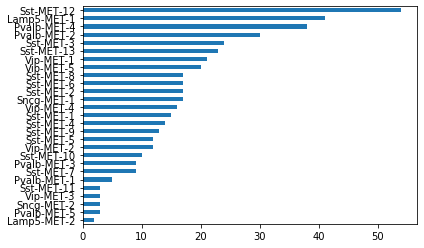

In [ ]:
ct_df = pd.DataFrame({'ct':adatas_all[0].obs['cell_type_TEM'].values})#,'ct_less':cell_type_less
plt.figure()
ct_df.ct.value_counts().sort_values().plot(kind = 'barh')


In [ ]:

model.load_model(f"{root_save_path}/train_best.pt")
losses = model.evaluate(adatas_all,give_losses=True,stage='train')
predict_label = model.predict_label(adatas_all)
adata_fused = model.infer(adatas_all)
adata_fused.obs['label'] = list(adatas_all[0].obs['label'])
adata_fused.obs['label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['label'].values]


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
from sklearn.utils.multiclass import unique_labels


pseudo_label = np.array(adata_fused.obs['predicted_label'].values)
cmat = confusion_matrix(adata_fused.obs['label'], pseudo_label)
ri, ci = linear_sum_assignment(-cmat)
ordered_all = cmat[np.ix_(ri, ci)]
major_sub_names = {}
pred_labels_re_order = copy.deepcopy(pseudo_label)
for re_oder,(lb_correct,lb) in enumerate(zip(unique_labels(adata_fused.obs['label'], pseudo_label)[ri],
                                unique_labels(adata_fused.obs['label'], pseudo_label)[ci])):
  idx = pseudo_label==lb
  if any(idx):
    nm = '-'.join(lb_correct.split('-')[:-1])
    if nm in major_sub_names.keys():
      major_sub_names[nm]+=1
    else:
      major_sub_names[nm]=1
    
    pred_labels_re_order[idx] = f'{nm}-{major_sub_names[nm]}-Uni'#f'{lb_correct}-Uni'#

adata_fused.obs['predicted_label'] = pred_labels_re_order


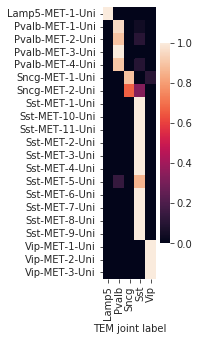

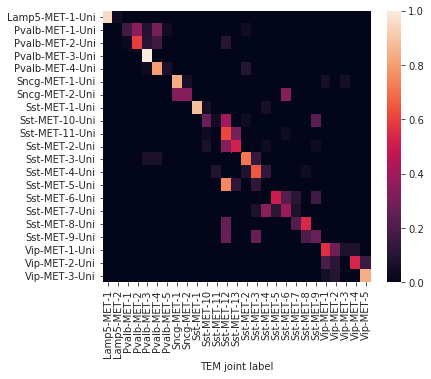

In [ ]:
sns.set_style('ticks')
adata_fused.obs['predicted_label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['predicted_label'].values]
cmat = confusion_matrix(adata_fused.obs['predicted_label'], adata_fused.obs['label_less'])
cmat = cmat[:,cmat.sum(axis=0)!=0]
cmat = cmat[cmat.sum(axis=1)!=0,:]
cmat = (cmat.T / cmat.sum(axis=1)).T

fig,ax = plt.subplots(figsize=[1.2,5])
sns.heatmap(cmat,ax=ax,yticklabels=unique_labels(adata_fused.obs['predicted_label']),xticklabels=unique_labels(adata_fused.obs['label_less']),vmin=0, vmax=1)
plt.xlabel('TEM joint label')
plt.savefig('./figures/major_matching_heatmap.pdf')

fig,ax = plt.subplots(figsize=[6,5])
ordered = ordered_all[:,ordered_all.sum(axis=0)!=0]
ordered = ordered[ordered.sum(axis=1)!=0,:]
ordered_re = ordered.T
ordered_norm = (ordered_re.T / ordered_re.sum(axis=1)).T

sns.heatmap(ordered_norm,ax=ax,xticklabels=unique_labels(adata_fused.obs['label']),yticklabels=unique_labels(adata_fused.obs['predicted_label']),vmin=0, vmax=1)
plt.xlabel('TEM joint label')
plt.savefig('./figures/sub_matching_heatmap.pdf')





In [ ]:
from sklearn.metrics import accuracy_score,adjusted_rand_score
[adjusted_rand_score(adata_fused.obs['label_less'], adata_fused.obs['predicted_label_less']),adjusted_rand_score(adata_fused.obs['label'], adata_fused.obs['predicted_label'])]

[0.9159734746786845, 0.46727466238379267]

In [ ]:
len(adata_fused.obs['predicted_label'].unique())

21

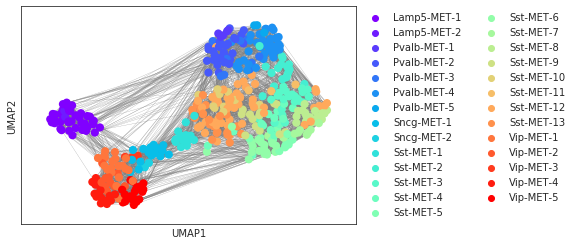

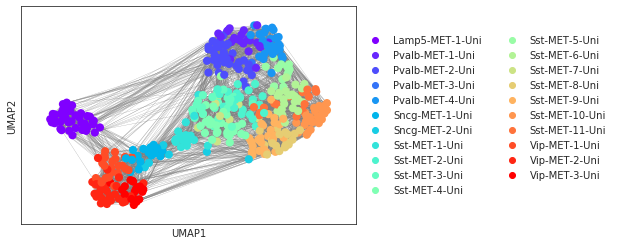

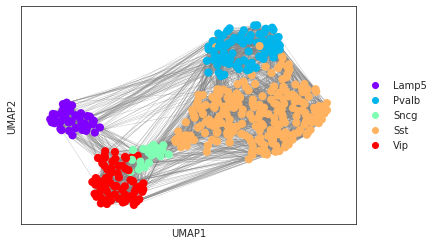

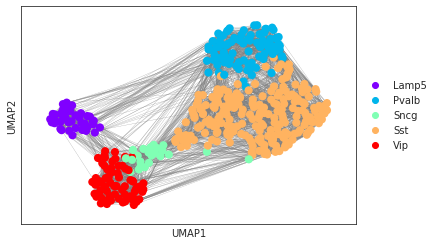

In [ ]:

sc.pl.umap(adata_fused,color=['label'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_orig_MET.pdf')
sc.pl.umap(adata_fused,color=['predicted_label'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_Uni_MET.pdf')


sc.pl.umap(adata_fused,color=['label_less'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_MET_comparison.pdf')
sc.pl.umap(adata_fused,color=['predicted_label_less'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_MET_comparison_no_legend.pdf')
